In [1]:
import pypsa
import xarray as xr
import linopy as lp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import beta
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

In [2]:
horizon = 48

n = pypsa.Network('base_s_1__none_2045_lt.nc')
n.optimize.fix_optimal_capacities()
real_price = n.buses_t.marginal_price["DE0 0"]

INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores


In [3]:

# create a new shell-network
def prepare_profit_optimization_network():
    m = pypsa.Network()

    # take the base network 2045
    n = pypsa.Network('base_s_1__none_2045_lt.nc')

    # fix the capacities and create the model
    n.optimize.fix_optimal_capacities()
    n.optimize.create_model()
    # fix m to the size of n
    m.set_snapshots(n.snapshots)



    # Stores filtern - get all stores that contain battery
    battery_stores = n.stores[n.stores.carrier.str.contains("battery", case=False, na=False)]
    battery_buses = battery_stores.bus.unique()

    # Links filtern - get all links that contain battery (e.g. battery charger / discharger)
    link_mask = (
        n.links.carrier.str.contains("battery", case=False, na=False)
    )
    battery_links = n.links[link_mask]

    # Get all buses
    store_buses = battery_stores.bus.tolist()
    link_buses = pd.concat([
        battery_links.bus0, battery_links.bus1,
        battery_links.bus2, battery_links.bus3
    ]).dropna().tolist()

    needed_buses = list(set(store_buses + link_buses))
    needed_buses = [b for b in needed_buses if isinstance(b, str) and b.strip()]


    # Copy all buses, links and stores that refere to battery from model n to model m
    m.import_components_from_dataframe(n.buses.loc[needed_buses], "Bus")
    m.import_components_from_dataframe(battery_stores, "Store")
    m.import_components_from_dataframe(battery_links, "Link")

    # Add a free Generator so the battery storage can consume power
    m.add("Generator", "source", bus="DE0 0", p_nom=10000000000000, marginal_cost=0)

    # Add a constant load so the battery storage can discharge power
    m.add("Load",
        "fixed_load",
        bus="DE0 0", 
        p_set=5000000000)   

    # create the model
    m.optimize.create_model()

    return m


### Extra Functionality for the Optimization

# get the prices from the different szenarios
def change_obj(price_list):

    def helper(k,sns):
        print(sns[-1])
        # get battery charger, discharger and the efficiency
        battery_charger_2045 = k.model.variables["Link-p"].sel({"Link":"DE0 0 battery charger-2045"})
        battery_discharger_2045 = k.model.variables["Link-p"].sel({"Link":"DE0 0 battery discharger-2045"})

        battery_charger_2040 = k.model.variables["Link-p"].sel({"Link":"DE0 0 battery charger-2040"})
        battery_discharger_2040 = k.model.variables["Link-p"].sel({"Link":"DE0 0 battery discharger-2040"})
        efficiency_2045 = k.links.efficiency["DE0 0 battery charger-2045"]
        efficiency_2040 = k.links.efficiency["DE0 0 battery charger-2040"]

        capacity_battery_end = (k.model.variables["Store-e"].sel({"Store": "DE0 0 battery-2045", "snapshot": sns[-1]}) +
                                     k.model.variables["Store-e"].sel({"Store": "DE0 0 battery-2040", "snapshot": sns[-1]}) +
                                     k.model.variables["Store-e"].sel({"Store": "DE0 0 battery-2035", "snapshot": sns[-1]}) +
                                     k.model.variables["Store-e"].sel({"Store": "DE0 0 battery-2030", "snapshot": sns[-1]})
                                     )
        

        # Stochastic Profit Optimization:
        # for each price sum the expected profits and then maximize the resulting function.

        expected_profit = 0
        for price in price_list:
            # Umwandlung in xarray.DataArray mit passender snapshot-Koord.
            price_xr = xr.DataArray(price.values, coords={"snapshot": price.index}, dims="snapshot")

            last_time = sns[-1]
            if (last_time + pd.Timedelta(hours=24)).year > 2019:
                forecast_min = 0
            else:
                forecast_min = price[last_time : last_time + pd.Timedelta(hours=24)].min()
               
            #
            expected_profit += ((battery_discharger_2040 *price_xr 
                               + battery_discharger_2045 * price_xr 
                               - battery_charger_2040 * price_xr / efficiency_2040 
                               - battery_charger_2045 * price_xr / efficiency_2045
                               ).sum()
                               + capacity_battery_end * forecast_min
                               )/ len(price_list)

        k.model.objective = expected_profit 
        k.model.sense = 'max'

    return helper


def smart_edge_biased_multipliers(x, E_max=0.42, H=30, step_hours=3,
                                   alpha_min=0.5, alpha_max=20):
    """
    Für jeden Punkt:
      - dev = Abweichung
      - alpha = steuert U-Form vs. Mittelkugel
    """

    # sodass die Werte reproduzierbar sind
    #np.random.seed(42)
    # Basis dev
    time_points = np.arange(horizon) * step_hours
    base_deviations = E_max * (1 - np.exp(-time_points / H))
    base_deviations[0] = 0

    deviations = base_deviations[:x]

    # Für jeden dev: alpha zwischen alpha_max und alpha_min mappen
    alphas = alpha_max - (deviations / E_max) * (alpha_max - alpha_min)

    # Ziehe Beta(alpha, alpha)
    u = np.array([beta.rvs(a, a) for a in alphas])

    # Mappe Beta(0,1) auf [1 - dev, 1 + dev]
    multipliers = (1 - deviations) + u * 2 * deviations

    return multipliers


def wind_noise(hours, scaling_factor):

    # 2. MSE-Werte für LSTM-Modell aus Tabelle bis 168h --> aus der Tabelle des Papers (0 von mir)
    horizons = np.array([0, 24, 48, 72, 96, 168, 336])
    mse_values = np.array([0, 0.499, 0.794, 0.899, 0.943, 1.011, 1.064])
    rmse_std = np.sqrt(mse_values)  # RMSE in Standardform

    # 3. Skaliere RMSE auf echte MW-Einheit
    rmse_MW = rmse_std * scaling_factor

    # 4. Interpolation der RMSE auf 144h
    interp_rmse = interp1d(horizons, rmse_MW, kind='linear', fill_value='extrapolate')
    rmse_per_hour = interp_rmse(np.arange(0, hours*3, 3))  # Stunden 1–144


    # 5. Rauschen generieren und synthetische Prognose erzeugen
    noise = np.random.normal(loc=0, scale=1.2*rmse_per_hour)
    #noise = np.clip(noise, 0, None)  # alles < 0 → 0, Rest bleibt
    return noise


def pv_noise(hours, scaling_factor):

    # 2. MSE-Werte für LSTM-Modell aus Tabelle bis 168h --> aus der Tabelle des Papers (0 von mir)
    horizons = np.array([0, 24, 48, 72, 96, 168, 336])
    mse_values = np.array([0, 0.088, 0.121, 0.143, 0.150, 1.165, 1.175])
    rmse_std = np.sqrt(mse_values)  # RMSE in Standardform

    # 3. Skaliere RMSE auf echte MW-Einheit
    rmse_MW = rmse_std * scaling_factor

    # 4. Interpolation der RMSE auf 144h
    interp_rmse = interp1d(horizons, rmse_MW, kind='linear', fill_value='extrapolate')
    rmse_per_hour = interp_rmse(np.arange(0, hours*3, 3))  # Stunden 1–144


    # 5. Rauschen generieren und synthetische Prognose erzeugen
    noise = np.random.normal(loc=0, scale=1.2*rmse_per_hour)
    #noise = np.clip(noise, 0, None)  # alles < 0 → 0, Rest bleibt
    return noise

# Wrapper Funktion um cf übergeben zu können
def make_cf_scaler():
    # eigentliche funktion zum ändern der Constraints
    def change_cf(n, sns):
        rhs = n.model.constraints["Generator-fix-p-upper"].rhs
        years = [2045, 2040, 2035, 2030, 2025, 2020]

        for year in years:
            selector = {"Generator-fix": f"DE0 0 onwind-{year}"}
            rhs.loc[selector] = rhs.loc[selector] * smart_edge_biased_multipliers(len(sns))

    return change_cf


# Wrapper Funktion um cf übergeben zu können
def change_wind_noise():
    # eigentliche funktion zum ändern der Constraints
    def change_wind(n, sns):
        rhs = n.model.constraints["Generator-fix-p-upper"].rhs
        years = [2045, 2040, 2035, 2030, 2025, 2020]

        for year in years:
            selector = {"Generator-fix": f"DE0 0 onwind-{year}"}
            scaling_factor = np.std(rhs.sel(selector).data)
            p_nom = n.generators.p_nom[f"DE0 0 onwind-{year}"]
            wind_power = rhs.sel(selector) + wind_noise(len(sns), scaling_factor)
            wind_power = wind_power.where(wind_power >= 0, 0)
            wind_power = wind_power.where(wind_power <= p_nom, p_nom)
            rhs.loc[selector] = wind_power

    return change_wind

# Wrapper Funktion um cf übergeben zu können
def change_pv_noise():
    # eigentliche funktion zum ändern der Constraints
    def change_pv(n, sns):
        rhs = n.model.constraints["Generator-fix-p-upper"].rhs
        years = [2045, 2040, 2035, 2020, 2015]

        for year in years:
            selector = {"Generator-fix": f"DE0 0 solar-{year}"}
            scaling_factor = np.std(rhs.sel(selector).data)
            pv_power = rhs.sel(selector) + pv_noise(len(sns), scaling_factor)
            pv_power = pv_power.where(pv_power >= 0, 0)
            rhs.loc[selector] = pv_power

        years = [2030, 2025]
        for year in years:
            selector = {"Generator-fix": f"DE0 0 solar-hsat-{year}"}
            scaling_factor = np.std(rhs.sel(selector).data)
            pv_power = rhs.sel(selector) + pv_noise(len(sns), scaling_factor)
            pv_power = pv_power.where(pv_power >= 0, 0)
            rhs.loc[selector] = pv_power

    return change_pv


def change_wind_and_pv_noise():
    # eigentliche funktion zum ändern der Constraints
    def change_both(n, sns):
        rhs = n.model.constraints["Generator-fix-p-upper"].rhs
        years = [2045, 2040, 2035, 2020, 2015]

        for year in years:
            selector = {"Generator-fix": f"DE0 0 solar-{year}"}
            scaling_factor = np.std(rhs.sel(selector).data)
            p_nom = p_nom = n.generators.p_nom[f"DE0 0 solar-{year}"]
            pv_power = rhs.sel(selector) + pv_noise(len(sns), scaling_factor)
            pv_power = pv_power.where(pv_power >= 0, 0)
            pv_power = pv_power.where(pv_power <= p_nom, p_nom)
            rhs.loc[selector] = pv_power

        years = [2030, 2025]
        for year in years:
            selector = {"Generator-fix": f"DE0 0 solar-hsat-{year}"}
            scaling_factor = np.std(rhs.sel(selector).data)
            p_nom = n.generators.p_nom[f"DE0 0 solar-hsat-{year}"]
            pv_power = rhs.sel(selector) + pv_noise(len(sns), scaling_factor)
            pv_power = pv_power.where(pv_power >= 0, 0)
            pv_power = pv_power.where(pv_power <= p_nom, p_nom)
            rhs.loc[selector] = pv_power

        rhs = n.model.constraints["Generator-fix-p-upper"].rhs
        years = [2045, 2040, 2035, 2030, 2025, 2020]

        for year in years:
            selector = {"Generator-fix": f"DE0 0 onwind-{year}"}
            scaling_factor = np.std(rhs.sel(selector).data)
            p_nom = n.generators.p_nom[f"DE0 0 onwind-{year}"]
            wind_power = rhs.sel(selector) + wind_noise(len(sns), scaling_factor)
            wind_power = wind_power.where(wind_power >= 0, 0)
            wind_power = wind_power.where(wind_power <= p_nom, p_nom)
            rhs.loc[selector] = wind_power

    return change_both

In [4]:
## create 3 different prices from 3 different scenarios
networks = []
for i in range(0,3):
    n = pypsa.Network('base_s_1__none_2045_lt.nc')
    n.optimize.fix_optimal_capacities()
    n.optimize.create_model()

    n.optimize.optimize_with_rolling_horizon(
    solver_name = "gurobi",
    horizon = horizon,
    overlap = 0,
    extra_functionality=change_wind_noise()
    )

    networks.append(n)



INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
{'EU', 'DE'}
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.84it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-18g9sjv0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-18g9sjv0.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9aa56fca


INFO:gurobipy:Model fingerprint: 0x9aa56fca


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4469 columns


INFO:gurobipy:Presolve removed 22641 rows and 4469 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7243 columns, 14503 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7243 columns, 14503 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.03347851e+11 -1.47191250e+13  1.53e+06 8.59e+01  4.30e+09     0s


INFO:gurobipy:   0   2.03347851e+11 -1.47191250e+13  1.53e+06 8.59e+01  4.30e+09     0s


   1   2.79720726e+10 -1.01923973e+12  1.29e+05 4.66e-11  3.33e+08     0s


INFO:gurobipy:   1   2.79720726e+10 -1.01923973e+12  1.29e+05 4.66e-11  3.33e+08     0s


   2   7.73580589e+09 -2.31116457e+11  8.61e+03 1.53e-09  3.13e+07     0s


INFO:gurobipy:   2   7.73580589e+09 -2.31116457e+11  8.61e+03 1.53e-09  3.13e+07     0s


   3   1.76430539e+09 -4.97937338e+10  6.29e+02 5.41e-10  4.31e+06     0s


INFO:gurobipy:   3   1.76430539e+09 -4.97937338e+10  6.29e+02 5.41e-10  4.31e+06     0s


   4   1.21452464e+09 -9.09953570e+09  7.43e+01 2.56e-10  7.63e+05     0s


INFO:gurobipy:   4   1.21452464e+09 -9.09953570e+09  7.43e+01 2.56e-10  7.63e+05     0s


   5   6.49015903e+08 -1.89698724e+09  1.36e+01 1.60e-10  1.84e+05     0s


INFO:gurobipy:   5   6.49015903e+08 -1.89698724e+09  1.36e+01 1.60e-10  1.84e+05     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.07 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.07 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1791    2.4570444e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1791    2.4570444e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1791 iterations and 0.09 seconds (0.06 work units)


INFO:gurobipy:Solved in 1791 iterations and 0.09 seconds (0.06 work units)


Optimal objective  2.457044353e+08


INFO:gurobipy:Optimal objective  2.457044353e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.46e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-07 00:00:00:2019-01-12 21:00:00] (2/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 247.63it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j5kgyp2b.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j5kgyp2b.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x422bf0c1


INFO:gurobipy:Model fingerprint: 0x422bf0c1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4463 columns


INFO:gurobipy:Presolve removed 22642 rows and 4463 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7249 columns, 14511 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7249 columns, 14511 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.03394655e+11 -1.47429346e+13  2.34e+06 7.89e+01  6.02e+09     0s


INFO:gurobipy:   0   3.03394655e+11 -1.47429346e+13  2.34e+06 7.89e+01  6.02e+09     0s


   1   3.81040287e+10 -1.27290802e+12  1.97e+05 5.38e-11  4.92e+08     0s


INFO:gurobipy:   1   3.81040287e+10 -1.27290802e+12  1.97e+05 5.38e-11  4.92e+08     0s


   2   8.38550430e+09 -3.00745861e+11  1.06e+04 3.18e-09  4.03e+07     0s


INFO:gurobipy:   2   8.38550430e+09 -3.00745861e+11  1.06e+04 3.18e-09  4.03e+07     0s


   3   3.77349280e+09 -6.86748771e+10  1.44e+03 4.98e-10  6.89e+06     0s


INFO:gurobipy:   3   3.77349280e+09 -6.86748771e+10  1.44e+03 4.98e-10  6.89e+06     0s


   4   1.68542462e+09 -1.63334571e+10  2.80e+02 7.62e-10  1.47e+06     0s


INFO:gurobipy:   4   1.68542462e+09 -1.63334571e+10  2.80e+02 7.62e-10  1.47e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1843    2.5762887e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1843    2.5762887e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1843 iterations and 0.09 seconds (0.06 work units)


INFO:gurobipy:Solved in 1843 iterations and 0.09 seconds (0.06 work units)


Optimal objective  2.576288698e+08


INFO:gurobipy:Optimal objective  2.576288698e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.58e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-13 00:00:00:2019-01-18 21:00:00] (3/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 192.85it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qfe18q1n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qfe18q1n.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x29caecfd


INFO:gurobipy:Model fingerprint: 0x29caecfd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4449 columns


INFO:gurobipy:Presolve removed 22641 rows and 4449 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7263 columns, 14523 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7263 columns, 14523 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.92275805e+11 -1.47735710e+13  3.06e+06 7.81e+01  7.57e+09     0s


INFO:gurobipy:   0   3.92275805e+11 -1.47735710e+13  3.06e+06 7.81e+01  7.57e+09     0s


   1   4.68834661e+10 -1.35377664e+12  2.61e+05 5.29e-11  6.32e+08     0s


INFO:gurobipy:   1   4.68834661e+10 -1.35377664e+12  2.61e+05 5.29e-11  6.32e+08     0s


   2   8.36149941e+09 -3.65131261e+11  1.26e+04 1.70e-09  4.88e+07     0s


INFO:gurobipy:   2   8.36149941e+09 -3.65131261e+11  1.26e+04 1.70e-09  4.88e+07     0s


   3   2.75821784e+09 -8.04457082e+10  1.55e+03 7.07e-10  7.76e+06     0s


INFO:gurobipy:   3   2.75821784e+09 -8.04457082e+10  1.55e+03 7.07e-10  7.76e+06     0s


   4   1.66387441e+09 -1.99273470e+10  4.72e+02 2.57e-09  1.88e+06     0s


INFO:gurobipy:   4   1.66387441e+09 -1.99273470e+10  4.72e+02 2.57e-09  1.88e+06     0s


   5   6.55213834e+08 -9.78961674e+09  3.02e+01 9.00e-10  7.39e+05     0s


INFO:gurobipy:   5   6.55213834e+08 -9.78961674e+09  3.02e+01 9.00e-10  7.39e+05     0s


   6   5.10684418e+08 -1.99302045e+09  4.05e+00 1.80e-10  1.75e+05     0s


INFO:gurobipy:   6   5.10684418e+08 -1.99302045e+09  4.05e+00 1.80e-10  1.75e+05     0s


   7   3.92152494e+08 -8.44951937e+08  1.46e+00 7.80e-11  8.63e+04     0s


INFO:gurobipy:   7   3.92152494e+08 -8.44951937e+08  1.46e+00 7.80e-11  8.63e+04     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.08 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.08 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2207    2.1670787e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2207    2.1670787e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2207 iterations and 0.10 seconds (0.07 work units)


INFO:gurobipy:Solved in 2207 iterations and 0.10 seconds (0.07 work units)


Optimal objective  2.167078750e+08


INFO:gurobipy:Optimal objective  2.167078750e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.17e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-19 00:00:00:2019-01-24 21:00:00] (4/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 233.71it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-opwe6lo2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-opwe6lo2.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xb4e62cea


INFO:gurobipy:Model fingerprint: 0xb4e62cea


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4662 columns


INFO:gurobipy:Presolve removed 22641 rows and 4662 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7050 columns, 14136 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7050 columns, 14136 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 3 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.78974523e+11 -1.47723182e+13  3.84e+06 8.63e+01  9.26e+09     0s


INFO:gurobipy:   0   4.78974523e+11 -1.47723182e+13  3.84e+06 8.63e+01  9.26e+09     0s


   1   5.72659646e+10 -1.50002808e+12  3.27e+05 5.39e-11  7.82e+08     0s


INFO:gurobipy:   1   5.72659646e+10 -1.50002808e+12  3.27e+05 5.39e-11  7.82e+08     0s


   2   1.24248913e+10 -3.75697128e+11  1.92e+04 1.23e-09  6.34e+07     0s


INFO:gurobipy:   2   1.24248913e+10 -3.75697128e+11  1.92e+04 1.23e-09  6.34e+07     0s


   3   1.90308423e+10 -1.43200287e+11  4.94e+03 2.03e-09  2.01e+07     0s


INFO:gurobipy:   3   1.90308423e+10 -1.43200287e+11  4.94e+03 2.03e-09  2.01e+07     0s


   4   2.13116521e+10 -3.05287275e+10  1.42e+03 6.17e-10  5.74e+06     0s


INFO:gurobipy:   4   2.13116521e+10 -3.05287275e+10  1.42e+03 6.17e-10  5.74e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1743    1.8973971e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1743    1.8973971e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1743 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1743 iterations and 0.10 seconds (0.05 work units)


Optimal objective  1.897397119e+10


INFO:gurobipy:Optimal objective  1.897397119e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.90e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-25 00:00:00:2019-01-30 21:00:00] (5/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 251.94it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jp_7us0j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jp_7us0j.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5c4f6a29


INFO:gurobipy:Model fingerprint: 0x5c4f6a29


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4480 columns


INFO:gurobipy:Presolve removed 22641 rows and 4480 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7232 columns, 14458 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7232 columns, 14458 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.33657254e+11 -1.47808356e+13  5.03e+06 8.27e+01  1.18e+10     0s


INFO:gurobipy:   0   6.33657254e+11 -1.47808356e+13  5.03e+06 8.27e+01  1.18e+10     0s


   1   7.24013009e+10 -1.72963085e+12  4.28e+05 5.22e-11  1.01e+09     0s


INFO:gurobipy:   1   7.24013009e+10 -1.72963085e+12  4.28e+05 5.22e-11  1.01e+09     0s


   2   1.07444012e+10 -4.60457307e+11  1.87e+04 2.72e-09  6.82e+07     0s


INFO:gurobipy:   2   1.07444012e+10 -4.60457307e+11  1.87e+04 2.72e-09  6.82e+07     0s


   3   8.10917736e+09 -9.71423291e+10  3.35e+03 1.21e-09  1.24e+07     0s


INFO:gurobipy:   3   8.10917736e+09 -9.71423291e+10  3.35e+03 1.21e-09  1.24e+07     0s


   4   3.68367331e+09 -3.95067399e+10  9.85e+02 4.03e-10  4.16e+06     0s


INFO:gurobipy:   4   3.68367331e+09 -3.95067399e+10  9.85e+02 4.03e-10  4.16e+06     0s


   5   3.05093959e+09 -3.02200960e+10  7.95e+02 3.16e-10  3.15e+06     0s


INFO:gurobipy:   5   3.05093959e+09 -3.02200960e+10  7.95e+02 3.16e-10  3.15e+06     0s


   6   2.66565628e+09 -2.79910484e+10  6.74e+02 2.79e-10  2.82e+06     0s


INFO:gurobipy:   6   2.66565628e+09 -2.79910484e+10  6.74e+02 2.79e-10  2.82e+06     0s


   7   2.25913966e+09 -2.45660226e+10  5.05e+02 2.43e-10  2.36e+06     0s


INFO:gurobipy:   7   2.25913966e+09 -2.45660226e+10  5.05e+02 2.43e-10  2.36e+06     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.08 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.08 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1828    4.8251288e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1828    4.8251288e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1828 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1828 iterations and 0.10 seconds (0.06 work units)


Optimal objective  4.825128818e+08


INFO:gurobipy:Optimal objective  4.825128818e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.83e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (6/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 213.15it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0f_sc49c.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0f_sc49c.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x21414acc


INFO:gurobipy:Model fingerprint: 0x21414acc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4435 columns


INFO:gurobipy:Presolve removed 22641 rows and 4435 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7277 columns, 14531 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7277 columns, 14531 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.72531362e+11 -1.48065654e+13  6.14e+06 6.76e+01  1.42e+10     0s


INFO:gurobipy:   0   7.72531362e+11 -1.48065654e+13  6.14e+06 6.76e+01  1.42e+10     0s


   1   8.70842092e+10 -1.92155530e+12  5.30e+05 4.50e-11  1.24e+09     0s


INFO:gurobipy:   1   8.70842092e+10 -1.92155530e+12  5.30e+05 4.50e-11  1.24e+09     0s


   2   1.11730406e+10 -5.01480900e+11  1.93e+04 3.96e-09  7.24e+07     0s


INFO:gurobipy:   2   1.11730406e+10 -5.01480900e+11  1.93e+04 3.96e-09  7.24e+07     0s


   3   1.09181557e+10 -1.17927127e+11  2.84e+03 8.32e-10  1.34e+07     0s


INFO:gurobipy:   3   1.09181557e+10 -1.17927127e+11  2.84e+03 8.32e-10  1.34e+07     0s


   4   6.64981414e+09 -2.76729800e+10  3.07e+02 9.95e-10  2.73e+06     0s


INFO:gurobipy:   4   6.64981414e+09 -2.76729800e+10  3.07e+02 9.95e-10  2.73e+06     0s


   5   3.50612479e+09 -7.68373511e+09  9.93e+01 3.57e-09  8.60e+05     0s


INFO:gurobipy:   5   3.50612479e+09 -7.68373511e+09  9.93e+01 3.57e-09  8.60e+05     0s


   6   2.42907242e+09 -2.53357720e+09  5.18e+01 1.28e-09  3.86e+05     0s


INFO:gurobipy:   6   2.42907242e+09 -2.53357720e+09  5.18e+01 1.28e-09  3.86e+05     0s


   7   1.50786765e+09 -4.79786492e+08  1.68e+01 5.86e-10  1.51e+05     0s


INFO:gurobipy:   7   1.50786765e+09 -4.79786492e+08  1.68e+01 5.86e-10  1.51e+05     0s


   8   1.07028454e+09  1.99586848e+08  2.45e+00 3.24e-10  6.19e+04     0s


INFO:gurobipy:   8   1.07028454e+09  1.99586848e+08  2.45e+00 3.24e-10  6.19e+04     0s


   9   9.86597481e+08  6.40453747e+08  8.70e-01 1.47e-10  2.46e+04     0s


INFO:gurobipy:   9   9.86597481e+08  6.40453747e+08  8.70e-01 1.47e-10  2.46e+04     0s


  10   9.50051901e+08  8.67037682e+08  3.26e-01 1.18e-10  6.04e+03     0s


INFO:gurobipy:  10   9.50051901e+08  8.67037682e+08  3.26e-01 1.18e-10  6.04e+03     0s


INFO:gurobipy:


Barrier performed 10 iterations in 0.10 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 10 iterations in 0.10 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2263    9.2523022e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2263    9.2523022e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2263 iterations and 0.12 seconds (0.07 work units)


INFO:gurobipy:Solved in 2263 iterations and 0.12 seconds (0.07 work units)


Optimal objective  9.252302199e+08


INFO:gurobipy:Optimal objective  9.252302199e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 9.25e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-06 00:00:00:2019-02-11 21:00:00] (7/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 229.52it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x79mxrhl.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x79mxrhl.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xbcc9ad09


INFO:gurobipy:Model fingerprint: 0xbcc9ad09


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4392 columns


INFO:gurobipy:Presolve removed 22641 rows and 4392 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7320 columns, 14583 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7320 columns, 14583 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.15103471e+11 -1.48484322e+13  7.27e+06 6.67e+01  1.66e+10     0s


INFO:gurobipy:   0   9.15103471e+11 -1.48484322e+13  7.27e+06 6.67e+01  1.66e+10     0s


   1   1.01731910e+11 -2.11952470e+12  6.27e+05 5.23e-11  1.46e+09     0s


INFO:gurobipy:   1   1.01731910e+11 -2.11952470e+12  6.27e+05 5.23e-11  1.46e+09     0s


   2   1.00504845e+10 -5.55257096e+11  2.00e+04 1.10e-09  7.73e+07     0s


INFO:gurobipy:   2   1.00504845e+10 -5.55257096e+11  2.00e+04 1.10e-09  7.73e+07     0s


   3   3.46067182e+09 -1.08488504e+11  2.42e+03 7.89e-10  1.10e+07     0s


INFO:gurobipy:   3   3.46067182e+09 -1.08488504e+11  2.42e+03 7.89e-10  1.10e+07     0s


   4   1.23102083e+09 -2.47364103e+10  4.63e+02 8.64e-10  2.20e+06     0s


INFO:gurobipy:   4   1.23102083e+09 -2.47364103e+10  4.63e+02 8.64e-10  2.20e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.17 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.17 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1978    2.1512375e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1978    2.1512375e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1978 iterations and 0.19 seconds (0.06 work units)


INFO:gurobipy:Solved in 1978 iterations and 0.19 seconds (0.06 work units)


Optimal objective  2.151237523e+08


INFO:gurobipy:Optimal objective  2.151237523e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-12 00:00:00:2019-02-17 21:00:00] (8/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 197.22it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-w6hdbhie.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-w6hdbhie.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x25496c1d


INFO:gurobipy:Model fingerprint: 0x25496c1d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4409 columns


INFO:gurobipy:Presolve removed 22641 rows and 4409 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 1072 rows, 7303 columns, 14566 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7303 columns, 14566 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.77493245e+12 -1.64983436e+13  3.03e+07 7.96e+01  6.59e+10     0s


INFO:gurobipy:   0   3.77493245e+12 -1.64983436e+13  3.03e+07 7.96e+01  6.59e+10     0s


   1   8.48945045e+11 -4.64452635e+12  6.24e+06 1.76e+02  1.36e+10     0s


INFO:gurobipy:   1   8.48945045e+11 -4.64452635e+12  6.24e+06 1.76e+02  1.36e+10     0s


   2   7.67745577e+10 -2.02770685e+12  5.02e+05 2.00e-09  1.20e+09     0s


INFO:gurobipy:   2   7.67745577e+10 -2.02770685e+12  5.02e+05 2.00e-09  1.20e+09     0s


   3   1.19204896e+10 -4.70633014e+11  3.25e+04 1.59e-09  9.60e+07     0s


INFO:gurobipy:   3   1.19204896e+10 -4.70633014e+11  3.25e+04 1.59e-09  9.60e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.16 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.16 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1833    2.1607914e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1833    2.1607914e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1833 iterations and 0.18 seconds (0.06 work units)


INFO:gurobipy:Solved in 1833 iterations and 0.18 seconds (0.06 work units)


Optimal objective  2.160791423e+08


INFO:gurobipy:Optimal objective  2.160791423e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.16e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-18 00:00:00:2019-02-23 21:00:00] (9/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 246.91it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mcin4v8g.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mcin4v8g.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xaf829348


INFO:gurobipy:Model fingerprint: 0xaf829348


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4390 columns


INFO:gurobipy:Presolve removed 22642 rows and 4390 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7322 columns, 14584 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7322 columns, 14584 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27380945e+12 -1.82557223e+13  3.43e+07 8.35e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27380945e+12 -1.82557223e+13  3.43e+07 8.35e+01  7.46e+10     0s


   1   8.52672319e+11 -5.25295509e+12  6.17e+06 3.68e+02  1.34e+10     0s


INFO:gurobipy:   1   8.52672319e+11 -5.25295509e+12  6.17e+06 3.68e+02  1.34e+10     0s


   2   8.70641150e+10 -1.76933170e+12  5.67e+05 6.12e-11  1.31e+09     0s


INFO:gurobipy:   2   8.70641150e+10 -1.76933170e+12  5.67e+05 6.12e-11  1.31e+09     0s


   3   1.04588424e+10 -4.56595161e+11  1.71e+04 3.80e-10  6.49e+07     0s


INFO:gurobipy:   3   1.04588424e+10 -4.56595161e+11  1.71e+04 3.80e-10  6.49e+07     0s


   4   6.56227979e+09 -9.97615390e+10  2.34e+03 1.07e-10  1.06e+07     0s


INFO:gurobipy:   4   6.56227979e+09 -9.97615390e+10  2.34e+03 1.07e-10  1.06e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1786    2.5643046e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1786    2.5643046e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1786 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1786 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.564304639e+08


INFO:gurobipy:Optimal objective  2.564304639e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.56e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-24 00:00:00:2019-03-01 21:00:00] (10/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 240.17it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ib95oran.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ib95oran.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc6374f54


INFO:gurobipy:Model fingerprint: 0xc6374f54


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4436 columns


INFO:gurobipy:Presolve removed 22641 rows and 4436 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 1072 rows, 7276 columns, 14539 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7276 columns, 14539 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.00922791e+12 -1.85890924e+13  3.22e+07 7.34e+01  7.02e+10     0s


INFO:gurobipy:   0   4.00922791e+12 -1.85890924e+13  3.22e+07 7.34e+01  7.02e+10     0s


   1   7.62732085e+11 -5.19626200e+12  5.52e+06 5.49e+02  1.20e+10     0s


INFO:gurobipy:   1   7.62732085e+11 -5.19626200e+12  5.52e+06 5.49e+02  1.20e+10     0s


   2   7.36619278e+10 -1.71894492e+12  4.69e+05 1.68e-09  1.10e+09     0s


INFO:gurobipy:   2   7.36619278e+10 -1.71894492e+12  4.69e+05 1.68e-09  1.10e+09     0s


   3   1.05200453e+10 -4.12325625e+11  1.47e+04 3.23e-09  5.72e+07     0s


INFO:gurobipy:   3   1.05200453e+10 -4.12325625e+11  1.47e+04 3.23e-09  5.72e+07     0s


   4   8.65376975e+09 -1.10675910e+11  2.40e+03 4.09e-10  1.18e+07     0s


INFO:gurobipy:   4   8.65376975e+09 -1.10675910e+11  2.40e+03 4.09e-10  1.18e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.15 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.15 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1700    3.5485850e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1700    3.5485850e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1700 iterations and 0.17 seconds (0.06 work units)


INFO:gurobipy:Solved in 1700 iterations and 0.17 seconds (0.06 work units)


Optimal objective  3.548585008e+08


INFO:gurobipy:Optimal objective  3.548585008e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.55e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (11/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.95it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-68tyo2pf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-68tyo2pf.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc1bd5820


INFO:gurobipy:Model fingerprint: 0xc1bd5820


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4378 columns


INFO:gurobipy:Presolve removed 22641 rows and 4378 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7334 columns, 14597 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7334 columns, 14597 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.02078497e+12 -1.86673233e+13  3.23e+07 7.21e+01  7.03e+10     0s


INFO:gurobipy:   0   4.02078497e+12 -1.86673233e+13  3.23e+07 7.21e+01  7.03e+10     0s


   1   6.92435912e+11 -5.26042283e+12  4.94e+06 7.06e+02  1.08e+10     0s


INFO:gurobipy:   1   6.92435912e+11 -5.26042283e+12  4.94e+06 7.06e+02  1.08e+10     0s


   2   6.59003923e+10 -1.72042115e+12  4.15e+05 1.43e-09  9.83e+08     0s


INFO:gurobipy:   2   6.59003923e+10 -1.72042115e+12  4.15e+05 1.43e-09  9.83e+08     0s


   3   8.21040820e+09 -4.11651818e+11  1.21e+04 2.85e-10  5.14e+07     0s


INFO:gurobipy:   3   8.21040820e+09 -4.11651818e+11  1.21e+04 2.85e-10  5.14e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1846    2.1448745e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1846    2.1448745e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1846 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1846 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.144874520e+08


INFO:gurobipy:Optimal objective  2.144874520e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-08 00:00:00:2019-03-13 21:00:00] (12/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 248.94it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qoitvf4e.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qoitvf4e.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x8122c7ba


INFO:gurobipy:Model fingerprint: 0x8122c7ba


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 4e+02]


INFO:gurobipy:  Bounds range     [4e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4373 columns


INFO:gurobipy:Presolve removed 22641 rows and 4373 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7339 columns, 14602 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7339 columns, 14602 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24568576e+12 -1.83510573e+13  3.41e+07 6.77e+01  7.41e+10     0s


INFO:gurobipy:   0   4.24568576e+12 -1.83510573e+13  3.41e+07 6.77e+01  7.41e+10     0s


   1   7.60357028e+11 -5.25873251e+12  5.43e+06 2.67e+02  1.18e+10     0s


INFO:gurobipy:   1   7.60357028e+11 -5.25873251e+12  5.43e+06 2.67e+02  1.18e+10     0s


   2   6.53550121e+10 -1.79675661e+12  4.12e+05 1.25e-10  9.80e+08     0s


INFO:gurobipy:   2   6.53550121e+10 -1.79675661e+12  4.12e+05 1.25e-10  9.80e+08     0s


   3   8.15881992e+09 -4.18717248e+11  1.29e+04 2.61e-09  5.33e+07     0s


INFO:gurobipy:   3   8.15881992e+09 -4.18717248e+11  1.29e+04 2.61e-09  5.33e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1853    2.1476250e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1853    2.1476250e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1853 iterations and 0.17 seconds (0.05 work units)


INFO:gurobipy:Solved in 1853 iterations and 0.17 seconds (0.05 work units)


Optimal objective  2.147624975e+08


INFO:gurobipy:Optimal objective  2.147624975e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-14 00:00:00:2019-03-19 21:00:00] (13/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.02it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4iohp1gk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4iohp1gk.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4e44cf22


INFO:gurobipy:Model fingerprint: 0x4e44cf22


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 6e+02]


INFO:gurobipy:  Bounds range     [4e+02, 6e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4396 columns


INFO:gurobipy:Presolve removed 22641 rows and 4396 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7316 columns, 14579 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7316 columns, 14579 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.03411099e+12 -1.80237526e+13  3.24e+07 6.75e+01  7.05e+10     0s


INFO:gurobipy:   0   4.03411099e+12 -1.80237526e+13  3.24e+07 6.75e+01  7.05e+10     0s


   1   6.59205920e+11 -5.12315896e+12  4.66e+06 5.62e+02  1.02e+10     0s


INFO:gurobipy:   1   6.59205920e+11 -5.12315896e+12  4.66e+06 5.62e+02  1.02e+10     0s


   2   5.27689578e+10 -1.72822183e+12  3.19e+05 8.89e-11  7.81e+08     0s


INFO:gurobipy:   2   5.27689578e+10 -1.72822183e+12  3.19e+05 8.89e-11  7.81e+08     0s


   3   8.08271732e+09 -3.66668889e+11  1.33e+04 3.09e-09  5.01e+07     0s


INFO:gurobipy:   3   8.08271732e+09 -3.66668889e+11  1.33e+04 3.09e-09  5.01e+07     0s


   4   1.70033223e+09 -8.46145978e+10  9.89e+02 7.34e-10  7.17e+06     0s


INFO:gurobipy:   4   1.70033223e+09 -8.46145978e+10  9.89e+02 7.34e-10  7.17e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1888    2.1478289e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1888    2.1478289e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1888 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1888 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.147828907e+08


INFO:gurobipy:Optimal objective  2.147828907e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-20 00:00:00:2019-03-25 21:00:00] (14/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 249.37it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m6xoa6_4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m6xoa6_4.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9bc6a497


INFO:gurobipy:Model fingerprint: 0x9bc6a497


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 7e+02]


INFO:gurobipy:  Bounds range     [5e+02, 7e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4430 columns


INFO:gurobipy:Presolve removed 22641 rows and 4430 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7282 columns, 14545 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7282 columns, 14545 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27412012e+12 -1.83317189e+13  3.43e+07 8.38e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27412012e+12 -1.83317189e+13  3.43e+07 8.38e+01  7.46e+10     0s


   1   7.02999407e+11 -5.33052624e+12  4.95e+06 4.63e+02  1.08e+10     0s


INFO:gurobipy:   1   7.02999407e+11 -5.33052624e+12  4.95e+06 4.63e+02  1.08e+10     0s


   2   5.67548884e+10 -1.74189041e+12  3.42e+05 7.58e-11  8.31e+08     0s


INFO:gurobipy:   2   5.67548884e+10 -1.74189041e+12  3.42e+05 7.58e-11  8.31e+08     0s


   3   9.43458600e+09 -3.62821873e+11  1.42e+04 9.25e-10  5.20e+07     0s


INFO:gurobipy:   3   9.43458600e+09 -3.62821873e+11  1.42e+04 9.25e-10  5.20e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1703    2.1480302e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1703    2.1480302e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1703 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1703 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.148030179e+08


INFO:gurobipy:Optimal objective  2.148030179e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-26 00:00:00:2019-03-31 21:00:00] (15/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 207.84it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y3ei1tr5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y3ei1tr5.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x8189c250


INFO:gurobipy:Model fingerprint: 0x8189c250


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22640 rows and 4429 columns


INFO:gurobipy:Presolve removed 22640 rows and 4429 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1073 rows, 7283 columns, 14547 nonzeros


INFO:gurobipy:Presolved: 1073 rows, 7283 columns, 14547 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.800e+03


INFO:gurobipy: AA' NZ     : 2.800e+03


 Factor NZ  : 2.178e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.178e+04 (roughly 4 MB of memory)


 Factor Ops : 6.692e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.692e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.01132455e+12 -1.82546379e+13  3.22e+07 7.73e+01  7.01e+10     0s


INFO:gurobipy:   0   4.01132455e+12 -1.82546379e+13  3.22e+07 7.73e+01  7.01e+10     0s


   1   4.15467217e+11 -5.16993636e+12  2.73e+06 7.13e+02  6.12e+09     0s


INFO:gurobipy:   1   4.15467217e+11 -5.16993636e+12  2.73e+06 7.13e+02  6.12e+09     0s


   2   3.53899913e+10 -1.46906104e+12  1.82e+05 2.27e+01  4.79e+08     0s


INFO:gurobipy:   2   3.53899913e+10 -1.46906104e+12  1.82e+05 2.27e+01  4.79e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1601    2.1481646e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1601    2.1481646e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1601 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1601 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.148164596e+08


INFO:gurobipy:Optimal objective  2.148164596e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (16/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 242.62it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-99wjqhak.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-99wjqhak.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd868e885


INFO:gurobipy:Model fingerprint: 0xd868e885


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4399 columns


INFO:gurobipy:Presolve removed 22638 rows and 4399 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7313 columns, 14579 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7313 columns, 14579 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27573189e+12 -1.83437254e+13  3.43e+07 7.56e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27573189e+12 -1.83437254e+13  3.43e+07 7.56e+01  7.46e+10     0s


   1   6.57746914e+11 -5.30993845e+12  4.54e+06 3.87e+02  9.96e+09     0s


INFO:gurobipy:   1   6.57746914e+11 -5.30993845e+12  4.54e+06 3.87e+02  9.96e+09     0s


   2   4.79256275e+10 -1.67227310e+12  2.75e+05 4.00e-09  6.85e+08     0s


INFO:gurobipy:   2   4.79256275e+10 -1.67227310e+12  2.75e+05 4.00e-09  6.85e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1523    2.6151241e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1523    2.6151241e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1523 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1523 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.615124085e+08


INFO:gurobipy:Optimal objective  2.615124085e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.62e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-07 00:00:00:2019-04-12 21:00:00] (17/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 244.84it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1yegjmwi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1yegjmwi.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x7a1c00e0


INFO:gurobipy:Model fingerprint: 0x7a1c00e0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4352 columns


INFO:gurobipy:Presolve removed 22636 rows and 4352 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7360 columns, 14628 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7360 columns, 14628 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24709187e+12 -1.84105652e+13  3.41e+07 6.38e+01  7.41e+10     0s


INFO:gurobipy:   0   4.24709187e+12 -1.84105652e+13  3.41e+07 6.38e+01  7.41e+10     0s


   1   6.52424301e+11 -5.23638410e+12  4.56e+06 2.47e+02  9.98e+09     0s


INFO:gurobipy:   1   6.52424301e+11 -5.23638410e+12  4.56e+06 2.47e+02  9.98e+09     0s


   2   4.22534969e+10 -1.64295269e+12  2.39e+05 4.20e-09  6.07e+08     0s


INFO:gurobipy:   2   4.22534969e+10 -1.64295269e+12  2.39e+05 4.20e-09  6.07e+08     0s


   3   8.48413760e+09 -2.88059732e+11  9.28e+03 1.90e-10  3.70e+07     0s


INFO:gurobipy:   3   8.48413760e+09 -2.88059732e+11  9.28e+03 1.90e-10  3.70e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1564    2.2762676e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1564    2.2762676e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1564 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1564 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.276267594e+08


INFO:gurobipy:Optimal objective  2.276267594e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.28e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-13 00:00:00:2019-04-18 21:00:00] (18/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 212.72it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bm6edj0e.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bm6edj0e.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x58c9e59c


INFO:gurobipy:Model fingerprint: 0x58c9e59c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4364 columns


INFO:gurobipy:Presolve removed 22636 rows and 4364 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7348 columns, 14600 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7348 columns, 14600 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27608810e+12 -1.81010453e+13  3.43e+07 3.03e+02  7.45e+10     0s


INFO:gurobipy:   0   4.27608810e+12 -1.81010453e+13  3.43e+07 3.03e+02  7.45e+10     0s


   1   4.82552126e+11 -5.28746843e+12  3.17e+06 3.92e+02  7.06e+09     0s


INFO:gurobipy:   1   4.82552126e+11 -5.28746843e+12  3.17e+06 3.92e+02  7.06e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1519    2.1441945e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1519    2.1441945e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1519 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1519 iterations and 0.14 seconds (0.05 work units)


Optimal objective  2.144194483e+08


INFO:gurobipy:Optimal objective  2.144194483e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-19 00:00:00:2019-04-24 21:00:00] (19/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 254.31it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lwtfk_p2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lwtfk_p2.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x930b3d9e


INFO:gurobipy:Model fingerprint: 0x930b3d9e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4587 columns


INFO:gurobipy:Presolve removed 22637 rows and 4587 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7125 columns, 14193 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7125 columns, 14193 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.15532004e+12 -1.82533004e+13  3.34e+07 3.49e+02  7.18e+10     0s


INFO:gurobipy:   0   4.15532004e+12 -1.82533004e+13  3.34e+07 3.49e+02  7.18e+10     0s


   1   4.88745376e+11 -5.23826650e+12  3.03e+06 4.86e+02  6.70e+09     0s


INFO:gurobipy:   1   4.88745376e+11 -5.23826650e+12  3.03e+06 4.86e+02  6.70e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1645    2.1413054e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1645    2.1413054e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1645 iterations and 0.16 seconds (0.05 work units)


INFO:gurobipy:Solved in 1645 iterations and 0.16 seconds (0.05 work units)


Optimal objective  2.141305358e+08


INFO:gurobipy:Optimal objective  2.141305358e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-25 00:00:00:2019-04-30 21:00:00] (20/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 243.45it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j9puwjs4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j9puwjs4.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xdbef4d13


INFO:gurobipy:Model fingerprint: 0xdbef4d13


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4423 columns


INFO:gurobipy:Presolve removed 22637 rows and 4423 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7289 columns, 14510 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7289 columns, 14510 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24384936e+12 -1.83519834e+13  3.41e+07 3.04e+02  7.39e+10     0s


INFO:gurobipy:   0   4.24384936e+12 -1.83519834e+13  3.41e+07 3.04e+02  7.39e+10     0s


   1   4.64366812e+11 -5.27107527e+12  3.01e+06 3.01e+02  6.72e+09     0s


INFO:gurobipy:   1   4.64366812e+11 -5.27107527e+12  3.01e+06 3.01e+02  6.72e+09     0s


   2   2.67919424e+10 -1.37763850e+12  1.23e+05 2.43e-09  3.49e+08     0s


INFO:gurobipy:   2   2.67919424e+10 -1.37763850e+12  1.23e+05 2.43e-09  3.49e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1578    2.1456856e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1578    2.1456856e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1578 iterations and 0.25 seconds (0.05 work units)


INFO:gurobipy:Solved in 1578 iterations and 0.25 seconds (0.05 work units)


Optimal objective  2.145685563e+08


INFO:gurobipy:Optimal objective  2.145685563e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (21/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 191.64it/s]
INFO:linopy.io: Writing time: 0.43s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ku10ysij.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ku10ysij.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc47832bd


INFO:gurobipy:Model fingerprint: 0xc47832bd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4339 columns


INFO:gurobipy:Presolve removed 22637 rows and 4339 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 1076 rows, 7373 columns, 14640 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7373 columns, 14640 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27328294e+12 -1.81246635e+13  3.43e+07 7.67e+01  7.45e+10     0s


INFO:gurobipy:   0   4.27328294e+12 -1.81246635e+13  3.43e+07 7.67e+01  7.45e+10     0s


   1   4.59833941e+11 -5.26028946e+12  2.97e+06 3.76e+02  6.63e+09     0s


INFO:gurobipy:   1   4.59833941e+11 -5.26028946e+12  2.97e+06 3.76e+02  6.63e+09     0s


   2   2.08843151e+10 -1.31588366e+12  8.85e+04 2.17e+00  2.72e+08     0s


INFO:gurobipy:   2   2.08843151e+10 -1.31588366e+12  8.85e+04 2.17e+00  2.72e+08     0s


   3   6.21342328e+09 -2.40371657e+11  5.22e+03 7.43e-10  2.56e+07     0s


INFO:gurobipy:   3   6.21342328e+09 -2.40371657e+11  5.22e+03 7.43e-10  2.56e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.12 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.12 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1646    2.1473870e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1646    2.1473870e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1646 iterations and 0.18 seconds (0.05 work units)


INFO:gurobipy:Solved in 1646 iterations and 0.18 seconds (0.05 work units)


Optimal objective  2.147386995e+08


INFO:gurobipy:Optimal objective  2.147386995e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-07 00:00:00:2019-05-12 21:00:00] (22/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 213.87it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pnhxyuw7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pnhxyuw7.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2d40e9c0


INFO:gurobipy:Model fingerprint: 0x2d40e9c0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4336 columns


INFO:gurobipy:Presolve removed 22637 rows and 4336 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1076 rows, 7376 columns, 14643 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7376 columns, 14643 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24798836e+12 -1.85434955e+13  3.41e+07 5.95e+01  7.42e+10     0s


INFO:gurobipy:   0   4.24798836e+12 -1.85434955e+13  3.41e+07 5.95e+01  7.42e+10     0s


   1   4.47726369e+11 -5.29488532e+12  2.94e+06 3.64e+02  6.58e+09     0s


INFO:gurobipy:   1   4.47726369e+11 -5.29488532e+12  2.94e+06 3.64e+02  6.58e+09     0s


   2   2.08290690e+10 -1.30169798e+12  8.99e+04 3.92e+00  2.73e+08     0s


INFO:gurobipy:   2   2.08290690e+10 -1.30169798e+12  8.99e+04 3.92e+00  2.73e+08     0s


   3   6.95011047e+09 -3.05586837e+11  6.73e+03 7.07e-10  3.29e+07     0s


INFO:gurobipy:   3   6.95011047e+09 -3.05586837e+11  6.73e+03 7.07e-10  3.29e+07     0s


   4   2.39632951e+09 -8.70182378e+10  6.38e+02 5.19e-10  6.88e+06     0s


INFO:gurobipy:   4   2.39632951e+09 -8.70182378e+10  6.38e+02 5.19e-10  6.88e+06     0s


   5   1.30755045e+09 -1.45404943e+10  3.12e+02 1.20e-10  1.30e+06     0s


INFO:gurobipy:   5   1.30755045e+09 -1.45404943e+10  3.12e+02 1.20e-10  1.30e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.14 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.14 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1850    2.1463720e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1850    2.1463720e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1850 iterations and 0.21 seconds (0.06 work units)


INFO:gurobipy:Solved in 1850 iterations and 0.21 seconds (0.06 work units)


Optimal objective  2.146372043e+08


INFO:gurobipy:Optimal objective  2.146372043e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-13 00:00:00:2019-05-18 21:00:00] (23/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 196.30it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cbj2pw4l.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cbj2pw4l.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xfb26f5ac


INFO:gurobipy:Model fingerprint: 0xfb26f5ac


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4371 columns


INFO:gurobipy:Presolve removed 22638 rows and 4371 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7341 columns, 14562 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7341 columns, 14562 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27631205e+12 -1.83570172e+13  3.43e+07 2.50e+02  7.45e+10     0s


INFO:gurobipy:   0   4.27631205e+12 -1.83570172e+13  3.43e+07 2.50e+02  7.45e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.18 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.18 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1585    2.1504638e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1585    2.1504638e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1585 iterations and 0.21 seconds (0.06 work units)


INFO:gurobipy:Solved in 1585 iterations and 0.21 seconds (0.06 work units)


Optimal objective  2.150463800e+08


INFO:gurobipy:Optimal objective  2.150463800e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-19 00:00:00:2019-05-24 21:00:00] (24/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 220.88it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r99wticj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r99wticj.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xfbae4fe3


INFO:gurobipy:Model fingerprint: 0xfbae4fe3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 5e+02]


INFO:gurobipy:  Bounds range     [2e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4514 columns


INFO:gurobipy:Presolve removed 22636 rows and 4514 columns


Presolve time: 0.07s


INFO:gurobipy:Presolve time: 0.07s


Presolved: 1077 rows, 7198 columns, 14298 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7198 columns, 14298 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.25105488e+12 -1.83299788e+13  3.41e+07 2.86e+02  7.35e+10     0s


INFO:gurobipy:   0   4.25105488e+12 -1.83299788e+13  3.41e+07 2.86e+02  7.35e+10     0s


   1   4.99572286e+11 -5.22632235e+12  3.09e+06 2.36e+02  6.84e+09     0s


INFO:gurobipy:   1   4.99572286e+11 -5.22632235e+12  3.09e+06 2.36e+02  6.84e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.17 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.17 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1724    2.1462281e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1724    2.1462281e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1724 iterations and 0.23 seconds (0.05 work units)


INFO:gurobipy:Solved in 1724 iterations and 0.23 seconds (0.05 work units)


Optimal objective  2.146228114e+08


INFO:gurobipy:Optimal objective  2.146228114e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-25 00:00:00:2019-05-30 21:00:00] (25/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 253.25it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-v5a4o3c0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-v5a4o3c0.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe440dec1


INFO:gurobipy:Model fingerprint: 0xe440dec1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 5e+02]


INFO:gurobipy:  Bounds range     [3e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4488 columns


INFO:gurobipy:Presolve removed 22636 rows and 4488 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7224 columns, 14336 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7224 columns, 14336 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27655015e+12 -1.81028809e+13  3.44e+07 3.01e+02  7.40e+10     0s


INFO:gurobipy:   0   4.27655015e+12 -1.81028809e+13  3.44e+07 3.01e+02  7.40e+10     0s


   1   4.87075872e+11 -5.27265656e+12  3.06e+06 4.35e+02  6.78e+09     0s


INFO:gurobipy:   1   4.87075872e+11 -5.27265656e+12  3.06e+06 4.35e+02  6.78e+09     0s


   2   1.83936274e+10 -1.19775432e+12  6.44e+04 1.11e+00  2.15e+08     0s


INFO:gurobipy:   2   1.83936274e+10 -1.19775432e+12  6.44e+04 1.11e+00  2.15e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1771    2.1408904e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1771    2.1408904e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1771 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1771 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.140890402e+08


INFO:gurobipy:Optimal objective  2.140890402e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (26/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 234.10it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_ihxmv0c.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_ihxmv0c.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x47ac3d80


INFO:gurobipy:Model fingerprint: 0x47ac3d80


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4650 columns


INFO:gurobipy:Presolve removed 22637 rows and 4650 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7062 columns, 14041 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7062 columns, 14041 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.29125703e+12 -1.82214270e+13  3.45e+07 3.75e+02  7.41e+10     0s


INFO:gurobipy:   0   4.29125703e+12 -1.82214270e+13  3.45e+07 3.75e+02  7.41e+10     0s


   1   4.90498751e+11 -5.24400977e+12  3.05e+06 2.94e+02  6.75e+09     0s


INFO:gurobipy:   1   4.90498751e+11 -5.24400977e+12  3.05e+06 2.94e+02  6.75e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1566    2.1463307e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1566    2.1463307e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1566 iterations and 0.11 seconds (0.04 work units)


INFO:gurobipy:Solved in 1566 iterations and 0.11 seconds (0.04 work units)


Optimal objective  2.146330693e+08


INFO:gurobipy:Optimal objective  2.146330693e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-06 00:00:00:2019-06-11 21:00:00] (27/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 243.24it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lwv4x1rw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lwv4x1rw.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x026d19f4


INFO:gurobipy:Model fingerprint: 0x026d19f4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4649 columns


INFO:gurobipy:Presolve removed 22637 rows and 4649 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7063 columns, 14042 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7063 columns, 14042 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24571872e+12 -1.82295566e+13  3.41e+07 3.11e+02  7.33e+10     0s


INFO:gurobipy:   0   4.24571872e+12 -1.82295566e+13  3.41e+07 3.11e+02  7.33e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1566    2.1423027e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1566    2.1423027e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1566 iterations and 0.09 seconds (0.04 work units)


INFO:gurobipy:Solved in 1566 iterations and 0.09 seconds (0.04 work units)


Optimal objective  2.142302686e+08


INFO:gurobipy:Optimal objective  2.142302686e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-12 00:00:00:2019-06-17 21:00:00] (28/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 250.54it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o6qvtn4d.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o6qvtn4d.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x45984a9b


INFO:gurobipy:Model fingerprint: 0x45984a9b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4629 columns


INFO:gurobipy:Presolve removed 22637 rows and 4629 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7083 columns, 14062 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7083 columns, 14062 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.29568347e+12 -1.80830453e+13  3.45e+07 3.62e+02  7.39e+10     0s


INFO:gurobipy:   0   4.29568347e+12 -1.80830453e+13  3.45e+07 3.62e+02  7.39e+10     0s


   1   6.32599743e+11 -5.28861434e+12  4.22e+06 5.01e+02  9.15e+09     0s


INFO:gurobipy:   1   6.32599743e+11 -5.28861434e+12  4.22e+06 5.01e+02  9.15e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1628    2.1447846e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1628    2.1447846e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1628 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1628 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.144784630e+08


INFO:gurobipy:Optimal objective  2.144784630e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-18 00:00:00:2019-06-23 21:00:00] (29/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 251.14it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8xdcf56z.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8xdcf56z.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x143f295f


INFO:gurobipy:Model fingerprint: 0x143f295f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4612 columns


INFO:gurobipy:Presolve removed 22637 rows and 4612 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7100 columns, 14079 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7100 columns, 14079 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.36008836e+12 -1.86504358e+13  3.50e+07 3.74e+02  7.51e+10     0s


INFO:gurobipy:   0   4.36008836e+12 -1.86504358e+13  3.50e+07 3.74e+02  7.51e+10     0s


   1   6.41285195e+11 -5.32663776e+12  4.36e+06 1.11e+02  9.46e+09     0s


INFO:gurobipy:   1   6.41285195e+11 -5.32663776e+12  4.36e+06 1.11e+02  9.46e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.17 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.17 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1693    2.1465136e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1693    2.1465136e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1693 iterations and 0.22 seconds (0.05 work units)


INFO:gurobipy:Solved in 1693 iterations and 0.22 seconds (0.05 work units)


Optimal objective  2.146513625e+08


INFO:gurobipy:Optimal objective  2.146513625e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-24 00:00:00:2019-06-29 21:00:00] (30/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 250.08it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fjai6uno.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fjai6uno.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x007d1971


INFO:gurobipy:Model fingerprint: 0x007d1971


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4638 columns


INFO:gurobipy:Presolve removed 22638 rows and 4638 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7074 columns, 14052 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7074 columns, 14052 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.44933037e+12 -1.83731975e+13  3.57e+07 3.89e+02  7.65e+10     0s


INFO:gurobipy:   0   4.44933037e+12 -1.83731975e+13  3.57e+07 3.89e+02  7.65e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1538    2.1547939e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1538    2.1547939e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1538 iterations and 0.09 seconds (0.04 work units)


INFO:gurobipy:Solved in 1538 iterations and 0.09 seconds (0.04 work units)


Optimal objective  2.154793871e+08


INFO:gurobipy:Optimal objective  2.154793871e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (31/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 232.83it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6ew5iebo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6ew5iebo.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x785810d6


INFO:gurobipy:Model fingerprint: 0x785810d6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4584 columns


INFO:gurobipy:Presolve removed 22636 rows and 4584 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7128 columns, 14108 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7128 columns, 14108 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.51251655e+12 -1.83658654e+13  3.63e+07 3.57e+02  7.76e+10     0s


INFO:gurobipy:   0   4.51251655e+12 -1.83658654e+13  3.63e+07 3.57e+02  7.76e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1648    2.1486672e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1648    2.1486672e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1648 iterations and 0.09 seconds (0.04 work units)


INFO:gurobipy:Solved in 1648 iterations and 0.09 seconds (0.04 work units)


Optimal objective  2.148667191e+08


INFO:gurobipy:Optimal objective  2.148667191e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-06 00:00:00:2019-07-11 21:00:00] (32/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 251.44it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-597witwh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-597witwh.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x399c0ceb


INFO:gurobipy:Model fingerprint: 0x399c0ceb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4583 columns


INFO:gurobipy:Presolve removed 22636 rows and 4583 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7129 columns, 14153 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7129 columns, 14153 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.23074612e+12 -1.79722322e+13  4.20e+07 3.34e+02  8.99e+10     0s


INFO:gurobipy:   0   5.23074612e+12 -1.79722322e+13  4.20e+07 3.34e+02  8.99e+10     0s


   1   5.89435323e+11 -5.82164700e+12  3.69e+06 5.82e-11  8.12e+09     0s


INFO:gurobipy:   1   5.89435323e+11 -5.82164700e+12  3.69e+06 5.82e-11  8.12e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1676    2.1415116e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1676    2.1415116e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1676 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1676 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.141511564e+08


INFO:gurobipy:Optimal objective  2.141511564e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-12 00:00:00:2019-07-17 21:00:00] (33/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 252.14it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-i_sam85n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-i_sam85n.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x41b0bd1c


INFO:gurobipy:Model fingerprint: 0x41b0bd1c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4633 columns


INFO:gurobipy:Presolve removed 22637 rows and 4633 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7079 columns, 14058 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7079 columns, 14058 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.69408640e+12 -1.82231382e+13  3.77e+07 2.74e+02  8.07e+10     0s


INFO:gurobipy:   0   4.69408640e+12 -1.82231382e+13  3.77e+07 2.74e+02  8.07e+10     0s


   1   5.22717197e+11 -5.62379600e+12  3.30e+06 5.26e+02  7.28e+09     0s


INFO:gurobipy:   1   5.22717197e+11 -5.62379600e+12  3.30e+06 5.26e+02  7.28e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1768    2.1431395e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1768    2.1431395e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1768 iterations and 0.19 seconds (0.05 work units)


INFO:gurobipy:Solved in 1768 iterations and 0.19 seconds (0.05 work units)


Optimal objective  2.143139499e+08


INFO:gurobipy:Optimal objective  2.143139499e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-18 00:00:00:2019-07-23 21:00:00] (34/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 254.02it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-asxay9q9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-asxay9q9.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0e791098


INFO:gurobipy:Model fingerprint: 0x0e791098


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4644 columns


INFO:gurobipy:Presolve removed 22637 rows and 4644 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7068 columns, 14047 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7068 columns, 14047 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59574174e+12 -1.82296515e+13  3.69e+07 3.86e+02  7.90e+10     0s


INFO:gurobipy:   0   4.59574174e+12 -1.82296515e+13  3.69e+07 3.86e+02  7.90e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1711    2.1478397e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1711    2.1478397e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1711 iterations and 0.23 seconds (0.05 work units)


INFO:gurobipy:Solved in 1711 iterations and 0.23 seconds (0.05 work units)


Optimal objective  2.147839709e+08


INFO:gurobipy:Optimal objective  2.147839709e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-24 00:00:00:2019-07-29 21:00:00] (35/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 238.27it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5gpyem3y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5gpyem3y.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x69db75a3


INFO:gurobipy:Model fingerprint: 0x69db75a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4630 columns


INFO:gurobipy:Presolve removed 22637 rows and 4630 columns


Presolve time: 0.11s


INFO:gurobipy:Presolve time: 0.11s


Presolved: 1076 rows, 7082 columns, 14061 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7082 columns, 14061 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.75370664e+12 -1.79592130e+13  4.63e+07 3.63e+02  9.86e+10     0s


INFO:gurobipy:   0   5.75370664e+12 -1.79592130e+13  4.63e+07 3.63e+02  9.86e+10     0s


   1   6.46878393e+11 -6.20702822e+12  4.05e+06 7.41e-11  8.88e+09     0s


INFO:gurobipy:   1   6.46878393e+11 -6.20702822e+12  4.05e+06 7.41e-11  8.88e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.16 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.16 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1585    2.1524782e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1585    2.1524782e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1585 iterations and 0.18 seconds (0.04 work units)


INFO:gurobipy:Solved in 1585 iterations and 0.18 seconds (0.04 work units)


Optimal objective  2.152478173e+08


INFO:gurobipy:Optimal objective  2.152478173e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (36/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 248.40it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6ttrkrty.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6ttrkrty.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x97968f26


INFO:gurobipy:Model fingerprint: 0x97968f26


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4655 columns


INFO:gurobipy:Presolve removed 22637 rows and 4655 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7057 columns, 14036 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7057 columns, 14036 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.74829214e+12 -1.84859658e+13  3.82e+07 3.63e+02  8.17e+10     0s


INFO:gurobipy:   0   4.74829214e+12 -1.84859658e+13  3.82e+07 3.63e+02  8.17e+10     0s


   1   5.89389179e+11 -5.91078562e+12  3.87e+06 1.09e+03  8.49e+09     0s


INFO:gurobipy:   1   5.89389179e+11 -5.91078562e+12  3.87e+06 1.09e+03  8.49e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1701    2.3829512e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1701    2.3829512e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1701 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1701 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.382951213e+08


INFO:gurobipy:Optimal objective  2.382951213e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.38e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-05 00:00:00:2019-08-10 21:00:00] (37/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 242.39it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xauoz_7d.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xauoz_7d.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x8a534da9


INFO:gurobipy:Model fingerprint: 0x8a534da9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4683 columns


INFO:gurobipy:Presolve removed 22638 rows and 4683 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7029 columns, 14007 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7029 columns, 14007 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.84256483e+12 -1.82000973e+13  3.89e+07 3.55e+02  8.31e+10     0s


INFO:gurobipy:   0   4.84256483e+12 -1.82000973e+13  3.89e+07 3.55e+02  8.31e+10     0s


   1   6.39143166e+11 -5.86868639e+12  4.23e+06 9.55e+02  9.24e+09     0s


INFO:gurobipy:   1   6.39143166e+11 -5.86868639e+12  4.23e+06 9.55e+02  9.24e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1741    2.1503696e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1741    2.1503696e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1741 iterations and 0.22 seconds (0.05 work units)


INFO:gurobipy:Solved in 1741 iterations and 0.22 seconds (0.05 work units)


Optimal objective  2.150369597e+08


INFO:gurobipy:Optimal objective  2.150369597e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-11 00:00:00:2019-08-16 21:00:00] (38/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 252.06it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9_s1umxb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9_s1umxb.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x14f233be


INFO:gurobipy:Model fingerprint: 0x14f233be


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4652 columns


INFO:gurobipy:Presolve removed 22636 rows and 4652 columns


Presolve time: 0.12s


INFO:gurobipy:Presolve time: 0.12s


Presolved: 1077 rows, 7060 columns, 14040 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7060 columns, 14040 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.04105131e+12 -1.81920088e+13  4.05e+07 3.43e+02  8.65e+10     0s


INFO:gurobipy:   0   5.04105131e+12 -1.81920088e+13  4.05e+07 3.43e+02  8.65e+10     0s


   1   6.06793862e+11 -5.68734850e+12  3.91e+06 5.28e-11  8.52e+09     0s


INFO:gurobipy:   1   6.06793862e+11 -5.68734850e+12  3.91e+06 5.28e-11  8.52e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.16 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.16 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1703    2.1461654e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1703    2.1461654e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1703 iterations and 0.18 seconds (0.05 work units)


INFO:gurobipy:Solved in 1703 iterations and 0.18 seconds (0.05 work units)


Optimal objective  2.146165423e+08


INFO:gurobipy:Optimal objective  2.146165423e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-17 00:00:00:2019-08-22 21:00:00] (39/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 251.54it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p3y17kld.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p3y17kld.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x352bbf2a


INFO:gurobipy:Model fingerprint: 0x352bbf2a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4688 columns


INFO:gurobipy:Presolve removed 22636 rows and 4688 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7024 columns, 14004 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7024 columns, 14004 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.45346972e+12 -1.79260207e+13  5.19e+07 3.31e+02  1.10e+11     0s


INFO:gurobipy:   0   6.45346972e+12 -1.79260207e+13  5.19e+07 3.31e+02  1.10e+11     0s


   1   7.66901351e+11 -6.68206871e+12  5.01e+06 6.13e-11  1.09e+10     0s


INFO:gurobipy:   1   7.66901351e+11 -6.68206871e+12  5.01e+06 6.13e-11  1.09e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1637    2.1419513e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1637    2.1419513e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1637 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1637 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.141951293e+08


INFO:gurobipy:Optimal objective  2.141951293e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-23 00:00:00:2019-08-28 21:00:00] (40/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 246.06it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9r_06rfj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9r_06rfj.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x57f56a0e


INFO:gurobipy:Model fingerprint: 0x57f56a0e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4674 columns


INFO:gurobipy:Presolve removed 22637 rows and 4674 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7038 columns, 14017 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7038 columns, 14017 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.24377908e+12 -1.82129508e+13  4.22e+07 3.74e+02  9.00e+10     0s


INFO:gurobipy:   0   5.24377908e+12 -1.82129508e+13  4.22e+07 3.74e+02  9.00e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1700    2.1501582e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1700    2.1501582e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1700 iterations and 0.26 seconds (0.05 work units)


INFO:gurobipy:Solved in 1700 iterations and 0.26 seconds (0.05 work units)


Optimal objective  2.150158235e+08


INFO:gurobipy:Optimal objective  2.150158235e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (41/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 242.89it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-okqadaar.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-okqadaar.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xcaffd2e8


INFO:gurobipy:Model fingerprint: 0xcaffd2e8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4684 columns


INFO:gurobipy:Presolve removed 22637 rows and 4684 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7028 columns, 14011 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7028 columns, 14011 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59636185e+12 -1.82363957e+13  3.69e+07 3.56e+02  7.90e+10     0s


INFO:gurobipy:   0   4.59636185e+12 -1.82363957e+13  3.69e+07 3.56e+02  7.90e+10     0s


   1   5.90509813e+11 -6.79408473e+12  3.90e+06 6.31e+02  8.59e+09     0s


INFO:gurobipy:   1   5.90509813e+11 -6.79408473e+12  3.90e+06 6.31e+02  8.59e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1707    2.1462090e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1707    2.1462090e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1707 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1707 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.146208973e+08


INFO:gurobipy:Optimal objective  2.146208973e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-04 00:00:00:2019-09-09 21:00:00] (42/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 243.90it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ra09imtm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ra09imtm.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe29c92da


INFO:gurobipy:Model fingerprint: 0xe29c92da


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4562 columns


INFO:gurobipy:Presolve removed 22637 rows and 4562 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7150 columns, 14282 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7150 columns, 14282 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.66543339e+12 -1.80957290e+13  6.17e+07 3.15e+02  1.32e+11     0s


INFO:gurobipy:   0   7.66543339e+12 -1.80957290e+13  6.17e+07 3.15e+02  1.32e+11     0s


   1   9.16775643e+11 -7.54928806e+12  5.88e+06 4.55e-11  1.29e+10     0s


INFO:gurobipy:   1   9.16775643e+11 -7.54928806e+12  5.88e+06 4.55e-11  1.29e+10     0s


   2   7.27326319e+10 -1.93028969e+12  4.24e+05 2.65e-10  1.01e+09     0s


INFO:gurobipy:   2   7.27326319e+10 -1.93028969e+12  4.24e+05 2.65e-10  1.01e+09     0s


   3   9.28059431e+09 -3.87141877e+11  1.30e+04 2.34e-10  5.20e+07     0s


INFO:gurobipy:   3   9.28059431e+09 -3.87141877e+11  1.30e+04 2.34e-10  5.20e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1683    2.1491893e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1683    2.1491893e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1683 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1683 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.149189296e+08


INFO:gurobipy:Optimal objective  2.149189296e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-10 00:00:00:2019-09-15 21:00:00] (43/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 78.99it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ywlzo44_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ywlzo44_.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xaaf6c0fa


INFO:gurobipy:Model fingerprint: 0xaaf6c0fa


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4602 columns


INFO:gurobipy:Presolve removed 22637 rows and 4602 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7110 columns, 14150 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7110 columns, 14150 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.72400611e+12 -1.85029498e+13  3.80e+07 3.13e+02  8.14e+10     0s


INFO:gurobipy:   0   4.72400611e+12 -1.85029498e+13  3.80e+07 3.13e+02  8.14e+10     0s


   1   6.96738304e+11 -6.35167977e+12  4.63e+06 2.51e+03  1.01e+10     0s


INFO:gurobipy:   1   6.96738304e+11 -6.35167977e+12  4.63e+06 2.51e+03  1.01e+10     0s


   2   8.85953921e+10 -2.05731626e+12  5.52e+05 2.33e+02  1.30e+09     0s


INFO:gurobipy:   2   8.85953921e+10 -2.05731626e+12  5.52e+05 2.33e+02  1.30e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1740    2.1431081e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1740    2.1431081e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1740 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1740 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.143108130e+08


INFO:gurobipy:Optimal objective  2.143108130e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-16 00:00:00:2019-09-21 21:00:00] (44/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 241.84it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-48hsho4w.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-48hsho4w.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11706 columns, 45161 nonzeros


INFO:gurobipy:obj: 23713 rows, 11706 columns, 45161 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11706 columns and 45161 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11706 columns and 45161 nonzeros


Model fingerprint: 0x3ca6bab2


INFO:gurobipy:Model fingerprint: 0x3ca6bab2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 8e+01]


INFO:gurobipy:  Bounds range     [2e+01, 8e+01]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4491 columns


INFO:gurobipy:Presolve removed 22642 rows and 4491 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7215 columns, 14417 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7215 columns, 14417 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.123e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.123e+04 (roughly 3 MB of memory)


 Factor Ops : 6.356e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.356e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.78471060e+12 -1.84064604e+13  6.26e+07 2.96e+02  1.34e+11     0s


INFO:gurobipy:   0   7.78471060e+12 -1.84064604e+13  6.26e+07 2.96e+02  1.34e+11     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.18 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.18 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1773    2.1490849e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1773    2.1490849e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1773 iterations and 0.20 seconds (0.05 work units)


INFO:gurobipy:Solved in 1773 iterations and 0.20 seconds (0.05 work units)


Optimal objective  2.149084868e+08


INFO:gurobipy:Optimal objective  2.149084868e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11706 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-22 00:00:00:2019-09-27 21:00:00] (45/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 240.92it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-v3ex1tam.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-v3ex1tam.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11705 columns, 45160 nonzeros


INFO:gurobipy:obj: 23713 rows, 11705 columns, 45160 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11705 columns and 45160 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11705 columns and 45160 nonzeros


Model fingerprint: 0xc63e1af6


INFO:gurobipy:Model fingerprint: 0xc63e1af6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 1e+02]


INFO:gurobipy:  Bounds range     [2e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4653 columns


INFO:gurobipy:Presolve removed 22642 rows and 4653 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7052 columns, 14067 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7052 columns, 14067 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.136e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.136e+04 (roughly 3 MB of memory)


 Factor Ops : 6.158e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.158e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.83826265e+12 -1.80756597e+13  6.31e+07 2.94e+02  1.34e+11     0s


INFO:gurobipy:   0   7.83826265e+12 -1.80756597e+13  6.31e+07 2.94e+02  1.34e+11     0s


   1   9.18169898e+11 -7.63147824e+12  6.05e+06 5.40e-11  1.32e+10     0s


INFO:gurobipy:   1   9.18169898e+11 -7.63147824e+12  6.05e+06 5.40e-11  1.32e+10     0s


   2   9.14536615e+10 -2.02857135e+12  5.59e+05 2.01e-10  1.29e+09     0s


INFO:gurobipy:   2   9.14536615e+10 -2.02857135e+12  5.59e+05 2.01e-10  1.29e+09     0s


   3   1.04188885e+10 -4.29209281e+11  1.62e+04 1.63e-10  6.18e+07     0s


INFO:gurobipy:   3   1.04188885e+10 -4.29209281e+11  1.62e+04 1.63e-10  6.18e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1758    2.3869550e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1758    2.3869550e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1758 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1758 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.386954980e+08


INFO:gurobipy:Optimal objective  2.386954980e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11705 primals, 23713 duals
Objective: 2.39e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (46/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 238.44it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hoh5czlh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hoh5czlh.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd4bcd64e


INFO:gurobipy:Model fingerprint: 0xd4bcd64e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4533 columns


INFO:gurobipy:Presolve removed 22636 rows and 4533 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7179 columns, 14306 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7179 columns, 14306 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.90625354e+12 -1.81236126e+13  6.36e+07 2.80e+02  1.36e+11     0s


INFO:gurobipy:   0   7.90625354e+12 -1.81236126e+13  6.36e+07 2.80e+02  1.36e+11     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.19 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.19 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1876    2.1413854e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1876    2.1413854e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1876 iterations and 0.22 seconds (0.05 work units)


INFO:gurobipy:Solved in 1876 iterations and 0.22 seconds (0.05 work units)


Optimal objective  2.141385406e+08


INFO:gurobipy:Optimal objective  2.141385406e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-04 00:00:00:2019-10-09 21:00:00] (47/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 236.18it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-f3acbhcy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-f3acbhcy.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2bc8c231


INFO:gurobipy:Model fingerprint: 0x2bc8c231


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4401 columns


INFO:gurobipy:Presolve removed 22637 rows and 4401 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7311 columns, 14577 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7311 columns, 14577 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.49109183e+12 -1.82557982e+13  5.22e+07 1.44e+02  1.13e+11     0s


INFO:gurobipy:   0   6.49109183e+12 -1.82557982e+13  5.22e+07 1.44e+02  1.13e+11     0s


   1   1.05490090e+12 -6.75909548e+12  7.44e+06 5.36e-11  1.62e+10     0s


INFO:gurobipy:   1   1.05490090e+12 -6.75909548e+12  7.44e+06 5.36e-11  1.62e+10     0s


   2   1.16406979e+11 -2.27904061e+12  7.78e+05 8.29e-11  1.78e+09     0s


INFO:gurobipy:   2   1.16406979e+11 -2.27904061e+12  7.78e+05 8.29e-11  1.78e+09     0s


   3   1.06405936e+10 -5.47462411e+11  2.03e+04 6.43e-11  7.79e+07     0s


INFO:gurobipy:   3   1.06405936e+10 -5.47462411e+11  2.03e+04 6.43e-11  7.79e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1659    2.1460799e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1659    2.1460799e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1659 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1659 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.146079865e+08


INFO:gurobipy:Optimal objective  2.146079865e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-10 00:00:00:2019-10-15 21:00:00] (48/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 238.67it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3ui_8sho.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3ui_8sho.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x48f0f86b


INFO:gurobipy:Model fingerprint: 0x48f0f86b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4596 columns


INFO:gurobipy:Presolve removed 22637 rows and 4596 columns


Presolve time: 0.12s


INFO:gurobipy:Presolve time: 0.12s


Presolved: 1076 rows, 7116 columns, 14200 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7116 columns, 14200 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.22956186e+12 -1.82475403e+13  4.20e+07 3.00e+02  9.01e+10     0s


INFO:gurobipy:   0   5.22956186e+12 -1.82475403e+13  4.20e+07 3.00e+02  9.01e+10     0s


   1   8.98212630e+11 -7.13251835e+12  6.21e+06 3.58e+02  1.35e+10     0s


INFO:gurobipy:   1   8.98212630e+11 -7.13251835e+12  6.21e+06 3.58e+02  1.35e+10     0s


   2   1.34861934e+11 -2.48045400e+12  8.98e+05 4.55e+01  2.05e+09     0s


INFO:gurobipy:   2   1.34861934e+11 -2.48045400e+12  8.98e+05 4.55e+01  2.05e+09     0s


   3   1.42866192e+10 -5.66818443e+11  4.97e+04 7.58e-11  1.38e+08     0s


INFO:gurobipy:   3   1.42866192e+10 -5.66818443e+11  4.97e+04 7.58e-11  1.38e+08     0s


   4   3.78219104e+09 -1.43157228e+11  3.42e+03 1.61e-10  1.57e+07     0s


INFO:gurobipy:   4   3.78219104e+09 -1.43157228e+11  3.42e+03 1.61e-10  1.57e+07     0s


   5   1.18737366e+09 -5.70234113e+10  9.38e+02 8.58e-11  5.17e+06     0s


INFO:gurobipy:   5   1.18737366e+09 -5.70234113e+10  9.38e+02 8.58e-11  5.17e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.19 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.19 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1679    2.1425154e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1679    2.1425154e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1679 iterations and 0.21 seconds (0.05 work units)


INFO:gurobipy:Solved in 1679 iterations and 0.21 seconds (0.05 work units)


Optimal objective  2.142515395e+08


INFO:gurobipy:Optimal objective  2.142515395e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-16 00:00:00:2019-10-21 21:00:00] (49/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 244.58it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dbeameis.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dbeameis.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe4c475df


INFO:gurobipy:Model fingerprint: 0xe4c475df


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4483 columns


INFO:gurobipy:Presolve removed 22637 rows and 4483 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7229 columns, 14416 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7229 columns, 14416 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.19873169e+12 -1.79644527e+13  6.60e+07 2.51e+02  1.41e+11     0s


INFO:gurobipy:   0   8.19873169e+12 -1.79644527e+13  6.60e+07 2.51e+02  1.41e+11     0s


   1   9.21349770e+11 -7.77835876e+12  5.80e+06 5.82e-11  1.27e+10     0s


INFO:gurobipy:   1   9.21349770e+11 -7.77835876e+12  5.80e+06 5.82e-11  1.27e+10     0s


   2   1.15289637e+11 -2.10021202e+12  6.96e+05 1.73e-09  1.60e+09     0s


INFO:gurobipy:   2   1.15289637e+11 -2.10021202e+12  6.96e+05 1.73e-09  1.60e+09     0s


   3   1.20797093e+10 -4.90181511e+11  2.92e+04 1.92e-10  9.15e+07     0s


INFO:gurobipy:   3   1.20797093e+10 -4.90181511e+11  2.92e+04 1.92e-10  9.15e+07     0s


   4   5.59908386e+09 -1.11314915e+11  2.73e+03 1.92e-10  1.22e+07     0s


INFO:gurobipy:   4   5.59908386e+09 -1.11314915e+11  2.73e+03 1.92e-10  1.22e+07     0s


   5   1.87283593e+09 -6.19248435e+10  8.03e+02 1.19e-10  5.42e+06     0s


INFO:gurobipy:   5   1.87283593e+09 -6.19248435e+10  8.03e+02 1.19e-10  5.42e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1975    2.1446463e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1975    2.1446463e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1975 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1975 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.144646292e+08


INFO:gurobipy:Optimal objective  2.144646292e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-22 00:00:00:2019-10-27 21:00:00] (50/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 244.86it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t_qf7ys0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t_qf7ys0.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xefaad013


INFO:gurobipy:Model fingerprint: 0xefaad013


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4479 columns


INFO:gurobipy:Presolve removed 22638 rows and 4479 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7233 columns, 14437 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7233 columns, 14437 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.430e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.430e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.21155484e+12 -1.82446410e+13  5.80e+07 2.41e+02  1.24e+11     0s


INFO:gurobipy:   0   7.21155484e+12 -1.82446410e+13  5.80e+07 2.41e+02  1.24e+11     0s


   1   1.20138041e+12 -7.24595913e+12  8.33e+06 5.30e-11  1.80e+10     0s


INFO:gurobipy:   1   1.20138041e+12 -7.24595913e+12  8.33e+06 5.30e-11  1.80e+10     0s


   2   1.43890430e+11 -2.42127608e+12  9.58e+05 9.15e-11  2.17e+09     0s


INFO:gurobipy:   2   1.43890430e+11 -2.42127608e+12  9.58e+05 9.15e-11  2.17e+09     0s


   3   1.25398706e+10 -5.95592525e+11  3.44e+04 9.03e-11  1.10e+08     0s


INFO:gurobipy:   3   1.25398706e+10 -5.95592525e+11  3.44e+04 9.03e-11  1.10e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1760    2.1442833e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1760    2.1442833e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1760 iterations and 0.27 seconds (0.05 work units)


INFO:gurobipy:Solved in 1760 iterations and 0.27 seconds (0.05 work units)


Optimal objective  2.144283299e+08


INFO:gurobipy:Optimal objective  2.144283299e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (51/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 239.04it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zfmbbec7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zfmbbec7.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x662020f3


INFO:gurobipy:Model fingerprint: 0x662020f3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4467 columns


INFO:gurobipy:Presolve removed 22642 rows and 4467 columns


Presolve time: 0.13s


INFO:gurobipy:Presolve time: 0.13s


Presolved: 1071 rows, 7245 columns, 14507 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7245 columns, 14507 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.32981220e+12 -1.82533113e+13  5.90e+07 7.65e+01  1.27e+11     0s


INFO:gurobipy:   0   7.32981220e+12 -1.82533113e+13  5.90e+07 7.65e+01  1.27e+11     0s


   1   1.21732962e+12 -7.33398560e+12  8.63e+06 4.99e-11  1.88e+10     0s


INFO:gurobipy:   1   1.21732962e+12 -7.33398560e+12  8.63e+06 4.99e-11  1.88e+10     0s


   2   1.52230764e+11 -2.47370801e+12  1.04e+06 7.88e-11  2.35e+09     0s


INFO:gurobipy:   2   1.52230764e+11 -2.47370801e+12  1.04e+06 7.88e-11  2.35e+09     0s


   3   1.09087537e+10 -6.06160632e+11  2.85e+04 9.03e-11  9.93e+07     0s


INFO:gurobipy:   3   1.09087537e+10 -6.06160632e+11  2.85e+04 9.03e-11  9.93e+07     0s


   4   8.01239155e+09 -1.55189324e+11  3.36e+03 8.21e-11  1.67e+07     0s


INFO:gurobipy:   4   8.01239155e+09 -1.55189324e+11  3.36e+03 8.21e-11  1.67e+07     0s


   5   3.93263706e+09 -5.80109133e+10  3.99e+02 1.12e-10  4.76e+06     0s


INFO:gurobipy:   5   3.93263706e+09 -5.80109133e+10  3.99e+02 1.12e-10  4.76e+06     0s


   6   1.87337178e+09 -2.29201749e+10  2.06e+02 1.47e-10  1.90e+06     0s


INFO:gurobipy:   6   1.87337178e+09 -2.29201749e+10  2.06e+02 1.47e-10  1.90e+06     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.21 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.21 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1746    4.1767562e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1746    4.1767562e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1746 iterations and 0.23 seconds (0.05 work units)


INFO:gurobipy:Solved in 1746 iterations and 0.23 seconds (0.05 work units)


Optimal objective  4.176756192e+08


INFO:gurobipy:Optimal objective  4.176756192e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.18e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-03 00:00:00:2019-11-08 21:00:00] (52/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 232.04it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n4vw412e.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n4vw412e.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x871ef5f2


INFO:gurobipy:Model fingerprint: 0x871ef5f2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4474 columns


INFO:gurobipy:Presolve removed 22641 rows and 4474 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7238 columns, 14501 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7238 columns, 14501 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.42602281e+12 -1.85026474e+13  5.97e+07 8.62e+01  1.29e+11     0s


INFO:gurobipy:   0   7.42602281e+12 -1.85026474e+13  5.97e+07 8.62e+01  1.29e+11     0s


   1   1.24722810e+12 -7.44598403e+12  8.99e+06 4.67e-11  1.96e+10     0s


INFO:gurobipy:   1   1.24722810e+12 -7.44598403e+12  8.99e+06 4.67e-11  1.96e+10     0s


   2   1.53525111e+11 -2.43250594e+12  1.06e+06 6.70e-11  2.40e+09     0s


INFO:gurobipy:   2   1.53525111e+11 -2.43250594e+12  1.06e+06 6.70e-11  2.40e+09     0s


   3   1.19092853e+10 -6.73869286e+11  3.26e+04 7.58e-11  1.13e+08     0s


INFO:gurobipy:   3   1.19092853e+10 -6.73869286e+11  3.26e+04 7.58e-11  1.13e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.19 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.19 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1828    7.9086944e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1828    7.9086944e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1828 iterations and 0.22 seconds (0.06 work units)


INFO:gurobipy:Solved in 1828 iterations and 0.22 seconds (0.06 work units)


Optimal objective  7.908694376e+08


INFO:gurobipy:Optimal objective  7.908694376e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 7.91e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-09 00:00:00:2019-11-14 21:00:00] (53/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 233.35it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cwzhojhi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cwzhojhi.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x78b3981e


INFO:gurobipy:Model fingerprint: 0x78b3981e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4443 columns


INFO:gurobipy:Presolve removed 22641 rows and 4443 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7269 columns, 14532 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7269 columns, 14532 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.27040123e+12 -1.84858009e+13  5.04e+07 7.02e+01  1.09e+11     0s


INFO:gurobipy:   0   6.27040123e+12 -1.84858009e+13  5.04e+07 7.02e+01  1.09e+11     0s


   1   1.12305855e+12 -6.65036245e+12  8.09e+06 5.01e-11  1.76e+10     0s


INFO:gurobipy:   1   1.12305855e+12 -6.65036245e+12  8.09e+06 5.01e-11  1.76e+10     0s


   2   1.53877450e+11 -2.50402751e+12  1.07e+06 3.46e-01  2.44e+09     0s


INFO:gurobipy:   2   1.53877450e+11 -2.50402751e+12  1.07e+06 3.46e-01  2.44e+09     0s


   3   1.15336735e+10 -6.27572367e+11  3.20e+04 8.43e-11  1.09e+08     0s


INFO:gurobipy:   3   1.15336735e+10 -6.27572367e+11  3.20e+04 8.43e-11  1.09e+08     0s


   4   7.98818186e+09 -1.38958937e+11  4.09e+03 7.88e-11  1.68e+07     0s


INFO:gurobipy:   4   7.98818186e+09 -1.38958937e+11  4.09e+03 7.88e-11  1.68e+07     0s


   5   3.97851867e+09 -5.19104059e+10  6.27e+02 1.09e-10  4.62e+06     0s


INFO:gurobipy:   5   3.97851867e+09 -5.19104059e+10  6.27e+02 1.09e-10  4.62e+06     0s


   6   2.14701168e+09 -2.20747012e+10  4.00e+02 1.04e-10  2.05e+06     0s


INFO:gurobipy:   6   2.14701168e+09 -2.20747012e+10  4.00e+02 1.04e-10  2.05e+06     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.21 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.21 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1994    4.4700902e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1994    4.4700902e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1994 iterations and 0.24 seconds (0.07 work units)


INFO:gurobipy:Solved in 1994 iterations and 0.24 seconds (0.07 work units)


Optimal objective  4.470090229e+08


INFO:gurobipy:Optimal objective  4.470090229e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.47e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-15 00:00:00:2019-11-20 21:00:00] (54/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 246.56it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qqq9ungr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qqq9ungr.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x91da2ce7


INFO:gurobipy:Model fingerprint: 0x91da2ce7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4488 columns


INFO:gurobipy:Presolve removed 22641 rows and 4488 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7224 columns, 14487 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7224 columns, 14487 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.73885462e+12 -1.82344395e+13  6.23e+07 1.01e+02  1.34e+11     0s


INFO:gurobipy:   0   7.73885462e+12 -1.82344395e+13  6.23e+07 1.01e+02  1.34e+11     0s


   1   1.39285637e+12 -7.57014859e+12  1.01e+07 5.38e-11  2.19e+10     0s


INFO:gurobipy:   1   1.39285637e+12 -7.57014859e+12  1.01e+07 5.38e-11  2.19e+10     0s


   2   1.75351430e+11 -2.59835947e+12  1.22e+06 6.85e-11  2.76e+09     0s


INFO:gurobipy:   2   1.75351430e+11 -2.59835947e+12  1.22e+06 6.85e-11  2.76e+09     0s


   3   1.25617101e+10 -7.27591784e+11  3.04e+04 6.11e-11  1.13e+08     0s


INFO:gurobipy:   3   1.25617101e+10 -7.27591784e+11  3.04e+04 6.11e-11  1.13e+08     0s


   4   9.55643531e+09 -1.89342150e+11  4.37e+03 7.43e-11  2.10e+07     0s


INFO:gurobipy:   4   9.55643531e+09 -1.89342150e+11  4.37e+03 7.43e-11  2.10e+07     0s


   5   7.09366947e+09 -8.90328033e+10  7.86e+02 8.60e-11  7.71e+06     0s


INFO:gurobipy:   5   7.09366947e+09 -8.90328033e+10  7.86e+02 8.60e-11  7.71e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Extra simplex iterations after uncrush: 35


INFO:gurobipy:Extra simplex iterations after uncrush: 35


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1947    6.0349616e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1947    6.0349616e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1947 iterations and 0.12 seconds (0.07 work units)


INFO:gurobipy:Solved in 1947 iterations and 0.12 seconds (0.07 work units)


Optimal objective  6.034961646e+08


INFO:gurobipy:Optimal objective  6.034961646e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 6.03e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-21 00:00:00:2019-11-26 21:00:00] (55/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 246.40it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-egos04st.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-egos04st.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf4556219


INFO:gurobipy:Model fingerprint: 0xf4556219


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4484 columns


INFO:gurobipy:Presolve removed 22641 rows and 4484 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7228 columns, 14491 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7228 columns, 14491 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.83520058e+12 -1.79600991e+13  5.50e+07 7.93e+01  1.19e+11     0s


INFO:gurobipy:   0   6.83520058e+12 -1.79600991e+13  5.50e+07 7.93e+01  1.19e+11     0s


   1   1.19184776e+12 -7.77496273e+12  8.61e+06 4.98e-11  1.88e+10     0s


INFO:gurobipy:   1   1.19184776e+12 -7.77496273e+12  8.61e+06 4.98e-11  1.88e+10     0s


   2   1.78998753e+11 -2.77073927e+12  1.25e+06 5.82e-11  2.85e+09     0s


INFO:gurobipy:   2   1.78998753e+11 -2.77073927e+12  1.25e+06 5.82e-11  2.85e+09     0s


   3   1.72611618e+10 -7.17226273e+11  6.13e+04 6.83e-11  1.76e+08     0s


INFO:gurobipy:   3   1.72611618e+10 -7.17226273e+11  6.13e+04 6.83e-11  1.76e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1626    1.7457760e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1626    1.7457760e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1626 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1626 iterations and 0.11 seconds (0.05 work units)


Optimal objective  1.745775988e+09


INFO:gurobipy:Optimal objective  1.745775988e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.75e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (56/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 239.06it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0qzsghkd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0qzsghkd.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3ed25e34


INFO:gurobipy:Model fingerprint: 0x3ed25e34


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4476 columns


INFO:gurobipy:Presolve removed 22641 rows and 4476 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7236 columns, 14499 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7236 columns, 14499 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.15426814e+12 -1.82538404e+13  5.75e+07 8.87e+01  1.24e+11     0s


INFO:gurobipy:   0   7.15426814e+12 -1.82538404e+13  5.75e+07 8.87e+01  1.24e+11     0s


   1   9.34829078e+11 -8.16368421e+12  6.54e+06 5.25e-11  1.44e+10     0s


INFO:gurobipy:   1   9.34829078e+11 -8.16368421e+12  6.54e+06 5.25e-11  1.44e+10     0s


   2   1.72050500e+11 -2.63093065e+12  1.17e+06 7.43e-11  2.70e+09     0s


INFO:gurobipy:   2   1.72050500e+11 -2.63093065e+12  1.17e+06 7.43e-11  2.70e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1769    3.0385631e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1769    3.0385631e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1769 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1769 iterations and 0.12 seconds (0.05 work units)


Optimal objective  3.038563071e+08


INFO:gurobipy:Optimal objective  3.038563071e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.04e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-03 00:00:00:2019-12-08 21:00:00] (57/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 241.70it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lqho46a_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lqho46a_.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc4819647


INFO:gurobipy:Model fingerprint: 0xc4819647


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4462 columns


INFO:gurobipy:Presolve removed 22641 rows and 4462 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7250 columns, 14513 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7250 columns, 14513 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.67466870e+12 -1.79934931e+13  7.79e+07 7.65e+01  1.68e+11     0s


INFO:gurobipy:   0   9.67466870e+12 -1.79934931e+13  7.79e+07 7.65e+01  1.68e+11     0s


   1   1.05923915e+12 -8.62962185e+12  7.02e+06 5.45e-11  1.55e+10     0s


INFO:gurobipy:   1   1.05923915e+12 -8.62962185e+12  7.02e+06 5.45e-11  1.55e+10     0s


   2   1.75128206e+11 -2.58244401e+12  1.14e+06 1.71e-09  2.60e+09     0s


INFO:gurobipy:   2   1.75128206e+11 -2.58244401e+12  1.14e+06 1.71e-09  2.60e+09     0s


   3   1.11581347e+10 -7.09394882e+11  2.48e+04 2.01e-10  1.00e+08     0s


INFO:gurobipy:   3   1.11581347e+10 -7.09394882e+11  2.48e+04 2.01e-10  1.00e+08     0s


   4   5.84429940e+09 -1.57957466e+11  2.41e+03 2.50e-10  1.50e+07     0s


INFO:gurobipy:   4   5.84429940e+09 -1.57957466e+11  2.41e+03 2.50e-10  1.50e+07     0s


   5   2.39958459e+09 -5.77915087e+10  9.70e+02 2.45e-10  5.23e+06     0s


INFO:gurobipy:   5   2.39958459e+09 -5.77915087e+10  9.70e+02 2.45e-10  5.23e+06     0s


   6   1.31751084e+09 -1.22586370e+10  1.64e+02 2.07e-09  1.05e+06     0s


INFO:gurobipy:   6   1.31751084e+09 -1.22586370e+10  1.64e+02 2.07e-09  1.05e+06     0s


   7   6.22081222e+08 -2.38485041e+09  3.02e+01 3.24e-10  2.24e+05     0s


INFO:gurobipy:   7   6.22081222e+08 -2.38485041e+09  3.02e+01 3.24e-10  2.24e+05     0s


   8   4.38684669e+08 -8.63405098e+08  4.68e+00 1.35e-10  9.23e+04     0s


INFO:gurobipy:   8   4.38684669e+08 -8.63405098e+08  4.68e+00 1.35e-10  9.23e+04     0s


INFO:gurobipy:


Barrier performed 8 iterations in 0.19 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 8 iterations in 0.19 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1907    2.2284371e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1907    2.2284371e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1907 iterations and 0.21 seconds (0.06 work units)


INFO:gurobipy:Solved in 1907 iterations and 0.21 seconds (0.06 work units)


Optimal objective  2.228437060e+08


INFO:gurobipy:Optimal objective  2.228437060e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.23e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-09 00:00:00:2019-12-14 21:00:00] (58/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.63it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dy06ey7o.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dy06ey7o.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x7548bbd9


INFO:gurobipy:Model fingerprint: 0x7548bbd9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4452 columns


INFO:gurobipy:Presolve removed 22642 rows and 4452 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7260 columns, 14522 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7260 columns, 14522 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.62519256e+12 -1.82477748e+13  6.94e+07 8.55e+01  1.50e+11     0s


INFO:gurobipy:   0   8.62519256e+12 -1.82477748e+13  6.94e+07 8.55e+01  1.50e+11     0s


   1   1.57339219e+12 -8.10642167e+12  1.14e+07 5.39e-11  2.47e+10     0s


INFO:gurobipy:   1   1.57339219e+12 -8.10642167e+12  1.14e+07 5.39e-11  2.47e+10     0s


   2   2.32116722e+11 -3.03474175e+12  1.64e+06 7.58e-11  3.67e+09     0s


INFO:gurobipy:   2   2.32116722e+11 -3.03474175e+12  1.64e+06 7.58e-11  3.67e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1882    2.2534579e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1882    2.2534579e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1882 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1882 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.253457890e+08


INFO:gurobipy:Optimal objective  2.253457890e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.25e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-15 00:00:00:2019-12-20 21:00:00] (59/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 247.32it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nmpmpbea.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nmpmpbea.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc7842dff


INFO:gurobipy:Model fingerprint: 0xc7842dff


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4431 columns


INFO:gurobipy:Presolve removed 22641 rows and 4431 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7281 columns, 14544 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7281 columns, 14544 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.28134123e+12 -1.84936737e+13  5.86e+07 7.37e+01  1.26e+11     0s


INFO:gurobipy:   0   7.28134123e+12 -1.84936737e+13  5.86e+07 7.37e+01  1.26e+11     0s


   1   1.14912188e+12 -8.36850402e+12  8.26e+06 4.67e-11  1.81e+10     0s


INFO:gurobipy:   1   1.14912188e+12 -8.36850402e+12  8.26e+06 4.67e-11  1.81e+10     0s


   2   2.25351344e+11 -2.89522871e+12  1.59e+06 7.58e-11  3.62e+09     0s


INFO:gurobipy:   2   2.25351344e+11 -2.89522871e+12  1.59e+06 7.58e-11  3.62e+09     0s


   3   2.27196533e+10 -9.78533782e+11  1.08e+05 7.58e-11  2.94e+08     0s


INFO:gurobipy:   3   2.27196533e+10 -9.78533782e+11  1.08e+05 7.58e-11  2.94e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.14 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.14 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1968    2.1514568e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1968    2.1514568e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1968 iterations and 0.16 seconds (0.06 work units)


INFO:gurobipy:Solved in 1968 iterations and 0.16 seconds (0.06 work units)


Optimal objective  2.151456791e+08


INFO:gurobipy:Optimal objective  2.151456791e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-21 00:00:00:2019-12-26 21:00:00] (60/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 77.65it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kkvfvbzt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kkvfvbzt.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc9ca46d7


INFO:gurobipy:Model fingerprint: 0xc9ca46d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4457 columns


INFO:gurobipy:Presolve removed 22641 rows and 4457 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7255 columns, 14518 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7255 columns, 14518 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.72947134e+12 -1.84728421e+13  7.02e+07 7.98e+01  1.51e+11     0s


INFO:gurobipy:   0   8.72947134e+12 -1.84728421e+13  7.02e+07 7.98e+01  1.51e+11     0s


   1   1.74030216e+12 -8.21251934e+12  1.27e+07 5.37e-11  2.76e+10     0s


INFO:gurobipy:   1   1.74030216e+12 -8.21251934e+12  1.27e+07 5.37e-11  2.76e+10     0s


   2   2.49422977e+11 -3.07802136e+12  1.79e+06 5.70e-11  4.01e+09     0s


INFO:gurobipy:   2   2.49422977e+11 -3.07802136e+12  1.79e+06 5.70e-11  4.01e+09     0s


   3   2.73549032e+10 -9.72438499e+11  1.43e+05 5.70e-11  3.67e+08     0s


INFO:gurobipy:   3   2.73549032e+10 -9.72438499e+11  1.43e+05 5.70e-11  3.67e+08     0s


   4   8.21191389e+09 -2.33749748e+11  9.13e+03 6.43e-11  3.31e+07     0s


INFO:gurobipy:   4   8.21191389e+09 -2.33749748e+11  9.13e+03 6.43e-11  3.31e+07     0s


   5   5.76072544e+09 -1.05855990e+11  1.82e+03 6.77e-10  1.04e+07     0s


INFO:gurobipy:   5   5.76072544e+09 -1.05855990e+11  1.82e+03 6.77e-10  1.04e+07     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.08 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.08 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1748    3.6452882e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1748    3.6452882e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1748 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1748 iterations and 0.11 seconds (0.05 work units)


Optimal objective  3.645288153e+08


INFO:gurobipy:Optimal objective  3.645288153e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.65e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (61/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e98lfygq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e98lfygq.lp


Reading time = 0.04 seconds


INFO:gurobipy:Reading time = 0.04 seconds


obj: 19761 rows, 9760 columns, 37639 nonzeros


INFO:gurobipy:obj: 19761 rows, 9760 columns, 37639 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


INFO:gurobipy:Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


Model fingerprint: 0x6a56c48c


INFO:gurobipy:Model fingerprint: 0x6a56c48c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 18866 rows and 3748 columns


INFO:gurobipy:Presolve removed 18866 rows and 3748 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 895 rows, 6012 columns, 12063 nonzeros


INFO:gurobipy:Presolved: 895 rows, 6012 columns, 12063 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.334e+03


INFO:gurobipy: AA' NZ     : 2.334e+03


 Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


 Factor Ops : 5.187e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.187e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.77398308e+12 -1.50014133e+13  6.56e+07 9.20e+01  1.41e+11     0s


INFO:gurobipy:   0   6.77398308e+12 -1.50014133e+13  6.56e+07 9.20e+01  1.41e+11     0s


   1   1.24077805e+12 -6.43488208e+12  1.08e+07 4.99e-11  2.34e+10     0s


INFO:gurobipy:   1   1.24077805e+12 -6.43488208e+12  1.08e+07 4.99e-11  2.34e+10     0s


   2   1.95750902e+11 -2.41636429e+12  1.67e+06 6.18e-11  3.76e+09     0s


INFO:gurobipy:   2   1.95750902e+11 -2.41636429e+12  1.67e+06 6.18e-11  3.76e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.02 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.02 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1411    4.4818255e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1411    4.4818255e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1411 iterations and 0.11 seconds (0.04 work units)


INFO:gurobipy:Solved in 1411 iterations and 0.11 seconds (0.04 work units)


Optimal objective  4.481825492e+08


INFO:gurobipy:Optimal objective  4.481825492e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 9760 primals, 19761 duals
Objective: 4.48e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
{'EU', 'DE'}
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/61)

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 239.50it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-i7jjg8z8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-i7jjg8z8.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x60d23e01


INFO:gurobipy:Model fingerprint: 0x60d23e01


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4460 columns


INFO:gurobipy:Presolve removed 22641 rows and 4460 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7252 columns, 14512 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7252 columns, 14512 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.03387396e+11 -1.47205415e+13  1.53e+06 7.71e+01  4.30e+09     0s


INFO:gurobipy:   0   2.03387396e+11 -1.47205415e+13  1.53e+06 7.71e+01  4.30e+09     0s


   1   2.79135727e+10 -1.02074619e+12  1.29e+05 4.75e-11  3.33e+08     0s


INFO:gurobipy:   1   2.79135727e+10 -1.02074619e+12  1.29e+05 4.75e-11  3.33e+08     0s


   2   7.74397663e+09 -2.31555399e+11  9.15e+03 2.49e-09  3.22e+07     0s


INFO:gurobipy:   2   7.74397663e+09 -2.31555399e+11  9.15e+03 2.49e-09  3.22e+07     0s


   3   1.95564659e+09 -5.26083030e+10  7.64e+02 4.25e-10  4.69e+06     0s


INFO:gurobipy:   3   1.95564659e+09 -5.26083030e+10  7.64e+02 4.25e-10  4.69e+06     0s


   4   1.12407690e+09 -9.60123086e+09  9.18e+01 1.33e-10  8.04e+05     0s


INFO:gurobipy:   4   1.12407690e+09 -9.60123086e+09  9.18e+01 1.33e-10  8.04e+05     0s


   5   6.61908371e+08 -1.94791563e+09  2.23e+01 1.16e-10  1.93e+05     0s


INFO:gurobipy:   5   6.61908371e+08 -1.94791563e+09  2.23e+01 1.16e-10  1.93e+05     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1970    2.3638239e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1970    2.3638239e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1970 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1970 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.363823914e+08


INFO:gurobipy:Optimal objective  2.363823914e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.36e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-07 00:00:00:2019-01-12 21:00:00] (2/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 242.45it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qzlcwcd4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qzlcwcd4.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x1b47b398


INFO:gurobipy:Model fingerprint: 0x1b47b398


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4460 columns


INFO:gurobipy:Presolve removed 22642 rows and 4460 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7252 columns, 14514 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7252 columns, 14514 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.00924426e+11 -1.47416096e+13  2.32e+06 6.26e+01  5.98e+09     0s


INFO:gurobipy:   0   3.00924426e+11 -1.47416096e+13  2.32e+06 6.26e+01  5.98e+09     0s


   1   3.78646457e+10 -1.26638973e+12  1.95e+05 5.19e-11  4.88e+08     0s


INFO:gurobipy:   1   3.78646457e+10 -1.26638973e+12  1.95e+05 5.19e-11  4.88e+08     0s


   2   8.44201732e+09 -2.98509496e+11  1.08e+04 1.95e-09  4.05e+07     0s


INFO:gurobipy:   2   8.44201732e+09 -2.98509496e+11  1.08e+04 1.95e-09  4.05e+07     0s


   3   3.88145856e+09 -7.10141329e+10  1.46e+03 4.40e-10  7.09e+06     0s


INFO:gurobipy:   3   3.88145856e+09 -7.10141329e+10  1.46e+03 4.40e-10  7.09e+06     0s


   4   1.75236319e+09 -1.90404187e+10  3.92e+02 2.44e-09  1.77e+06     0s


INFO:gurobipy:   4   1.75236319e+09 -1.90404187e+10  3.92e+02 2.44e-09  1.77e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1796    2.6844775e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1796    2.6844775e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1796 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1796 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.684477510e+08


INFO:gurobipy:Optimal objective  2.684477510e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.68e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-13 00:00:00:2019-01-18 21:00:00] (3/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 258.12it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-eomryaal.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-eomryaal.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf5193fcc


INFO:gurobipy:Model fingerprint: 0xf5193fcc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4444 columns


INFO:gurobipy:Presolve removed 22641 rows and 4444 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7268 columns, 14528 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7268 columns, 14528 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.89834021e+11 -1.47775866e+13  3.04e+06 7.74e+01  7.53e+09     0s


INFO:gurobipy:   0   3.89834021e+11 -1.47775866e+13  3.04e+06 7.74e+01  7.53e+09     0s


   1   4.66314316e+10 -1.35061568e+12  2.60e+05 4.73e-11  6.28e+08     0s


INFO:gurobipy:   1   4.66314316e+10 -1.35061568e+12  2.60e+05 4.73e-11  6.28e+08     0s


   2   8.30121829e+09 -3.63957546e+11  1.24e+04 1.55e-09  4.83e+07     0s


INFO:gurobipy:   2   8.30121829e+09 -3.63957546e+11  1.24e+04 1.55e-09  4.83e+07     0s


   3   2.74001030e+09 -8.38559210e+10  1.55e+03 4.94e-10  8.00e+06     0s


INFO:gurobipy:   3   2.74001030e+09 -8.38559210e+10  1.55e+03 4.94e-10  8.00e+06     0s


   4   1.02020073e+09 -1.54523454e+10  2.06e+02 1.27e-09  1.29e+06     0s


INFO:gurobipy:   4   1.02020073e+09 -1.54523454e+10  2.06e+02 1.27e-09  1.29e+06     0s


   5   5.91722953e+08 -7.73751894e+09  2.33e+01 6.67e-10  5.88e+05     0s


INFO:gurobipy:   5   5.91722953e+08 -7.73751894e+09  2.33e+01 6.67e-10  5.88e+05     0s


   6   4.72433372e+08 -1.83059982e+09  2.07e+00 1.65e-10  1.60e+05     0s


INFO:gurobipy:   6   4.72433372e+08 -1.83059982e+09  2.07e+00 1.65e-10  1.60e+05     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.10 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.10 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2015    2.1586882e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2015    2.1586882e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2015 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 2015 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.158688188e+08


INFO:gurobipy:Optimal objective  2.158688188e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.16e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-19 00:00:00:2019-01-24 21:00:00] (4/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 246.97it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mlkw8w5y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mlkw8w5y.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3939864b


INFO:gurobipy:Model fingerprint: 0x3939864b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4656 columns


INFO:gurobipy:Presolve removed 22641 rows and 4656 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7056 columns, 14142 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7056 columns, 14142 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 3 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.75771393e+11 -1.47791261e+13  3.81e+06 1.03e+02  9.21e+09     0s


INFO:gurobipy:   0   4.75771393e+11 -1.47791261e+13  3.81e+06 1.03e+02  9.21e+09     0s


   1   5.69504083e+10 -1.49730525e+12  3.24e+05 5.15e-11  7.77e+08     0s


INFO:gurobipy:   1   5.69504083e+10 -1.49730525e+12  3.24e+05 5.15e-11  7.77e+08     0s


   2   1.24201966e+10 -3.73661002e+11  1.91e+04 1.89e-09  6.31e+07     0s


INFO:gurobipy:   2   1.24201966e+10 -3.73661002e+11  1.91e+04 1.89e-09  6.31e+07     0s


   3   1.87053199e+10 -1.33057720e+11  5.19e+03 1.31e-09  1.97e+07     0s


INFO:gurobipy:   3   1.87053199e+10 -1.33057720e+11  5.19e+03 1.31e-09  1.97e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1837    1.9331902e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1837    1.9331902e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1837 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1837 iterations and 0.11 seconds (0.05 work units)


Optimal objective  1.933190203e+10


INFO:gurobipy:Optimal objective  1.933190203e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.93e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-25 00:00:00:2019-01-30 21:00:00] (5/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 248.28it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wdpkdvmp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wdpkdvmp.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x907d506d


INFO:gurobipy:Model fingerprint: 0x907d506d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4485 columns


INFO:gurobipy:Presolve removed 22641 rows and 4485 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7227 columns, 14453 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7227 columns, 14453 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.30401582e+11 -1.47809776e+13  5.00e+06 7.40e+01  1.17e+10     0s


INFO:gurobipy:   0   6.30401582e+11 -1.47809776e+13  5.00e+06 7.40e+01  1.17e+10     0s


   1   7.20616357e+10 -1.72541978e+12  4.25e+05 5.31e-11  1.00e+09     0s


INFO:gurobipy:   1   7.20616357e+10 -1.72541978e+12  4.25e+05 5.31e-11  1.00e+09     0s


   2   1.09235890e+10 -4.59802544e+11  1.99e+04 4.89e-09  7.04e+07     0s


INFO:gurobipy:   2   1.09235890e+10 -4.59802544e+11  1.99e+04 4.89e-09  7.04e+07     0s


   3   7.88185697e+09 -1.01999882e+11  3.16e+03 2.53e-09  1.24e+07     0s


INFO:gurobipy:   3   7.88185697e+09 -1.01999882e+11  3.16e+03 2.53e-09  1.24e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.19 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.19 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1728    4.6604857e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1728    4.6604857e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1728 iterations and 0.23 seconds (0.06 work units)


INFO:gurobipy:Solved in 1728 iterations and 0.23 seconds (0.06 work units)


Optimal objective  4.660485691e+08


INFO:gurobipy:Optimal objective  4.660485691e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.66e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (6/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 252.77it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qj3pres2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qj3pres2.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x6f0832f0


INFO:gurobipy:Model fingerprint: 0x6f0832f0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4440 columns


INFO:gurobipy:Presolve removed 22641 rows and 4440 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7272 columns, 14526 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7272 columns, 14526 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.69217804e+11 -1.48052805e+13  6.11e+06 6.79e+01  1.41e+10     0s


INFO:gurobipy:   0   7.69217804e+11 -1.48052805e+13  6.11e+06 6.79e+01  1.41e+10     0s


   1   8.67514031e+10 -1.91630115e+12  5.28e+05 5.76e-11  1.23e+09     0s


INFO:gurobipy:   1   8.67514031e+10 -1.91630115e+12  5.28e+05 5.76e-11  1.23e+09     0s


   2   1.12284865e+10 -4.99983808e+11  1.94e+04 1.25e-09  7.25e+07     0s


INFO:gurobipy:   2   1.12284865e+10 -4.99983808e+11  1.94e+04 1.25e-09  7.25e+07     0s


   3   1.11690414e+10 -1.17378750e+11  2.85e+03 7.45e-10  1.34e+07     0s


INFO:gurobipy:   3   1.11690414e+10 -1.17378750e+11  2.85e+03 7.45e-10  1.34e+07     0s


   4   7.08820476e+09 -2.43541907e+10  3.07e+02 2.03e-09  2.53e+06     0s


INFO:gurobipy:   4   7.08820476e+09 -2.43541907e+10  3.07e+02 2.03e-09  2.53e+06     0s


   5   3.86538787e+09 -6.83235287e+09  8.78e+01 1.12e-09  8.17e+05     0s


INFO:gurobipy:   5   3.86538787e+09 -6.83235287e+09  8.78e+01 1.12e-09  8.17e+05     0s


   6   2.84672883e+09 -1.39472161e+09  3.98e+01 4.09e-10  3.27e+05     0s


INFO:gurobipy:   6   2.84672883e+09 -1.39472161e+09  3.98e+01 4.09e-10  3.27e+05     0s


   7   2.24145811e+09  3.40006742e+08  1.83e+01 3.80e-10  1.47e+05     0s


INFO:gurobipy:   7   2.24145811e+09  3.40006742e+08  1.83e+01 3.80e-10  1.47e+05     0s


   8   1.74740953e+09  8.80683352e+08  3.34e+00 3.22e-10  6.26e+04     0s


INFO:gurobipy:   8   1.74740953e+09  8.80683352e+08  3.34e+00 3.22e-10  6.26e+04     0s


   9   1.65169274e+09  1.17256922e+09  1.23e+00 2.06e-10  3.41e+04     0s


INFO:gurobipy:   9   1.65169274e+09  1.17256922e+09  1.23e+00 2.06e-10  3.41e+04     0s


INFO:gurobipy:


Barrier performed 9 iterations in 0.10 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 9 iterations in 0.10 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2239    1.5759086e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2239    1.5759086e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2239 iterations and 0.11 seconds (0.07 work units)


INFO:gurobipy:Solved in 2239 iterations and 0.11 seconds (0.07 work units)


Optimal objective  1.575908560e+09


INFO:gurobipy:Optimal objective  1.575908560e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.58e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-06 00:00:00:2019-02-11 21:00:00] (7/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 241.96it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vo1zigp7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vo1zigp7.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xdb9cd51f


INFO:gurobipy:Model fingerprint: 0xdb9cd51f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4392 columns


INFO:gurobipy:Presolve removed 22641 rows and 4392 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7320 columns, 14583 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7320 columns, 14583 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.12584539e+11 -1.48466395e+13  7.25e+06 6.37e+01  1.65e+10     0s


INFO:gurobipy:   0   9.12584539e+11 -1.48466395e+13  7.25e+06 6.37e+01  1.65e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1797    2.1514987e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1797    2.1514987e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1797 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1797 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.151498670e+08


INFO:gurobipy:Optimal objective  2.151498670e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-12 00:00:00:2019-02-17 21:00:00] (8/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 253.23it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-d4o7r6tn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-d4o7r6tn.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3d71c290


INFO:gurobipy:Model fingerprint: 0x3d71c290


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4411 columns


INFO:gurobipy:Presolve removed 22641 rows and 4411 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7301 columns, 14564 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7301 columns, 14564 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.77645164e+12 -1.65016587e+13  3.03e+07 8.08e+01  6.60e+10     0s


INFO:gurobipy:   0   3.77645164e+12 -1.65016587e+13  3.03e+07 8.08e+01  6.60e+10     0s


   1   8.49082997e+11 -4.64726445e+12  6.24e+06 1.76e+02  1.36e+10     0s


INFO:gurobipy:   1   8.49082997e+11 -4.64726445e+12  6.24e+06 1.76e+02  1.36e+10     0s


   2   7.67666410e+10 -2.02925184e+12  5.02e+05 7.80e-10  1.20e+09     0s


INFO:gurobipy:   2   7.67666410e+10 -2.02925184e+12  5.02e+05 7.80e-10  1.20e+09     0s


   3   1.19438824e+10 -4.70037131e+11  3.25e+04 1.11e-09  9.59e+07     0s


INFO:gurobipy:   3   1.19438824e+10 -4.70037131e+11  3.25e+04 1.11e-09  9.59e+07     0s


   4   5.57069395e+09 -1.24041417e+11  3.36e+03 7.76e-10  1.40e+07     0s


INFO:gurobipy:   4   5.57069395e+09 -1.24041417e+11  3.36e+03 7.76e-10  1.40e+07     0s


   5   1.80072419e+09 -7.31849872e+10  1.17e+03 4.31e-10  6.58e+06     0s


INFO:gurobipy:   5   1.80072419e+09 -7.31849872e+10  1.17e+03 4.31e-10  6.58e+06     0s


   6   9.01824627e+08 -1.19029565e+10  1.27e+02 3.99e-10  9.72e+05     0s


INFO:gurobipy:   6   9.01824627e+08 -1.19029565e+10  1.27e+02 3.99e-10  9.72e+05     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.10 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.10 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1941    2.1994611e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1941    2.1994611e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1941 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1941 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.199461150e+08


INFO:gurobipy:Optimal objective  2.199461150e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.20e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-18 00:00:00:2019-02-23 21:00:00] (9/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 153.31it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4qbfruec.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4qbfruec.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x82089b5f


INFO:gurobipy:Model fingerprint: 0x82089b5f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4398 columns


INFO:gurobipy:Presolve removed 22642 rows and 4398 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7314 columns, 14576 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7314 columns, 14576 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.10s


INFO:gurobipy:Ordering time: 0.10s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27394452e+12 -1.82555151e+13  3.43e+07 7.38e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27394452e+12 -1.82555151e+13  3.43e+07 7.38e+01  7.46e+10     0s


   1   8.52590584e+11 -5.25236138e+12  6.17e+06 3.67e+02  1.34e+10     0s


INFO:gurobipy:   1   8.52590584e+11 -5.25236138e+12  6.17e+06 3.67e+02  1.34e+10     0s


   2   8.70599602e+10 -1.76906355e+12  5.67e+05 6.12e-11  1.31e+09     0s


INFO:gurobipy:   2   8.70599602e+10 -1.76906355e+12  5.67e+05 6.12e-11  1.31e+09     0s


   3   1.04887684e+10 -4.56311284e+11  1.71e+04 8.67e-10  6.49e+07     0s


INFO:gurobipy:   3   1.04887684e+10 -4.56311284e+11  1.71e+04 8.67e-10  6.49e+07     0s


   4   6.60874455e+09 -1.00470232e+11  2.33e+03 1.07e-10  1.07e+07     0s


INFO:gurobipy:   4   6.60874455e+09 -1.00470232e+11  2.33e+03 1.07e-10  1.07e+07     0s


   5   1.80575934e+09 -3.61990498e+10  7.53e+02 1.18e-10  3.37e+06     0s


INFO:gurobipy:   5   1.80575934e+09 -3.61990498e+10  7.53e+02 1.18e-10  3.37e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.19 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.19 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1863    2.5785857e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1863    2.5785857e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1863 iterations and 0.22 seconds (0.06 work units)


INFO:gurobipy:Solved in 1863 iterations and 0.22 seconds (0.06 work units)


Optimal objective  2.578585727e+08


INFO:gurobipy:Optimal objective  2.578585727e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.58e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-24 00:00:00:2019-03-01 21:00:00] (10/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 246.97it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zzjbc56d.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zzjbc56d.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4d3c7b30


INFO:gurobipy:Model fingerprint: 0x4d3c7b30


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4441 columns


INFO:gurobipy:Presolve removed 22641 rows and 4441 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7271 columns, 14534 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7271 columns, 14534 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.00912182e+12 -1.85893590e+13  3.22e+07 8.75e+01  7.01e+10     0s


INFO:gurobipy:   0   4.00912182e+12 -1.85893590e+13  3.22e+07 8.75e+01  7.01e+10     0s


   1   7.63053833e+11 -5.19197300e+12  5.53e+06 5.48e+02  1.21e+10     0s


INFO:gurobipy:   1   7.63053833e+11 -5.19197300e+12  5.53e+06 5.48e+02  1.21e+10     0s


   2   7.35084731e+10 -1.71903234e+12  4.69e+05 6.43e-11  1.10e+09     0s


INFO:gurobipy:   2   7.35084731e+10 -1.71903234e+12  4.69e+05 6.43e-11  1.10e+09     0s


   3   1.04722148e+10 -4.12344162e+11  1.46e+04 2.23e-09  5.70e+07     0s


INFO:gurobipy:   3   1.04722148e+10 -4.12344162e+11  1.46e+04 2.23e-09  5.70e+07     0s


   4   8.45773760e+09 -1.11105126e+11  2.40e+03 4.60e-10  1.18e+07     0s


INFO:gurobipy:   4   8.45773760e+09 -1.11105126e+11  2.40e+03 4.60e-10  1.18e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1740    3.3899178e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1740    3.3899178e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1740 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1740 iterations and 0.11 seconds (0.06 work units)


Optimal objective  3.389917833e+08


INFO:gurobipy:Optimal objective  3.389917833e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.39e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (11/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 260.57it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3tw02021.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3tw02021.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3e7fd7df


INFO:gurobipy:Model fingerprint: 0x3e7fd7df


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4386 columns


INFO:gurobipy:Presolve removed 22641 rows and 4386 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7326 columns, 14589 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7326 columns, 14589 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.02087040e+12 -1.86664913e+13  3.23e+07 7.82e+01  7.03e+10     0s


INFO:gurobipy:   0   4.02087040e+12 -1.86664913e+13  3.23e+07 7.82e+01  7.03e+10     0s


   1   6.92253785e+11 -5.25978990e+12  4.94e+06 7.05e+02  1.08e+10     0s


INFO:gurobipy:   1   6.92253785e+11 -5.25978990e+12  4.94e+06 7.05e+02  1.08e+10     0s


   2   6.58956430e+10 -1.71979364e+12  4.15e+05 2.48e-09  9.83e+08     0s


INFO:gurobipy:   2   6.58956430e+10 -1.71979364e+12  4.15e+05 2.48e-09  9.83e+08     0s


   3   8.23532728e+09 -4.11454192e+11  1.21e+04 1.19e-09  5.14e+07     0s


INFO:gurobipy:   3   8.23532728e+09 -4.11454192e+11  1.21e+04 1.19e-09  5.14e+07     0s


   4   3.32237836e+09 -1.38441555e+11  2.30e+03 2.56e-10  1.29e+07     0s


INFO:gurobipy:   4   3.32237836e+09 -1.38441555e+11  2.30e+03 2.56e-10  1.29e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1982    2.1448339e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1982    2.1448339e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1982 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1982 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.144833873e+08


INFO:gurobipy:Optimal objective  2.144833873e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-08 00:00:00:2019-03-13 21:00:00] (12/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 249.17it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o9bv_t11.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o9bv_t11.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x57e19368


INFO:gurobipy:Model fingerprint: 0x57e19368


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 4e+02]


INFO:gurobipy:  Bounds range     [4e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4374 columns


INFO:gurobipy:Presolve removed 22641 rows and 4374 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7338 columns, 14601 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7338 columns, 14601 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24577223e+12 -1.83504091e+13  3.41e+07 6.38e+01  7.42e+10     0s


INFO:gurobipy:   0   4.24577223e+12 -1.83504091e+13  3.41e+07 6.38e+01  7.42e+10     0s


   1   7.60328172e+11 -5.25824613e+12  5.43e+06 2.67e+02  1.18e+10     0s


INFO:gurobipy:   1   7.60328172e+11 -5.25824613e+12  5.43e+06 2.67e+02  1.18e+10     0s


   2   6.53906967e+10 -1.79608251e+12  4.12e+05 2.34e-09  9.81e+08     0s


INFO:gurobipy:   2   6.53906967e+10 -1.79608251e+12  4.12e+05 2.34e-09  9.81e+08     0s


   3   8.18947438e+09 -4.18276038e+11  1.30e+04 5.91e-10  5.34e+07     0s


INFO:gurobipy:   3   8.18947438e+09 -4.18276038e+11  1.30e+04 5.91e-10  5.34e+07     0s


   4   1.75434194e+09 -8.23001337e+10  9.00e+02 1.48e-10  6.87e+06     0s


INFO:gurobipy:   4   1.75434194e+09 -8.23001337e+10  9.00e+02 1.48e-10  6.87e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1862    2.1476916e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1862    2.1476916e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1862 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1862 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.147691622e+08


INFO:gurobipy:Optimal objective  2.147691622e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-14 00:00:00:2019-03-19 21:00:00] (13/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 248.26it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8mxptqoa.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8mxptqoa.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xea3d3c44


INFO:gurobipy:Model fingerprint: 0xea3d3c44


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 6e+02]


INFO:gurobipy:  Bounds range     [4e+02, 6e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4394 columns


INFO:gurobipy:Presolve removed 22641 rows and 4394 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7318 columns, 14581 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7318 columns, 14581 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.03412253e+12 -1.80245418e+13  3.24e+07 6.31e+01  7.05e+10     0s


INFO:gurobipy:   0   4.03412253e+12 -1.80245418e+13  3.24e+07 6.31e+01  7.05e+10     0s


   1   6.59149546e+11 -5.12414631e+12  4.66e+06 5.63e+02  1.02e+10     0s


INFO:gurobipy:   1   6.59149546e+11 -5.12414631e+12  4.66e+06 5.63e+02  1.02e+10     0s


   2   5.27490807e+10 -1.72902158e+12  3.19e+05 1.29e-09  7.82e+08     0s


INFO:gurobipy:   2   5.27490807e+10 -1.72902158e+12  3.19e+05 1.29e-09  7.82e+08     0s


   3   7.98009782e+09 -3.67385809e+11  1.30e+04 1.03e-09  4.96e+07     0s


INFO:gurobipy:   3   7.98009782e+09 -3.67385809e+11  1.30e+04 1.03e-09  4.96e+07     0s


   4   1.63874899e+09 -8.42279216e+10  9.88e+02 3.24e-10  7.13e+06     0s


INFO:gurobipy:   4   1.63874899e+09 -8.42279216e+10  9.88e+02 3.24e-10  7.13e+06     0s


   5   7.09490365e+08 -1.12553999e+10  1.16e+02 6.22e-10  8.98e+05     0s


INFO:gurobipy:   5   7.09490365e+08 -1.12553999e+10  1.16e+02 6.22e-10  8.98e+05     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2130    2.1477688e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2130    2.1477688e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2130 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 2130 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.147768757e+08


INFO:gurobipy:Optimal objective  2.147768757e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-20 00:00:00:2019-03-25 21:00:00] (14/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 253.67it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oqtq807x.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oqtq807x.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xbf5c38e3


INFO:gurobipy:Model fingerprint: 0xbf5c38e3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 7e+02]


INFO:gurobipy:  Bounds range     [5e+02, 7e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4426 columns


INFO:gurobipy:Presolve removed 22641 rows and 4426 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7286 columns, 14549 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7286 columns, 14549 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27423537e+12 -1.83344628e+13  3.43e+07 9.86e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27423537e+12 -1.83344628e+13  3.43e+07 9.86e+01  7.46e+10     0s


   1   7.03688687e+11 -5.32594432e+12  4.96e+06 4.62e+02  1.08e+10     0s


INFO:gurobipy:   1   7.03688687e+11 -5.32594432e+12  4.96e+06 4.62e+02  1.08e+10     0s


   2   5.66935796e+10 -1.74161310e+12  3.42e+05 2.40e-09  8.30e+08     0s


INFO:gurobipy:   2   5.66935796e+10 -1.74161310e+12  3.42e+05 2.40e-09  8.30e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1600    2.1480755e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1600    2.1480755e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1600 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1600 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.148075530e+08


INFO:gurobipy:Optimal objective  2.148075530e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-26 00:00:00:2019-03-31 21:00:00] (15/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.48it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n2p_y6_c.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n2p_y6_c.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x7e60e960


INFO:gurobipy:Model fingerprint: 0x7e60e960


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22640 rows and 4414 columns


INFO:gurobipy:Presolve removed 22640 rows and 4414 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1073 rows, 7298 columns, 14562 nonzeros


INFO:gurobipy:Presolved: 1073 rows, 7298 columns, 14562 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.800e+03


INFO:gurobipy: AA' NZ     : 2.800e+03


 Factor NZ  : 2.178e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.178e+04 (roughly 4 MB of memory)


 Factor Ops : 6.692e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.692e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.01145538e+12 -1.82619575e+13  3.22e+07 8.09e+01  7.01e+10     0s


INFO:gurobipy:   0   4.01145538e+12 -1.82619575e+13  3.22e+07 8.09e+01  7.01e+10     0s


   1   4.16483399e+11 -5.18688421e+12  2.73e+06 7.17e+02  6.14e+09     0s


INFO:gurobipy:   1   4.16483399e+11 -5.18688421e+12  2.73e+06 7.17e+02  6.14e+09     0s


   2   3.55716574e+10 -1.47476014e+12  1.84e+05 2.30e+01  4.83e+08     0s


INFO:gurobipy:   2   3.55716574e+10 -1.47476014e+12  1.84e+05 2.30e+01  4.83e+08     0s


   3   8.37962793e+09 -2.66239318e+11  9.42e+03 2.26e-09  3.57e+07     0s


INFO:gurobipy:   3   8.37962793e+09 -2.66239318e+11  9.42e+03 2.26e-09  3.57e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1672    2.1480961e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1672    2.1480961e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1672 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1672 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.148096104e+08


INFO:gurobipy:Optimal objective  2.148096104e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (16/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 251.32it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qqujqkto.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qqujqkto.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc97557fa


INFO:gurobipy:Model fingerprint: 0xc97557fa


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4407 columns


INFO:gurobipy:Presolve removed 22638 rows and 4407 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7305 columns, 14571 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7305 columns, 14571 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27563014e+12 -1.83390244e+13  3.43e+07 7.60e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27563014e+12 -1.83390244e+13  3.43e+07 7.60e+01  7.46e+10     0s


   1   6.57702989e+11 -5.30597605e+12  4.54e+06 3.87e+02  9.96e+09     0s


INFO:gurobipy:   1   6.57702989e+11 -5.30597605e+12  4.54e+06 3.87e+02  9.96e+09     0s


   2   4.79214789e+10 -1.66964269e+12  2.75e+05 1.22e-10  6.85e+08     0s


INFO:gurobipy:   2   4.79214789e+10 -1.66964269e+12  2.75e+05 1.22e-10  6.85e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1519    2.7521968e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1519    2.7521968e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1519 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1519 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.752196841e+08


INFO:gurobipy:Optimal objective  2.752196841e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.75e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-07 00:00:00:2019-04-12 21:00:00] (17/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 249.44it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0or5y_v5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0or5y_v5.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf25b8cdd


INFO:gurobipy:Model fingerprint: 0xf25b8cdd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4353 columns


INFO:gurobipy:Presolve removed 22636 rows and 4353 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7359 columns, 14627 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7359 columns, 14627 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24712597e+12 -1.84067109e+13  3.41e+07 6.51e+01  7.41e+10     0s


INFO:gurobipy:   0   4.24712597e+12 -1.84067109e+13  3.41e+07 6.51e+01  7.41e+10     0s


   1   6.52351750e+11 -5.23720490e+12  4.56e+06 2.47e+02  9.98e+09     0s


INFO:gurobipy:   1   6.52351750e+11 -5.23720490e+12  4.56e+06 2.47e+02  9.98e+09     0s


   2   4.22632460e+10 -1.64180669e+12  2.39e+05 2.41e-10  6.07e+08     0s


INFO:gurobipy:   2   4.22632460e+10 -1.64180669e+12  2.39e+05 2.41e-10  6.07e+08     0s


   3   8.49192152e+09 -2.88160105e+11  9.30e+03 1.41e-09  3.70e+07     0s


INFO:gurobipy:   3   8.49192152e+09 -2.88160105e+11  9.30e+03 1.41e-09  3.70e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1575    2.2803295e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1575    2.2803295e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1575 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1575 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.280329527e+08


INFO:gurobipy:Optimal objective  2.280329527e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.28e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-13 00:00:00:2019-04-18 21:00:00] (18/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 253.74it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_ttvgovc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_ttvgovc.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc8af885d


INFO:gurobipy:Model fingerprint: 0xc8af885d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4365 columns


INFO:gurobipy:Presolve removed 22636 rows and 4365 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7347 columns, 14599 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7347 columns, 14599 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27600724e+12 -1.81011400e+13  3.43e+07 3.03e+02  7.45e+10     0s


INFO:gurobipy:   0   4.27600724e+12 -1.81011400e+13  3.43e+07 3.03e+02  7.45e+10     0s


   1   4.82572831e+11 -5.28776876e+12  3.17e+06 3.93e+02  7.06e+09     0s


INFO:gurobipy:   1   4.82572831e+11 -5.28776876e+12  3.17e+06 3.93e+02  7.06e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1514    2.1441852e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1514    2.1441852e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1514 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1514 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.144185172e+08


INFO:gurobipy:Optimal objective  2.144185172e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-19 00:00:00:2019-04-24 21:00:00] (19/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.25it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s85bhkui.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s85bhkui.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc9fb36a5


INFO:gurobipy:Model fingerprint: 0xc9fb36a5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4599 columns


INFO:gurobipy:Presolve removed 22637 rows and 4599 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7113 columns, 14181 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7113 columns, 14181 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.15534189e+12 -1.82483465e+13  3.34e+07 3.49e+02  7.18e+10     0s


INFO:gurobipy:   0   4.15534189e+12 -1.82483465e+13  3.34e+07 3.49e+02  7.18e+10     0s


   1   4.88816488e+11 -5.23528066e+12  3.03e+06 4.88e+02  6.70e+09     0s


INFO:gurobipy:   1   4.88816488e+11 -5.23528066e+12  3.03e+06 4.88e+02  6.70e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1683    2.1413377e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1683    2.1413377e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1683 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1683 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.141337710e+08


INFO:gurobipy:Optimal objective  2.141337710e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-25 00:00:00:2019-04-30 21:00:00] (20/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 244.25it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-26m1aog1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-26m1aog1.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc24a36f9


INFO:gurobipy:Model fingerprint: 0xc24a36f9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4416 columns


INFO:gurobipy:Presolve removed 22637 rows and 4416 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7296 columns, 14517 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7296 columns, 14517 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24351174e+12 -1.83443902e+13  3.41e+07 3.04e+02  7.39e+10     0s


INFO:gurobipy:   0   4.24351174e+12 -1.83443902e+13  3.41e+07 3.04e+02  7.39e+10     0s


   1   4.64184972e+11 -5.26523005e+12  3.01e+06 3.01e+02  6.72e+09     0s


INFO:gurobipy:   1   4.64184972e+11 -5.26523005e+12  3.01e+06 3.01e+02  6.72e+09     0s


   2   2.67786238e+10 -1.37416481e+12  1.23e+05 9.93e-10  3.49e+08     0s


INFO:gurobipy:   2   2.67786238e+10 -1.37416481e+12  1.23e+05 9.93e-10  3.49e+08     0s


   3   7.55660762e+09 -2.40751246e+11  7.26e+03 5.62e-10  2.97e+07     0s


INFO:gurobipy:   3   7.55660762e+09 -2.40751246e+11  7.26e+03 5.62e-10  2.97e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1684    2.1457796e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1684    2.1457796e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1684 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1684 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.145779626e+08


INFO:gurobipy:Optimal objective  2.145779626e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (21/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 255.61it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4j6ynv3m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4j6ynv3m.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf6811c82


INFO:gurobipy:Model fingerprint: 0xf6811c82


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4338 columns


INFO:gurobipy:Presolve removed 22637 rows and 4338 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7374 columns, 14641 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7374 columns, 14641 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27328385e+12 -1.81259061e+13  3.43e+07 7.67e+01  7.45e+10     0s


INFO:gurobipy:   0   4.27328385e+12 -1.81259061e+13  3.43e+07 7.67e+01  7.45e+10     0s


   1   4.59838862e+11 -5.26112877e+12  2.97e+06 3.77e+02  6.63e+09     0s


INFO:gurobipy:   1   4.59838862e+11 -5.26112877e+12  2.97e+06 3.77e+02  6.63e+09     0s


   2   2.08641392e+10 -1.31629985e+12  8.84e+04 2.18e+00  2.72e+08     0s


INFO:gurobipy:   2   2.08641392e+10 -1.31629985e+12  8.84e+04 2.18e+00  2.72e+08     0s


   3   6.17166816e+09 -2.40815162e+11  5.22e+03 8.02e-10  2.56e+07     0s


INFO:gurobipy:   3   6.17166816e+09 -2.40815162e+11  5.22e+03 8.02e-10  2.56e+07     0s


   4   1.31767825e+09 -8.07942734e+10  7.44e+02 4.01e-10  6.47e+06     0s


INFO:gurobipy:   4   1.31767825e+09 -8.07942734e+10  7.44e+02 4.01e-10  6.47e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1706    2.1473138e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1706    2.1473138e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1706 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1706 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.147313824e+08


INFO:gurobipy:Optimal objective  2.147313824e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-07 00:00:00:2019-05-12 21:00:00] (22/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.13it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cri2_e9s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cri2_e9s.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc51c3ce2


INFO:gurobipy:Model fingerprint: 0xc51c3ce2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4329 columns


INFO:gurobipy:Presolve removed 22637 rows and 4329 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7383 columns, 14650 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7383 columns, 14650 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24790162e+12 -1.85448707e+13  3.41e+07 5.94e+01  7.42e+10     0s


INFO:gurobipy:   0   4.24790162e+12 -1.85448707e+13  3.41e+07 5.94e+01  7.42e+10     0s


   1   4.47764098e+11 -5.29633661e+12  2.94e+06 3.65e+02  6.58e+09     0s


INFO:gurobipy:   1   4.47764098e+11 -5.29633661e+12  2.94e+06 3.65e+02  6.58e+09     0s


   2   2.08800028e+10 -1.30234739e+12  9.03e+04 3.94e+00  2.74e+08     0s


INFO:gurobipy:   2   2.08800028e+10 -1.30234739e+12  9.03e+04 3.94e+00  2.74e+08     0s


   3   6.81838270e+09 -3.06725924e+11  6.30e+03 7.65e-10  3.22e+07     0s


INFO:gurobipy:   3   6.81838270e+09 -3.06725924e+11  6.30e+03 7.65e-10  3.22e+07     0s


   4   2.20074877e+09 -8.54651382e+10  5.86e+02 9.11e-10  6.68e+06     0s


INFO:gurobipy:   4   2.20074877e+09 -8.54651382e+10  5.86e+02 9.11e-10  6.68e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1886    2.1462236e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1886    2.1462236e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1886 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1886 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.146223589e+08


INFO:gurobipy:Optimal objective  2.146223589e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-13 00:00:00:2019-05-18 21:00:00] (23/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 244.65it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2r6vds1v.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2r6vds1v.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe9a5a4fe


INFO:gurobipy:Model fingerprint: 0xe9a5a4fe


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4363 columns


INFO:gurobipy:Presolve removed 22638 rows and 4363 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7349 columns, 14570 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7349 columns, 14570 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27627268e+12 -1.83496936e+13  3.43e+07 2.60e+02  7.45e+10     0s


INFO:gurobipy:   0   4.27627268e+12 -1.83496936e+13  3.43e+07 2.60e+02  7.45e+10     0s


   1   4.66066189e+11 -5.34106402e+12  3.01e+06 4.34e+02  6.72e+09     0s


INFO:gurobipy:   1   4.66066189e+11 -5.34106402e+12  3.01e+06 4.34e+02  6.72e+09     0s


   2   1.94238045e+10 -1.27075552e+12  7.56e+04 5.88e+00  2.42e+08     0s


INFO:gurobipy:   2   1.94238045e+10 -1.27075552e+12  7.56e+04 5.88e+00  2.42e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1661    2.1504810e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1661    2.1504810e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1661 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1661 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.150481008e+08


INFO:gurobipy:Optimal objective  2.150481008e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-19 00:00:00:2019-05-24 21:00:00] (24/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 251.89it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-iot4u496.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-iot4u496.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0a46b3f8


INFO:gurobipy:Model fingerprint: 0x0a46b3f8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 5e+02]


INFO:gurobipy:  Bounds range     [2e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4528 columns


INFO:gurobipy:Presolve removed 22636 rows and 4528 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7184 columns, 14284 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7184 columns, 14284 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.25106742e+12 -1.83310475e+13  3.41e+07 2.77e+02  7.35e+10     0s


INFO:gurobipy:   0   4.25106742e+12 -1.83310475e+13  3.41e+07 2.77e+02  7.35e+10     0s


   1   4.99795579e+11 -5.22846326e+12  3.09e+06 2.41e+02  6.84e+09     0s


INFO:gurobipy:   1   4.99795579e+11 -5.22846326e+12  3.09e+06 2.41e+02  6.84e+09     0s


   2   2.07731555e+10 -1.21021043e+12  7.76e+04 6.29e-10  2.43e+08     0s


INFO:gurobipy:   2   2.07731555e+10 -1.21021043e+12  7.76e+04 6.29e-10  2.43e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1727    2.1461245e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1727    2.1461245e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1727 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1727 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.146124479e+08


INFO:gurobipy:Optimal objective  2.146124479e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-25 00:00:00:2019-05-30 21:00:00] (25/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 255.79it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8qpvlxg2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8qpvlxg2.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc6557222


INFO:gurobipy:Model fingerprint: 0xc6557222


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 5e+02]


INFO:gurobipy:  Bounds range     [3e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4497 columns


INFO:gurobipy:Presolve removed 22636 rows and 4497 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7215 columns, 14327 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7215 columns, 14327 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27658644e+12 -1.81005636e+13  3.44e+07 3.01e+02  7.40e+10     0s


INFO:gurobipy:   0   4.27658644e+12 -1.81005636e+13  3.44e+07 3.01e+02  7.40e+10     0s


   1   4.87181037e+11 -5.27216813e+12  3.06e+06 4.36e+02  6.78e+09     0s


INFO:gurobipy:   1   4.87181037e+11 -5.27216813e+12  3.06e+06 4.36e+02  6.78e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1727    2.1409151e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1727    2.1409151e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1727 iterations and 0.37 seconds (0.05 work units)


INFO:gurobipy:Solved in 1727 iterations and 0.37 seconds (0.05 work units)


Optimal objective  2.140915062e+08


INFO:gurobipy:Optimal objective  2.140915062e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (26/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 239.31it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qcpidoy9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qcpidoy9.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x84672d6b


INFO:gurobipy:Model fingerprint: 0x84672d6b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4648 columns


INFO:gurobipy:Presolve removed 22637 rows and 4648 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7064 columns, 14043 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7064 columns, 14043 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.29124775e+12 -1.82216575e+13  3.45e+07 3.66e+02  7.41e+10     0s


INFO:gurobipy:   0   4.29124775e+12 -1.82216575e+13  3.45e+07 3.66e+02  7.41e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1525    2.1462970e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1525    2.1462970e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1525 iterations and 0.09 seconds (0.04 work units)


INFO:gurobipy:Solved in 1525 iterations and 0.09 seconds (0.04 work units)


Optimal objective  2.146297031e+08


INFO:gurobipy:Optimal objective  2.146297031e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-06 00:00:00:2019-06-11 21:00:00] (27/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 256.58it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1e898yf_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1e898yf_.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xbf3a891f


INFO:gurobipy:Model fingerprint: 0xbf3a891f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4650 columns


INFO:gurobipy:Presolve removed 22637 rows and 4650 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7062 columns, 14041 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7062 columns, 14041 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24576349e+12 -1.82275894e+13  3.41e+07 3.11e+02  7.33e+10     0s


INFO:gurobipy:   0   4.24576349e+12 -1.82275894e+13  3.41e+07 3.11e+02  7.33e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1732    2.1424113e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1732    2.1424113e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1732 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1732 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.142411317e+08


INFO:gurobipy:Optimal objective  2.142411317e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-12 00:00:00:2019-06-17 21:00:00] (28/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 260.00it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-19gamr_2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-19gamr_2.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x8184121d


INFO:gurobipy:Model fingerprint: 0x8184121d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4621 columns


INFO:gurobipy:Presolve removed 22637 rows and 4621 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7091 columns, 14070 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7091 columns, 14070 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.29595348e+12 -1.80826376e+13  3.45e+07 3.62e+02  7.39e+10     0s


INFO:gurobipy:   0   4.29595348e+12 -1.80826376e+13  3.45e+07 3.62e+02  7.39e+10     0s


   1   6.32686542e+11 -5.28979824e+12  4.22e+06 5.05e+02  9.16e+09     0s


INFO:gurobipy:   1   6.32686542e+11 -5.28979824e+12  4.22e+06 5.05e+02  9.16e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1624    2.1448713e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1624    2.1448713e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1624 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1624 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.144871276e+08


INFO:gurobipy:Optimal objective  2.144871276e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-18 00:00:00:2019-06-23 21:00:00] (29/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.75it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mm1wtnn3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mm1wtnn3.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc4cd297d


INFO:gurobipy:Model fingerprint: 0xc4cd297d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4619 columns


INFO:gurobipy:Presolve removed 22637 rows and 4619 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7093 columns, 14072 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7093 columns, 14072 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.36029623e+12 -1.86425069e+13  3.50e+07 3.75e+02  7.51e+10     0s


INFO:gurobipy:   0   4.36029623e+12 -1.86425069e+13  3.50e+07 3.75e+02  7.51e+10     0s


   1   6.41452047e+11 -5.32403062e+12  4.37e+06 1.15e+02  9.46e+09     0s


INFO:gurobipy:   1   6.41452047e+11 -5.32403062e+12  4.37e+06 1.15e+02  9.46e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1719    2.1465497e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1719    2.1465497e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1719 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1719 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.146549726e+08


INFO:gurobipy:Optimal objective  2.146549726e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-24 00:00:00:2019-06-29 21:00:00] (30/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 252.83it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_u2iqipa.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_u2iqipa.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc789ed3c


INFO:gurobipy:Model fingerprint: 0xc789ed3c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4631 columns


INFO:gurobipy:Presolve removed 22638 rows and 4631 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7081 columns, 14059 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7081 columns, 14059 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.44952296e+12 -1.83807495e+13  3.58e+07 3.89e+02  7.65e+10     0s


INFO:gurobipy:   0   4.44952296e+12 -1.83807495e+13  3.58e+07 3.89e+02  7.65e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1556    2.1547967e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1556    2.1547967e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1556 iterations and 0.10 seconds (0.04 work units)


INFO:gurobipy:Solved in 1556 iterations and 0.10 seconds (0.04 work units)


Optimal objective  2.154796727e+08


INFO:gurobipy:Optimal objective  2.154796727e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (31/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 243.98it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-un_9zqj9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-un_9zqj9.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x12d4bbb6


INFO:gurobipy:Model fingerprint: 0x12d4bbb6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4586 columns


INFO:gurobipy:Presolve removed 22636 rows and 4586 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7126 columns, 14106 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7126 columns, 14106 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.51271038e+12 -1.83695377e+13  3.63e+07 3.57e+02  7.76e+10     0s


INFO:gurobipy:   0   4.51271038e+12 -1.83695377e+13  3.63e+07 3.57e+02  7.76e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1603    2.1486808e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1603    2.1486808e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1603 iterations and 0.11 seconds (0.04 work units)


INFO:gurobipy:Solved in 1603 iterations and 0.11 seconds (0.04 work units)


Optimal objective  2.148680845e+08


INFO:gurobipy:Optimal objective  2.148680845e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-06 00:00:00:2019-07-11 21:00:00] (32/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.76it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ir6lx_8f.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ir6lx_8f.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xaf54e714


INFO:gurobipy:Model fingerprint: 0xaf54e714


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4595 columns


INFO:gurobipy:Presolve removed 22636 rows and 4595 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7117 columns, 14141 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7117 columns, 14141 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.25409660e+12 -1.81090594e+13  4.22e+07 3.34e+02  9.03e+10     0s


INFO:gurobipy:   0   5.25409660e+12 -1.81090594e+13  4.22e+07 3.34e+02  9.03e+10     0s


   1   5.92174057e+11 -5.89154182e+12  3.71e+06 5.28e-11  8.16e+09     0s


INFO:gurobipy:   1   5.92174057e+11 -5.89154182e+12  3.71e+06 5.28e-11  8.16e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1739    2.1415698e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1739    2.1415698e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1739 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1739 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.141569848e+08


INFO:gurobipy:Optimal objective  2.141569848e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-12 00:00:00:2019-07-17 21:00:00] (33/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.71it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-aw2jq4mx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-aw2jq4mx.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3a5c09c8


INFO:gurobipy:Model fingerprint: 0x3a5c09c8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4632 columns


INFO:gurobipy:Presolve removed 22637 rows and 4632 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7080 columns, 14059 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7080 columns, 14059 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.69423781e+12 -1.82228943e+13  3.77e+07 2.75e+02  8.07e+10     0s


INFO:gurobipy:   0   4.69423781e+12 -1.82228943e+13  3.77e+07 2.75e+02  8.07e+10     0s


   1   5.22470045e+11 -5.62345593e+12  3.30e+06 5.26e+02  7.27e+09     0s


INFO:gurobipy:   1   5.22470045e+11 -5.62345593e+12  3.30e+06 5.26e+02  7.27e+09     0s


   2   2.81235804e+10 -1.44729580e+12  1.28e+05 1.78e+01  3.63e+08     0s


INFO:gurobipy:   2   2.81235804e+10 -1.44729580e+12  1.28e+05 1.78e+01  3.63e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1832    2.1431673e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1832    2.1431673e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1832 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1832 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.143167345e+08


INFO:gurobipy:Optimal objective  2.143167345e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-18 00:00:00:2019-07-23 21:00:00] (34/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 246.69it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8ru8sv53.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8ru8sv53.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5e6432a3


INFO:gurobipy:Model fingerprint: 0x5e6432a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4654 columns


INFO:gurobipy:Presolve removed 22637 rows and 4654 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7058 columns, 14037 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7058 columns, 14037 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59589463e+12 -1.82321262e+13  3.69e+07 3.86e+02  7.90e+10     0s


INFO:gurobipy:   0   4.59589463e+12 -1.82321262e+13  3.69e+07 3.86e+02  7.90e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1638    2.1479433e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1638    2.1479433e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1638 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1638 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.147943258e+08


INFO:gurobipy:Optimal objective  2.147943258e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-24 00:00:00:2019-07-29 21:00:00] (35/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 234.36it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9gy7npfr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9gy7npfr.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0fdade55


INFO:gurobipy:Model fingerprint: 0x0fdade55


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4633 columns


INFO:gurobipy:Presolve removed 22637 rows and 4633 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7079 columns, 14058 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7079 columns, 14058 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.75409649e+12 -1.79553197e+13  4.63e+07 3.63e+02  9.85e+10     0s


INFO:gurobipy:   0   5.75409649e+12 -1.79553197e+13  4.63e+07 3.63e+02  9.85e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1588    2.1525129e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1588    2.1525129e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1588 iterations and 0.09 seconds (0.04 work units)


INFO:gurobipy:Solved in 1588 iterations and 0.09 seconds (0.04 work units)


Optimal objective  2.152512904e+08


INFO:gurobipy:Optimal objective  2.152512904e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (36/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 247.23it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ukr276q5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ukr276q5.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x41c0c9f4


INFO:gurobipy:Model fingerprint: 0x41c0c9f4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4646 columns


INFO:gurobipy:Presolve removed 22637 rows and 4646 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7066 columns, 14045 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7066 columns, 14045 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.74842652e+12 -1.84930602e+13  3.82e+07 3.63e+02  8.17e+10     0s


INFO:gurobipy:   0   4.74842652e+12 -1.84930602e+13  3.82e+07 3.63e+02  8.17e+10     0s


   1   5.89433747e+11 -5.91545792e+12  3.87e+06 1.09e+03  8.49e+09     0s


INFO:gurobipy:   1   5.89433747e+11 -5.91545792e+12  3.87e+06 1.09e+03  8.49e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1743    2.3789166e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1743    2.3789166e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1743 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1743 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.378916591e+08


INFO:gurobipy:Optimal objective  2.378916591e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.38e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-05 00:00:00:2019-08-10 21:00:00] (37/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 248.42it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bex5jy2c.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bex5jy2c.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4743fe11


INFO:gurobipy:Model fingerprint: 0x4743fe11


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4692 columns


INFO:gurobipy:Presolve removed 22638 rows and 4692 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7020 columns, 13998 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7020 columns, 13998 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.84280138e+12 -1.81926774e+13  3.89e+07 3.35e+02  8.31e+10     0s


INFO:gurobipy:   0   4.84280138e+12 -1.81926774e+13  3.89e+07 3.35e+02  8.31e+10     0s


   1   6.39131590e+11 -5.86231209e+12  4.23e+06 9.52e+02  9.23e+09     0s


INFO:gurobipy:   1   6.39131590e+11 -5.86231209e+12  4.23e+06 9.52e+02  9.23e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1713    2.1503841e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1713    2.1503841e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1713 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1713 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.150384110e+08


INFO:gurobipy:Optimal objective  2.150384110e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-11 00:00:00:2019-08-16 21:00:00] (38/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 240.84it/s]
INFO:linopy.io: Writing time: 0.36s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3g3ea91t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3g3ea91t.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc9f55728


INFO:gurobipy:Model fingerprint: 0xc9f55728


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4652 columns


INFO:gurobipy:Presolve removed 22636 rows and 4652 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7060 columns, 14040 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7060 columns, 14040 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.04112320e+12 -1.81897795e+13  4.05e+07 3.43e+02  8.65e+10     0s


INFO:gurobipy:   0   5.04112320e+12 -1.81897795e+13  4.05e+07 3.43e+02  8.65e+10     0s


   1   6.06448583e+11 -5.68615410e+12  3.91e+06 5.40e-11  8.52e+09     0s


INFO:gurobipy:   1   6.06448583e+11 -5.68615410e+12  3.91e+06 5.40e-11  8.52e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1632    2.1460698e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1632    2.1460698e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1632 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1632 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.146069791e+08


INFO:gurobipy:Optimal objective  2.146069791e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-17 00:00:00:2019-08-22 21:00:00] (39/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 244.69it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gs4tuw41.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gs4tuw41.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x30c24ba2


INFO:gurobipy:Model fingerprint: 0x30c24ba2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4691 columns


INFO:gurobipy:Presolve removed 22636 rows and 4691 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7021 columns, 14001 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7021 columns, 14001 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.45378223e+12 -1.79209820e+13  5.19e+07 3.31e+02  1.10e+11     0s


INFO:gurobipy:   0   6.45378223e+12 -1.79209820e+13  5.19e+07 3.31e+02  1.10e+11     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1594    2.1418881e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1594    2.1418881e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1594 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1594 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.141888068e+08


INFO:gurobipy:Optimal objective  2.141888068e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-23 00:00:00:2019-08-28 21:00:00] (40/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 249.64it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-remb0ph8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-remb0ph8.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2528c206


INFO:gurobipy:Model fingerprint: 0x2528c206


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4674 columns


INFO:gurobipy:Presolve removed 22637 rows and 4674 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7038 columns, 14017 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7038 columns, 14017 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.24413208e+12 -1.82094089e+13  4.22e+07 3.74e+02  9.00e+10     0s


INFO:gurobipy:   0   5.24413208e+12 -1.82094089e+13  4.22e+07 3.74e+02  9.00e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1697    2.1501148e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1697    2.1501148e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1697 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1697 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.150114803e+08


INFO:gurobipy:Optimal objective  2.150114803e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (41/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.81it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qgmvttl8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qgmvttl8.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xfb1778ab


INFO:gurobipy:Model fingerprint: 0xfb1778ab


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4684 columns


INFO:gurobipy:Presolve removed 22637 rows and 4684 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7028 columns, 14011 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7028 columns, 14011 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59631255e+12 -1.82367110e+13  3.69e+07 3.56e+02  7.90e+10     0s


INFO:gurobipy:   0   4.59631255e+12 -1.82367110e+13  3.69e+07 3.56e+02  7.90e+10     0s


   1   5.90833946e+11 -6.79364442e+12  3.91e+06 6.30e+02  8.59e+09     0s


INFO:gurobipy:   1   5.90833946e+11 -6.79364442e+12  3.91e+06 6.30e+02  8.59e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1682    2.1461605e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1682    2.1461605e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1682 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1682 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.146160523e+08


INFO:gurobipy:Optimal objective  2.146160523e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-04 00:00:00:2019-09-09 21:00:00] (42/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 249.58it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nictl3rr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nictl3rr.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x49300caf


INFO:gurobipy:Model fingerprint: 0x49300caf


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4554 columns


INFO:gurobipy:Presolve removed 22637 rows and 4554 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7158 columns, 14290 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7158 columns, 14290 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.66556382e+12 -1.80966694e+13  6.17e+07 3.15e+02  1.32e+11     0s


INFO:gurobipy:   0   7.66556382e+12 -1.80966694e+13  6.17e+07 3.15e+02  1.32e+11     0s


   1   9.17007425e+11 -7.55055312e+12  5.88e+06 4.68e-11  1.29e+10     0s


INFO:gurobipy:   1   9.17007425e+11 -7.55055312e+12  5.88e+06 4.68e-11  1.29e+10     0s


   2   7.27653628e+10 -1.93141847e+12  4.24e+05 2.21e-10  1.01e+09     0s


INFO:gurobipy:   2   7.27653628e+10 -1.93141847e+12  4.24e+05 2.21e-10  1.01e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1692    2.2032919e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1692    2.2032919e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1692 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1692 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.203291889e+08


INFO:gurobipy:Optimal objective  2.203291889e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.20e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-10 00:00:00:2019-09-15 21:00:00] (43/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 252.01it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-aczr0f22.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-aczr0f22.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xbdf0e10b


INFO:gurobipy:Model fingerprint: 0xbdf0e10b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4612 columns


INFO:gurobipy:Presolve removed 22637 rows and 4612 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7100 columns, 14140 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7100 columns, 14140 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.72403151e+12 -1.85037545e+13  3.80e+07 3.13e+02  8.13e+10     0s


INFO:gurobipy:   0   4.72403151e+12 -1.85037545e+13  3.80e+07 3.13e+02  8.13e+10     0s


   1   6.96833825e+11 -6.35288876e+12  4.63e+06 2.51e+03  1.01e+10     0s


INFO:gurobipy:   1   6.96833825e+11 -6.35288876e+12  4.63e+06 2.51e+03  1.01e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1723    2.1430500e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1723    2.1430500e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1723 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1723 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.143050017e+08


INFO:gurobipy:Optimal objective  2.143050017e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-16 00:00:00:2019-09-21 21:00:00] (44/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 243.35it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dtvk505w.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dtvk505w.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11706 columns, 45161 nonzeros


INFO:gurobipy:obj: 23713 rows, 11706 columns, 45161 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11706 columns and 45161 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11706 columns and 45161 nonzeros


Model fingerprint: 0xe7ee7f25


INFO:gurobipy:Model fingerprint: 0xe7ee7f25


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 8e+01]


INFO:gurobipy:  Bounds range     [2e+01, 8e+01]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4485 columns


INFO:gurobipy:Presolve removed 22642 rows and 4485 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7221 columns, 14423 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7221 columns, 14423 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.123e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.123e+04 (roughly 4 MB of memory)


 Factor Ops : 6.356e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.356e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.78476677e+12 -1.84016904e+13  6.26e+07 3.05e+02  1.34e+11     0s


INFO:gurobipy:   0   7.78476677e+12 -1.84016904e+13  6.26e+07 3.05e+02  1.34e+11     0s


   1   8.77487395e+11 -7.71871542e+12  5.78e+06 5.29e-11  1.27e+10     0s


INFO:gurobipy:   1   8.77487395e+11 -7.71871542e+12  5.78e+06 5.29e-11  1.27e+10     0s


   2   8.90327169e+10 -2.01990313e+12  5.46e+05 2.94e-10  1.28e+09     0s


INFO:gurobipy:   2   8.90327169e+10 -2.01990313e+12  5.46e+05 2.94e-10  1.28e+09     0s


   3   1.02026739e+10 -4.50161550e+11  1.89e+04 1.12e-10  6.80e+07     0s


INFO:gurobipy:   3   1.02026739e+10 -4.50161550e+11  1.89e+04 1.12e-10  6.80e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1778    2.1490958e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1778    2.1490958e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1778 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1778 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.149095769e+08


INFO:gurobipy:Optimal objective  2.149095769e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11706 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-22 00:00:00:2019-09-27 21:00:00] (45/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 234.54it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1f9dnz42.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1f9dnz42.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11705 columns, 45160 nonzeros


INFO:gurobipy:obj: 23713 rows, 11705 columns, 45160 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11705 columns and 45160 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11705 columns and 45160 nonzeros


Model fingerprint: 0x3d847198


INFO:gurobipy:Model fingerprint: 0x3d847198


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 1e+02]


INFO:gurobipy:  Bounds range     [2e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4661 columns


INFO:gurobipy:Presolve removed 22642 rows and 4661 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7044 columns, 14059 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7044 columns, 14059 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.136e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.136e+04 (roughly 3 MB of memory)


 Factor Ops : 6.158e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.158e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.83840941e+12 -1.80698335e+13  6.31e+07 3.04e+02  1.34e+11     0s


INFO:gurobipy:   0   7.83840941e+12 -1.80698335e+13  6.31e+07 3.04e+02  1.34e+11     0s


   1   9.18249624e+11 -7.62867074e+12  6.05e+06 6.01e-11  1.31e+10     0s


INFO:gurobipy:   1   9.18249624e+11 -7.62867074e+12  6.05e+06 6.01e-11  1.31e+10     0s


   2   9.14914206e+10 -2.02754580e+12  5.59e+05 1.63e-10  1.29e+09     0s


INFO:gurobipy:   2   9.14914206e+10 -2.02754580e+12  5.59e+05 1.63e-10  1.29e+09     0s


   3   1.04025707e+10 -4.30052219e+11  1.63e+04 2.50e-10  6.22e+07     0s


INFO:gurobipy:   3   1.04025707e+10 -4.30052219e+11  1.63e+04 2.50e-10  6.22e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1909    2.2856645e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1909    2.2856645e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1909 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1909 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.285664511e+08


INFO:gurobipy:Optimal objective  2.285664511e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11705 primals, 23713 duals
Objective: 2.29e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (46/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 243.06it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-thuupk0w.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-thuupk0w.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd6d2eda4


INFO:gurobipy:Model fingerprint: 0xd6d2eda4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4531 columns


INFO:gurobipy:Presolve removed 22636 rows and 4531 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7181 columns, 14308 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7181 columns, 14308 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.90639161e+12 -1.81188128e+13  6.36e+07 2.91e+02  1.36e+11     0s


INFO:gurobipy:   0   7.90639161e+12 -1.81188128e+13  6.36e+07 2.91e+02  1.36e+11     0s


   1   9.33688938e+11 -7.71451966e+12  6.12e+06 5.47e-11  1.34e+10     0s


INFO:gurobipy:   1   9.33688938e+11 -7.71451966e+12  6.12e+06 5.47e-11  1.34e+10     0s


   2   9.35383308e+10 -1.99101884e+12  5.75e+05 1.81e-10  1.33e+09     0s


INFO:gurobipy:   2   9.35383308e+10 -1.99101884e+12  5.75e+05 1.81e-10  1.33e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1986    2.1413582e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1986    2.1413582e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1986 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1986 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.141358223e+08


INFO:gurobipy:Optimal objective  2.141358223e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-04 00:00:00:2019-10-09 21:00:00] (47/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 241.49it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qyj960cg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qyj960cg.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xaf13da35


INFO:gurobipy:Model fingerprint: 0xaf13da35


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4401 columns


INFO:gurobipy:Presolve removed 22637 rows and 4401 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7311 columns, 14577 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7311 columns, 14577 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.49148099e+12 -1.82561930e+13  5.22e+07 1.44e+02  1.13e+11     0s


INFO:gurobipy:   0   6.49148099e+12 -1.82561930e+13  5.22e+07 1.44e+02  1.13e+11     0s


   1   1.05505302e+12 -6.75977236e+12  7.44e+06 4.64e-11  1.62e+10     0s


INFO:gurobipy:   1   1.05505302e+12 -6.75977236e+12  7.44e+06 4.64e-11  1.62e+10     0s


   2   1.16398767e+11 -2.27952557e+12  7.78e+05 8.30e-11  1.78e+09     0s


INFO:gurobipy:   2   1.16398767e+11 -2.27952557e+12  7.78e+05 8.30e-11  1.78e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1594    2.1460181e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1594    2.1460181e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1594 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1594 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.146018116e+08


INFO:gurobipy:Optimal objective  2.146018116e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-10 00:00:00:2019-10-15 21:00:00] (48/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 243.26it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-udd12k52.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-udd12k52.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xddd6e911


INFO:gurobipy:Model fingerprint: 0xddd6e911


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4596 columns


INFO:gurobipy:Presolve removed 22637 rows and 4596 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7116 columns, 14200 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7116 columns, 14200 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.23007202e+12 -1.82466248e+13  4.20e+07 2.91e+02  9.01e+10     0s


INFO:gurobipy:   0   5.23007202e+12 -1.82466248e+13  4.20e+07 2.91e+02  9.01e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1747    2.1426202e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1747    2.1426202e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1747 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1747 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.142620231e+08


INFO:gurobipy:Optimal objective  2.142620231e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-16 00:00:00:2019-10-21 21:00:00] (49/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 234.95it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-i8a52d_u.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-i8a52d_u.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd4237217


INFO:gurobipy:Model fingerprint: 0xd4237217


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4494 columns


INFO:gurobipy:Presolve removed 22637 rows and 4494 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7218 columns, 14405 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7218 columns, 14405 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.19909425e+12 -1.79630765e+13  6.60e+07 2.52e+02  1.41e+11     0s


INFO:gurobipy:   0   8.19909425e+12 -1.79630765e+13  6.60e+07 2.52e+02  1.41e+11     0s


   1   9.22158012e+11 -7.77717330e+12  5.81e+06 5.26e-11  1.27e+10     0s


INFO:gurobipy:   1   9.22158012e+11 -7.77717330e+12  5.81e+06 5.26e-11  1.27e+10     0s


   2   1.15374687e+11 -2.09905094e+12  6.96e+05 2.97e-09  1.60e+09     0s


INFO:gurobipy:   2   1.15374687e+11 -2.09905094e+12  6.96e+05 2.97e-09  1.60e+09     0s


   3   1.21533365e+10 -4.88801625e+11  2.91e+04 3.52e-10  9.13e+07     0s


INFO:gurobipy:   3   1.21533365e+10 -4.88801625e+11  2.91e+04 3.52e-10  9.13e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2107    2.1448913e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2107    2.1448913e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2107 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 2107 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.144891344e+08


INFO:gurobipy:Optimal objective  2.144891344e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-22 00:00:00:2019-10-27 21:00:00] (50/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 239.05it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mfk0sb_p.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mfk0sb_p.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x34526f31


INFO:gurobipy:Model fingerprint: 0x34526f31


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4492 columns


INFO:gurobipy:Presolve removed 22638 rows and 4492 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7220 columns, 14424 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7220 columns, 14424 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.430e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.430e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.21172560e+12 -1.82389558e+13  5.80e+07 2.41e+02  1.24e+11     0s


INFO:gurobipy:   0   7.21172560e+12 -1.82389558e+13  5.80e+07 2.41e+02  1.24e+11     0s


   1   1.20136573e+12 -7.24184435e+12  8.33e+06 4.67e-11  1.80e+10     0s


INFO:gurobipy:   1   1.20136573e+12 -7.24184435e+12  8.33e+06 4.67e-11  1.80e+10     0s


   2   1.43918305e+11 -2.41765854e+12  9.58e+05 8.89e-11  2.17e+09     0s


INFO:gurobipy:   2   1.43918305e+11 -2.41765854e+12  9.58e+05 8.89e-11  2.17e+09     0s


   3   1.26048739e+10 -5.93919820e+11  3.44e+04 7.28e-11  1.10e+08     0s


INFO:gurobipy:   3   1.26048739e+10 -5.93919820e+11  3.44e+04 7.28e-11  1.10e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1828    2.1444945e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1828    2.1444945e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1828 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1828 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.144494512e+08


INFO:gurobipy:Optimal objective  2.144494512e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (51/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 246.98it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cw7g_akv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cw7g_akv.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x804d68a0


INFO:gurobipy:Model fingerprint: 0x804d68a0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4480 columns


INFO:gurobipy:Presolve removed 22642 rows and 4480 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7232 columns, 14494 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7232 columns, 14494 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.33006722e+12 -1.82481598e+13  5.90e+07 9.94e+01  1.27e+11     0s


INFO:gurobipy:   0   7.33006722e+12 -1.82481598e+13  5.90e+07 9.94e+01  1.27e+11     0s


   1   1.22235222e+12 -7.31632437e+12  8.69e+06 4.57e-11  1.89e+10     0s


INFO:gurobipy:   1   1.22235222e+12 -7.31632437e+12  8.69e+06 4.57e-11  1.89e+10     0s


   2   1.52819054e+11 -2.47229914e+12  1.04e+06 8.29e-11  2.36e+09     0s


INFO:gurobipy:   2   1.52819054e+11 -2.47229914e+12  1.04e+06 8.29e-11  2.36e+09     0s


   3   1.09823242e+10 -6.06604020e+11  2.89e+04 7.58e-11  1.00e+08     0s


INFO:gurobipy:   3   1.09823242e+10 -6.06604020e+11  2.89e+04 7.58e-11  1.00e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1720    4.3579041e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1720    4.3579041e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1720 iterations and 0.13 seconds (0.06 work units)


INFO:gurobipy:Solved in 1720 iterations and 0.13 seconds (0.06 work units)


Optimal objective  4.357904059e+08


INFO:gurobipy:Optimal objective  4.357904059e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.36e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-03 00:00:00:2019-11-08 21:00:00] (52/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 240.05it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6ho_v50z.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6ho_v50z.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x80e9bbc3


INFO:gurobipy:Model fingerprint: 0x80e9bbc3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4478 columns


INFO:gurobipy:Presolve removed 22641 rows and 4478 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7234 columns, 14497 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7234 columns, 14497 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


Barrier performed 0 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2058    1.4555127e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2058    1.4555127e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2058 iterations and 0.15 seconds (0.06 work units)


INFO:gurobipy:Solved in 2058 iterations and 0.15 seconds (0.06 work units)


Optimal objective  1.455512678e+09


INFO:gurobipy:Optimal objective  1.455512678e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.46e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-09 00:00:00:2019-11-14 21:00:00] (53/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 233.01it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-eavbtmmp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-eavbtmmp.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xfb59d998


INFO:gurobipy:Model fingerprint: 0xfb59d998


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4451 columns


INFO:gurobipy:Presolve removed 22641 rows and 4451 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7261 columns, 14524 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7261 columns, 14524 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.43980438e+12 -1.84892247e+13  5.98e+07 7.73e+01  1.29e+11     0s


INFO:gurobipy:   0   7.43980438e+12 -1.84892247e+13  5.98e+07 7.73e+01  1.29e+11     0s


   1   1.35828649e+12 -7.45872219e+12  9.81e+06 4.66e-11  2.13e+10     0s


INFO:gurobipy:   1   1.35828649e+12 -7.45872219e+12  9.81e+06 4.66e-11  2.13e+10     0s


   2   1.69370760e+11 -2.59175867e+12  1.18e+06 7.58e-11  2.67e+09     0s


INFO:gurobipy:   2   1.69370760e+11 -2.59175867e+12  1.18e+06 7.58e-11  2.67e+09     0s


   3   1.27259219e+10 -7.21737411e+11  3.34e+04 6.43e-11  1.18e+08     0s


INFO:gurobipy:   3   1.27259219e+10 -7.21737411e+11  3.34e+04 6.43e-11  1.18e+08     0s


   4   8.47044449e+09 -1.47428017e+11  4.24e+03 9.02e-11  1.76e+07     0s


INFO:gurobipy:   4   8.47044449e+09 -1.47428017e+11  4.24e+03 9.02e-11  1.76e+07     0s


   5   3.10567824e+09 -5.56688747e+10  6.62e+02 1.25e-10  4.86e+06     0s


INFO:gurobipy:   5   3.10567824e+09 -5.56688747e+10  6.62e+02 1.25e-10  4.86e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1859    4.3943222e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1859    4.3943222e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1859 iterations and 0.11 seconds (0.07 work units)


INFO:gurobipy:Solved in 1859 iterations and 0.11 seconds (0.07 work units)


Optimal objective  4.394322227e+08


INFO:gurobipy:Optimal objective  4.394322227e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.39e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-15 00:00:00:2019-11-20 21:00:00] (54/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 236.48it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-sx02lopj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-sx02lopj.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x068c96cf


INFO:gurobipy:Model fingerprint: 0x068c96cf


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4491 columns


INFO:gurobipy:Presolve removed 22641 rows and 4491 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7221 columns, 14484 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7221 columns, 14484 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.74013528e+12 -1.82319064e+13  6.23e+07 9.49e+01  1.34e+11     0s


INFO:gurobipy:   0   7.74013528e+12 -1.82319064e+13  6.23e+07 9.49e+01  1.34e+11     0s


   1   1.39554357e+12 -7.56718077e+12  1.01e+07 5.09e-11  2.19e+10     0s


INFO:gurobipy:   1   1.39554357e+12 -7.56718077e+12  1.01e+07 5.09e-11  2.19e+10     0s


   2   1.75675566e+11 -2.60092353e+12  1.23e+06 6.97e-11  2.77e+09     0s


INFO:gurobipy:   2   1.75675566e+11 -2.60092353e+12  1.23e+06 6.97e-11  2.77e+09     0s


   3   1.26264010e+10 -7.29276668e+11  3.06e+04 6.11e-11  1.13e+08     0s


INFO:gurobipy:   3   1.26264010e+10 -7.29276668e+11  3.06e+04 6.11e-11  1.13e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Extra simplex iterations after uncrush: 28


INFO:gurobipy:Extra simplex iterations after uncrush: 28


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2114    5.9051720e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2114    5.9051720e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2114 iterations and 0.17 seconds (0.07 work units)


INFO:gurobipy:Solved in 2114 iterations and 0.17 seconds (0.07 work units)


Optimal objective  5.905172002e+08


INFO:gurobipy:Optimal objective  5.905172002e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 5.91e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-21 00:00:00:2019-11-26 21:00:00] (55/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 227.91it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9qyb9wyo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9qyb9wyo.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x1586c861


INFO:gurobipy:Model fingerprint: 0x1586c861


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4492 columns


INFO:gurobipy:Presolve removed 22641 rows and 4492 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7220 columns, 14483 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7220 columns, 14483 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.83662697e+12 -1.79594720e+13  5.50e+07 8.32e+01  1.19e+11     0s


INFO:gurobipy:   0   6.83662697e+12 -1.79594720e+13  5.50e+07 8.32e+01  1.19e+11     0s


   1   1.17699271e+12 -7.83544644e+12  8.48e+06 5.14e-11  1.85e+10     0s


INFO:gurobipy:   1   1.17699271e+12 -7.83544644e+12  8.48e+06 5.14e-11  1.85e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1601    2.3993376e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1601    2.3993376e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1601 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1601 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.399337624e+09


INFO:gurobipy:Optimal objective  2.399337624e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.40e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (56/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 248.12it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rxyty3o6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rxyty3o6.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x7ed78080


INFO:gurobipy:Model fingerprint: 0x7ed78080


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4487 columns


INFO:gurobipy:Presolve removed 22641 rows and 4487 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7225 columns, 14488 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7225 columns, 14488 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.15457513e+12 -1.82521782e+13  5.75e+07 9.49e+01  1.24e+11     0s


INFO:gurobipy:   0   7.15457513e+12 -1.82521782e+13  5.75e+07 9.49e+01  1.24e+11     0s


   1   9.34851462e+11 -8.16229031e+12  6.54e+06 4.89e-11  1.44e+10     0s


INFO:gurobipy:   1   9.34851462e+11 -8.16229031e+12  6.54e+06 4.89e-11  1.44e+10     0s


   2   1.72183673e+11 -2.62962167e+12  1.17e+06 9.03e-11  2.70e+09     0s


INFO:gurobipy:   2   1.72183673e+11 -2.62962167e+12  1.17e+06 9.03e-11  2.70e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1805    3.2635077e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1805    3.2635077e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1805 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1805 iterations and 0.11 seconds (0.06 work units)


Optimal objective  3.263507704e+08


INFO:gurobipy:Optimal objective  3.263507704e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.26e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-03 00:00:00:2019-12-08 21:00:00] (57/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 236.27it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-h7tf11ms.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-h7tf11ms.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc52311a9


INFO:gurobipy:Model fingerprint: 0xc52311a9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4462 columns


INFO:gurobipy:Presolve removed 22641 rows and 4462 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7250 columns, 14513 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7250 columns, 14513 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.67587439e+12 -1.79923398e+13  7.79e+07 8.49e+01  1.68e+11     0s


INFO:gurobipy:   0   9.67587439e+12 -1.79923398e+13  7.79e+07 8.49e+01  1.68e+11     0s


   1   1.05954982e+12 -8.62909504e+12  7.03e+06 5.22e-11  1.55e+10     0s


INFO:gurobipy:   1   1.05954982e+12 -8.62909504e+12  7.03e+06 5.22e-11  1.55e+10     0s


   2   1.75181419e+11 -2.58178054e+12  1.14e+06 1.37e-09  2.60e+09     0s


INFO:gurobipy:   2   1.75181419e+11 -2.58178054e+12  1.14e+06 1.37e-09  2.60e+09     0s


   3   1.12076930e+10 -7.08935319e+11  2.49e+04 1.81e-10  1.00e+08     0s


INFO:gurobipy:   3   1.12076930e+10 -7.08935319e+11  2.49e+04 1.81e-10  1.00e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1640    2.2689571e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1640    2.2689571e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1640 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1640 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.268957080e+08


INFO:gurobipy:Optimal objective  2.268957080e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.27e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-09 00:00:00:2019-12-14 21:00:00] (58/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 230.31it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-312hme04.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-312hme04.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xb31e4372


INFO:gurobipy:Model fingerprint: 0xb31e4372


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4451 columns


INFO:gurobipy:Presolve removed 22642 rows and 4451 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7261 columns, 14523 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7261 columns, 14523 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.62588836e+12 -1.82469115e+13  6.94e+07 6.90e+01  1.50e+11     0s


INFO:gurobipy:   0   8.62588836e+12 -1.82469115e+13  6.94e+07 6.90e+01  1.50e+11     0s


   1   1.57375962e+12 -8.10565488e+12  1.14e+07 5.28e-11  2.47e+10     0s


INFO:gurobipy:   1   1.57375962e+12 -8.10565488e+12  1.14e+07 5.28e-11  2.47e+10     0s


   2   2.32244724e+11 -3.03400030e+12  1.64e+06 6.43e-11  3.68e+09     0s


INFO:gurobipy:   2   2.32244724e+11 -3.03400030e+12  1.64e+06 6.43e-11  3.68e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1878    2.3958841e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1878    2.3958841e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1878 iterations and 0.13 seconds (0.06 work units)


INFO:gurobipy:Solved in 1878 iterations and 0.13 seconds (0.06 work units)


Optimal objective  2.395884142e+08


INFO:gurobipy:Optimal objective  2.395884142e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.40e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-15 00:00:00:2019-12-20 21:00:00] (59/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 238.43it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xnk2ck9l.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xnk2ck9l.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa7c5575d


INFO:gurobipy:Model fingerprint: 0xa7c5575d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4438 columns


INFO:gurobipy:Presolve removed 22641 rows and 4438 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7274 columns, 14537 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7274 columns, 14537 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.28264238e+12 -1.84920623e+13  5.86e+07 8.05e+01  1.26e+11     0s


INFO:gurobipy:   0   7.28264238e+12 -1.84920623e+13  5.86e+07 8.05e+01  1.26e+11     0s


   1   1.14989397e+12 -8.36830902e+12  8.27e+06 5.28e-11  1.81e+10     0s


INFO:gurobipy:   1   1.14989397e+12 -8.36830902e+12  8.27e+06 5.28e-11  1.81e+10     0s


   2   2.25622324e+11 -2.89513918e+12  1.59e+06 9.02e-11  3.62e+09     0s


INFO:gurobipy:   2   2.25622324e+11 -2.89513918e+12  1.59e+06 9.02e-11  3.62e+09     0s


   3   2.28157792e+10 -9.78126608e+11  1.08e+05 6.12e-11  2.94e+08     0s


INFO:gurobipy:   3   2.28157792e+10 -9.78126608e+11  1.08e+05 6.12e-11  2.94e+08     0s


   4   6.81982015e+09 -2.55538748e+11  7.35e+03 7.58e-11  3.10e+07     0s


INFO:gurobipy:   4   6.81982015e+09 -2.55538748e+11  7.35e+03 7.58e-11  3.10e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1892    2.1516234e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1892    2.1516234e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1892 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1892 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.151623409e+08


INFO:gurobipy:Optimal objective  2.151623409e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-21 00:00:00:2019-12-26 21:00:00] (60/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 230.36it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-36m6vt45.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-36m6vt45.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xacbde56f


INFO:gurobipy:Model fingerprint: 0xacbde56f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4457 columns


INFO:gurobipy:Presolve removed 22641 rows and 4457 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7255 columns, 14518 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7255 columns, 14518 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.73472996e+12 -1.84723780e+13  7.03e+07 7.37e+01  1.51e+11     0s


INFO:gurobipy:   0   8.73472996e+12 -1.84723780e+13  7.03e+07 7.37e+01  1.51e+11     0s


   1   1.74191478e+12 -8.21492665e+12  1.28e+07 5.43e-11  2.76e+10     0s


INFO:gurobipy:   1   1.74191478e+12 -8.21492665e+12  1.28e+07 5.43e-11  2.76e+10     0s


   2   2.49781985e+11 -3.07932594e+12  1.79e+06 6.24e-11  4.02e+09     0s


INFO:gurobipy:   2   2.49781985e+11 -3.07932594e+12  1.79e+06 6.24e-11  4.02e+09     0s


   3   2.72641337e+10 -9.72660857e+11  1.43e+05 5.98e-11  3.66e+08     0s


INFO:gurobipy:   3   2.72641337e+10 -9.72660857e+11  1.43e+05 5.98e-11  3.66e+08     0s


   4   8.20978829e+09 -2.33903385e+11  8.99e+03 6.54e-11  3.28e+07     0s


INFO:gurobipy:   4   8.20978829e+09 -2.33903385e+11  8.99e+03 6.54e-11  3.28e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1881    3.7207398e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1881    3.7207398e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1881 iterations and 0.13 seconds (0.06 work units)


INFO:gurobipy:Solved in 1881 iterations and 0.13 seconds (0.06 work units)


Optimal objective  3.720739786e+08


INFO:gurobipy:Optimal objective  3.720739786e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.72e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (61/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8w4fioin.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8w4fioin.lp


Reading time = 0.04 seconds


INFO:gurobipy:Reading time = 0.04 seconds


obj: 19761 rows, 9760 columns, 37639 nonzeros


INFO:gurobipy:obj: 19761 rows, 9760 columns, 37639 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


INFO:gurobipy:Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


Model fingerprint: 0xabb55037


INFO:gurobipy:Model fingerprint: 0xabb55037


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 18866 rows and 3736 columns


INFO:gurobipy:Presolve removed 18866 rows and 3736 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 895 rows, 6024 columns, 12075 nonzeros


INFO:gurobipy:Presolved: 895 rows, 6024 columns, 12075 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.334e+03


INFO:gurobipy: AA' NZ     : 2.334e+03


 Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


 Factor Ops : 5.187e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.187e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.77924468e+12 -1.49963556e+13  6.56e+07 7.66e+01  1.41e+11     0s


INFO:gurobipy:   0   6.77924468e+12 -1.49963556e+13  6.56e+07 7.66e+01  1.41e+11     0s


   1   1.24137183e+12 -6.43337399e+12  1.08e+07 5.09e-11  2.34e+10     0s


INFO:gurobipy:   1   1.24137183e+12 -6.43337399e+12  1.08e+07 5.09e-11  2.34e+10     0s


   2   1.95982822e+11 -2.41342185e+12  1.67e+06 7.58e-11  3.76e+09     0s


INFO:gurobipy:   2   1.95982822e+11 -2.41342185e+12  1.67e+06 7.58e-11  3.76e+09     0s


   3   2.88672621e+10 -6.65413710e+11  1.96e+05 9.34e-11  4.62e+08     0s


INFO:gurobipy:   3   2.88672621e+10 -6.65413710e+11  1.96e+05 9.34e-11  4.62e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1529    4.0454037e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1529    4.0454037e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1529 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1529 iterations and 0.11 seconds (0.05 work units)


Optimal objective  4.045403685e+08


INFO:gurobipy:Optimal objective  4.045403685e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 9760 primals, 19761 duals
Objective: 4.05e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
{'EU', 'DE'}
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/61)

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 222.47it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y6jy3zj7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y6jy3zj7.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x6469caeb


INFO:gurobipy:Model fingerprint: 0x6469caeb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4470 columns


INFO:gurobipy:Presolve removed 22641 rows and 4470 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7242 columns, 14502 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7242 columns, 14502 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.03637753e+11 -1.47181896e+13  1.54e+06 8.06e+01  4.31e+09     0s


INFO:gurobipy:   0   2.03637753e+11 -1.47181896e+13  1.54e+06 8.06e+01  4.31e+09     0s


   1   2.80004920e+10 -1.01931642e+12  1.29e+05 4.66e-11  3.33e+08     0s


INFO:gurobipy:   1   2.80004920e+10 -1.01931642e+12  1.29e+05 4.66e-11  3.33e+08     0s


   2   7.90399440e+09 -2.30345246e+11  9.24e+03 1.27e-09  3.23e+07     0s


INFO:gurobipy:   2   7.90399440e+09 -2.30345246e+11  9.24e+03 1.27e-09  3.23e+07     0s


   3   2.20407829e+09 -5.03753747e+10  7.23e+02 6.36e-10  4.50e+06     0s


INFO:gurobipy:   3   2.20407829e+09 -5.03753747e+10  7.23e+02 6.36e-10  4.50e+06     0s


   4   1.11235041e+09 -8.67423502e+09  7.98e+01 8.20e-10  7.30e+05     0s


INFO:gurobipy:   4   1.11235041e+09 -8.67423502e+09  7.98e+01 8.20e-10  7.30e+05     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1757    2.5798459e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1757    2.5798459e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1757 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1757 iterations and 0.14 seconds (0.06 work units)


Optimal objective  2.579845922e+08


INFO:gurobipy:Optimal objective  2.579845922e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.58e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-07 00:00:00:2019-01-12 21:00:00] (2/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 239.25it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-35kwo1wb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-35kwo1wb.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa0394f83


INFO:gurobipy:Model fingerprint: 0xa0394f83


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4466 columns


INFO:gurobipy:Presolve removed 22642 rows and 4466 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7246 columns, 14508 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7246 columns, 14508 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.03539524e+11 -1.47424736e+13  2.34e+06 7.42e+01  6.03e+09     0s


INFO:gurobipy:   0   3.03539524e+11 -1.47424736e+13  2.34e+06 7.42e+01  6.03e+09     0s


   1   3.81563378e+10 -1.27289731e+12  1.97e+05 6.12e-11  4.92e+08     0s


INFO:gurobipy:   1   3.81563378e+10 -1.27289731e+12  1.97e+05 6.12e-11  4.92e+08     0s


   2   8.42517935e+09 -3.00546675e+11  1.07e+04 1.40e-09  4.05e+07     0s


INFO:gurobipy:   2   8.42517935e+09 -3.00546675e+11  1.07e+04 1.40e-09  4.05e+07     0s


   3   3.80222937e+09 -6.82547994e+10  1.45e+03 8.18e-10  6.87e+06     0s


INFO:gurobipy:   3   3.80222937e+09 -6.82547994e+10  1.45e+03 8.18e-10  6.87e+06     0s


   4   1.87436718e+09 -1.71179364e+10  3.90e+02 3.41e-10  1.63e+06     0s


INFO:gurobipy:   4   1.87436718e+09 -1.71179364e+10  3.90e+02 3.41e-10  1.63e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1889    2.5993516e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1889    2.5993516e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1889 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1889 iterations and 0.14 seconds (0.06 work units)


Optimal objective  2.599351557e+08


INFO:gurobipy:Optimal objective  2.599351557e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.60e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-13 00:00:00:2019-01-18 21:00:00] (3/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 239.61it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-sdg9cv96.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-sdg9cv96.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe98ce571


INFO:gurobipy:Model fingerprint: 0xe98ce571


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4447 columns


INFO:gurobipy:Presolve removed 22641 rows and 4447 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7265 columns, 14525 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7265 columns, 14525 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.92261831e+11 -1.47730370e+13  3.06e+06 7.84e+01  7.57e+09     0s


INFO:gurobipy:   0   3.92261831e+11 -1.47730370e+13  3.06e+06 7.84e+01  7.57e+09     0s


   1   4.68998102e+10 -1.35219370e+12  2.61e+05 4.65e-11  6.32e+08     0s


INFO:gurobipy:   1   4.68998102e+10 -1.35219370e+12  2.61e+05 4.65e-11  6.32e+08     0s


   2   8.31781104e+09 -3.64334615e+11  1.20e+04 5.19e-10  4.76e+07     0s


INFO:gurobipy:   2   8.31781104e+09 -3.64334615e+11  1.20e+04 5.19e-10  4.76e+07     0s


   3   2.86644948e+09 -7.89742554e+10  1.52e+03 7.38e-10  7.62e+06     0s


INFO:gurobipy:   3   2.86644948e+09 -7.89742554e+10  1.52e+03 7.38e-10  7.62e+06     0s


   4   1.13968861e+09 -1.46005289e+10  2.34e+02 2.75e-10  1.26e+06     0s


INFO:gurobipy:   4   1.13968861e+09 -1.46005289e+10  2.34e+02 2.75e-10  1.26e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1945    2.1613777e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1945    2.1613777e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1945 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1945 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.161377695e+08


INFO:gurobipy:Optimal objective  2.161377695e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.16e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-19 00:00:00:2019-01-24 21:00:00] (4/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 233.01it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jbyy6qnr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jbyy6qnr.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2d973b45


INFO:gurobipy:Model fingerprint: 0x2d973b45


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4671 columns


INFO:gurobipy:Presolve removed 22641 rows and 4671 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7041 columns, 14127 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7041 columns, 14127 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 3 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.79192453e+11 -1.47727155e+13  3.84e+06 7.97e+01  9.27e+09     0s


INFO:gurobipy:   0   4.79192453e+11 -1.47727155e+13  3.84e+06 7.97e+01  9.27e+09     0s


   1   5.73068206e+10 -1.50006499e+12  3.27e+05 4.73e-11  7.82e+08     0s


INFO:gurobipy:   1   5.73068206e+10 -1.50006499e+12  3.27e+05 4.73e-11  7.82e+08     0s


   2   1.24060798e+10 -3.75257361e+11  1.86e+04 2.26e-09  6.23e+07     0s


INFO:gurobipy:   2   1.24060798e+10 -3.75257361e+11  1.86e+04 2.26e-09  6.23e+07     0s


   3   1.77978075e+10 -1.34427794e+11  5.52e+03 8.47e-10  2.04e+07     0s


INFO:gurobipy:   3   1.77978075e+10 -1.34427794e+11  5.52e+03 8.47e-10  2.04e+07     0s


   4   2.12311627e+10 -3.94548348e+10  1.40e+03 7.68e-10  6.37e+06     0s


INFO:gurobipy:   4   2.12311627e+10 -3.94548348e+10  1.40e+03 7.68e-10  6.37e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1759    1.9266435e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1759    1.9266435e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1759 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1759 iterations and 0.12 seconds (0.05 work units)


Optimal objective  1.926643485e+10


INFO:gurobipy:Optimal objective  1.926643485e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.93e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-25 00:00:00:2019-01-30 21:00:00] (5/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 223.96it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vjlpc8ps.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vjlpc8ps.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xbc838b72


INFO:gurobipy:Model fingerprint: 0xbc838b72


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4491 columns


INFO:gurobipy:Presolve removed 22641 rows and 4491 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7221 columns, 14447 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7221 columns, 14447 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.33752989e+11 -1.47807257e+13  5.03e+06 1.00e+02  1.18e+10     0s


INFO:gurobipy:   0   6.33752989e+11 -1.47807257e+13  5.03e+06 1.00e+02  1.18e+10     0s


   1   7.24149533e+10 -1.72964966e+12  4.28e+05 5.22e-11  1.01e+09     0s


INFO:gurobipy:   1   7.24149533e+10 -1.72964966e+12  4.28e+05 5.22e-11  1.01e+09     0s


   2   1.09697636e+10 -4.60534395e+11  2.00e+04 2.30e-09  7.06e+07     0s


INFO:gurobipy:   2   1.09697636e+10 -4.60534395e+11  2.00e+04 2.30e-09  7.06e+07     0s


   3   8.03249588e+09 -1.01884819e+11  3.32e+03 2.19e-09  1.27e+07     0s


INFO:gurobipy:   3   8.03249588e+09 -1.01884819e+11  3.32e+03 2.19e-09  1.27e+07     0s


   4   3.50633559e+09 -4.42299640e+10  8.54e+02 6.46e-10  4.34e+06     0s


INFO:gurobipy:   4   3.50633559e+09 -4.42299640e+10  8.54e+02 6.46e-10  4.34e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1711    4.7261335e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1711    4.7261335e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1711 iterations and 0.18 seconds (0.05 work units)


INFO:gurobipy:Solved in 1711 iterations and 0.18 seconds (0.05 work units)


Optimal objective  4.726133494e+08


INFO:gurobipy:Optimal objective  4.726133494e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.73e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (6/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 243.97it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5ou4wmbg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5ou4wmbg.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x25cd9660


INFO:gurobipy:Model fingerprint: 0x25cd9660


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4439 columns


INFO:gurobipy:Presolve removed 22641 rows and 4439 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7273 columns, 14527 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7273 columns, 14527 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.72636237e+11 -1.48065614e+13  6.14e+06 6.90e+01  1.42e+10     0s


INFO:gurobipy:   0   7.72636237e+11 -1.48065614e+13  6.14e+06 6.90e+01  1.42e+10     0s


   1   8.70926075e+10 -1.92154865e+12  5.30e+05 5.29e-11  1.24e+09     0s


INFO:gurobipy:   1   8.70926075e+10 -1.92154865e+12  5.30e+05 5.29e-11  1.24e+09     0s


   2   1.11944937e+10 -5.01227517e+11  1.94e+04 8.76e-10  7.25e+07     0s


INFO:gurobipy:   2   1.11944937e+10 -5.01227517e+11  1.94e+04 8.76e-10  7.25e+07     0s


   3   1.09645923e+10 -1.18630407e+11  2.84e+03 9.05e-10  1.34e+07     0s


INFO:gurobipy:   3   1.09645923e+10 -1.18630407e+11  2.84e+03 9.05e-10  1.34e+07     0s


   4   6.73049822e+09 -2.63751239e+10  3.08e+02 1.65e-09  2.64e+06     0s


INFO:gurobipy:   4   6.73049822e+09 -2.63751239e+10  3.08e+02 1.65e-09  2.64e+06     0s


   5   3.58226974e+09 -7.51897315e+09  1.10e+02 6.71e-10  8.65e+05     0s


INFO:gurobipy:   5   3.58226974e+09 -7.51897315e+09  1.10e+02 6.71e-10  8.65e+05     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1965    1.0080600e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1965    1.0080600e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1965 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1965 iterations and 0.14 seconds (0.06 work units)


Optimal objective  1.008060040e+09


INFO:gurobipy:Optimal objective  1.008060040e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.01e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-06 00:00:00:2019-02-11 21:00:00] (7/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 232.25it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-g74nwj76.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-g74nwj76.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xef0e62af


INFO:gurobipy:Model fingerprint: 0xef0e62af


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4393 columns


INFO:gurobipy:Presolve removed 22641 rows and 4393 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7319 columns, 14582 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7319 columns, 14582 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.15221494e+11 -1.48477376e+13  7.27e+06 6.41e+01  1.66e+10     0s


INFO:gurobipy:   0   9.15221494e+11 -1.48477376e+13  7.27e+06 6.41e+01  1.66e+10     0s


   1   1.01760945e+11 -2.11889451e+12  6.27e+05 5.98e-11  1.46e+09     0s


INFO:gurobipy:   1   1.01760945e+11 -2.11889451e+12  6.27e+05 5.98e-11  1.46e+09     0s


   2   1.00869349e+10 -5.54540678e+11  2.01e+04 6.43e-10  7.74e+07     0s


INFO:gurobipy:   2   1.00869349e+10 -5.54540678e+11  2.01e+04 6.43e-10  7.74e+07     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1793    2.1513880e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1793    2.1513880e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1793 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1793 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.151387987e+08


INFO:gurobipy:Optimal objective  2.151387987e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-12 00:00:00:2019-02-17 21:00:00] (8/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 232.24it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7a4hxque.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7a4hxque.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xcbe02f9f


INFO:gurobipy:Model fingerprint: 0xcbe02f9f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4414 columns


INFO:gurobipy:Presolve removed 22641 rows and 4414 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7298 columns, 14561 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7298 columns, 14561 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.77487621e+12 -1.65010432e+13  3.03e+07 8.17e+01  6.60e+10     0s


INFO:gurobipy:   0   3.77487621e+12 -1.65010432e+13  3.03e+07 8.17e+01  6.60e+10     0s


   1   8.48733701e+11 -4.64626124e+12  6.24e+06 1.77e+02  1.36e+10     0s


INFO:gurobipy:   1   8.48733701e+11 -4.64626124e+12  6.24e+06 1.77e+02  1.36e+10     0s


   2   7.67474249e+10 -2.02884509e+12  5.02e+05 1.69e-10  1.20e+09     0s


INFO:gurobipy:   2   7.67474249e+10 -2.02884509e+12  5.02e+05 1.69e-10  1.20e+09     0s


   3   1.19422008e+10 -4.70087662e+11  3.25e+04 2.34e-09  9.59e+07     0s


INFO:gurobipy:   3   1.19422008e+10 -4.70087662e+11  3.25e+04 2.34e-09  9.59e+07     0s


   4   5.54424675e+09 -1.25028721e+11  3.30e+03 2.45e-09  1.40e+07     0s


INFO:gurobipy:   4   5.54424675e+09 -1.25028721e+11  3.30e+03 2.45e-09  1.40e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1842    2.2001835e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1842    2.2001835e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1842 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1842 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.200183462e+08


INFO:gurobipy:Optimal objective  2.200183462e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.20e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-18 00:00:00:2019-02-23 21:00:00] (9/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 243.12it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fqe7_9kp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fqe7_9kp.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x685bda55


INFO:gurobipy:Model fingerprint: 0x685bda55


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4387 columns


INFO:gurobipy:Presolve removed 22642 rows and 4387 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7325 columns, 14587 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7325 columns, 14587 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27373890e+12 -1.82599202e+13  3.43e+07 7.40e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27373890e+12 -1.82599202e+13  3.43e+07 7.40e+01  7.46e+10     0s


   1   8.50510608e+11 -5.25926881e+12  6.14e+06 3.54e+02  1.33e+10     0s


INFO:gurobipy:   1   8.50510608e+11 -5.25926881e+12  6.14e+06 3.54e+02  1.33e+10     0s


   2   8.67968522e+10 -1.77205422e+12  5.65e+05 3.58e-10  1.30e+09     0s


INFO:gurobipy:   2   8.67968522e+10 -1.77205422e+12  5.65e+05 3.58e-10  1.30e+09     0s


   3   1.04206781e+10 -4.56576979e+11  1.70e+04 1.54e-10  6.46e+07     0s


INFO:gurobipy:   3   1.04206781e+10 -4.56576979e+11  1.70e+04 1.54e-10  6.46e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1784    2.4876226e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1784    2.4876226e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1784 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1784 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.487622592e+08


INFO:gurobipy:Optimal objective  2.487622592e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.49e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-24 00:00:00:2019-03-01 21:00:00] (10/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 235.42it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-v_4p1q5f.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-v_4p1q5f.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2e6ba7ea


INFO:gurobipy:Model fingerprint: 0x2e6ba7ea


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4439 columns


INFO:gurobipy:Presolve removed 22641 rows and 4439 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7273 columns, 14536 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7273 columns, 14536 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.00914629e+12 -1.85831741e+13  3.22e+07 6.68e+01  7.01e+10     0s


INFO:gurobipy:   0   4.00914629e+12 -1.85831741e+13  3.22e+07 6.68e+01  7.01e+10     0s


   1   7.62618618e+11 -5.18883231e+12  5.53e+06 5.48e+02  1.20e+10     0s


INFO:gurobipy:   1   7.62618618e+11 -5.18883231e+12  5.53e+06 5.48e+02  1.20e+10     0s


   2   7.35016295e+10 -1.71565449e+12  4.69e+05 6.24e-11  1.10e+09     0s


INFO:gurobipy:   2   7.35016295e+10 -1.71565449e+12  4.69e+05 6.24e-11  1.10e+09     0s


   3   1.04013580e+10 -4.12771609e+11  1.46e+04 1.09e-09  5.69e+07     0s


INFO:gurobipy:   3   1.04013580e+10 -4.12771609e+11  1.46e+04 1.09e-09  5.69e+07     0s


   4   8.12927983e+09 -1.11713062e+11  2.38e+03 2.05e-10  1.18e+07     0s


INFO:gurobipy:   4   8.12927983e+09 -1.11713062e+11  2.38e+03 2.05e-10  1.18e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1685    3.2747886e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1685    3.2747886e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1685 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1685 iterations and 0.12 seconds (0.06 work units)


Optimal objective  3.274788599e+08


INFO:gurobipy:Optimal objective  3.274788599e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.27e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (11/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 236.51it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s54n0n8w.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s54n0n8w.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x918ecd41


INFO:gurobipy:Model fingerprint: 0x918ecd41


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4383 columns


INFO:gurobipy:Presolve removed 22641 rows and 4383 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7329 columns, 14592 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7329 columns, 14592 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.02094746e+12 -1.86671924e+13  3.23e+07 8.10e+01  7.03e+10     0s


INFO:gurobipy:   0   4.02094746e+12 -1.86671924e+13  3.23e+07 8.10e+01  7.03e+10     0s


   1   6.91988808e+11 -5.26022087e+12  4.94e+06 7.05e+02  1.08e+10     0s


INFO:gurobipy:   1   6.91988808e+11 -5.26022087e+12  4.94e+06 7.05e+02  1.08e+10     0s


   2   6.58420994e+10 -1.71968756e+12  4.15e+05 2.12e-10  9.82e+08     0s


INFO:gurobipy:   2   6.58420994e+10 -1.71968756e+12  4.15e+05 2.12e-10  9.82e+08     0s


   3   8.20787928e+09 -4.11235225e+11  1.20e+04 3.51e-10  5.12e+07     0s


INFO:gurobipy:   3   8.20787928e+09 -4.11235225e+11  1.20e+04 3.51e-10  5.12e+07     0s


   4   3.34101166e+09 -1.37712470e+11  2.29e+03 1.03e-10  1.29e+07     0s


INFO:gurobipy:   4   3.34101166e+09 -1.37712470e+11  2.29e+03 1.03e-10  1.29e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2027    2.1448509e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2027    2.1448509e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2027 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 2027 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.144850906e+08


INFO:gurobipy:Optimal objective  2.144850906e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-08 00:00:00:2019-03-13 21:00:00] (12/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 246.09it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-or39oe1_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-or39oe1_.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe9e7bc4a


INFO:gurobipy:Model fingerprint: 0xe9e7bc4a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 4e+02]


INFO:gurobipy:  Bounds range     [4e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4374 columns


INFO:gurobipy:Presolve removed 22641 rows and 4374 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7338 columns, 14601 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7338 columns, 14601 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24571470e+12 -1.83498134e+13  3.41e+07 7.52e+01  7.41e+10     0s


INFO:gurobipy:   0   4.24571470e+12 -1.83498134e+13  3.41e+07 7.52e+01  7.41e+10     0s


   1   7.60066532e+11 -5.25747184e+12  5.43e+06 2.67e+02  1.18e+10     0s


INFO:gurobipy:   1   7.60066532e+11 -5.25747184e+12  5.43e+06 2.67e+02  1.18e+10     0s


   2   6.52975813e+10 -1.79513881e+12  4.11e+05 9.02e-11  9.79e+08     0s


INFO:gurobipy:   2   6.52975813e+10 -1.79513881e+12  4.11e+05 9.02e-11  9.79e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1739    2.1477161e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1739    2.1477161e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1739 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1739 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.147716062e+08


INFO:gurobipy:Optimal objective  2.147716062e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-14 00:00:00:2019-03-19 21:00:00] (13/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 240.24it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_l58p6ez.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_l58p6ez.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa36d59c3


INFO:gurobipy:Model fingerprint: 0xa36d59c3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 6e+02]


INFO:gurobipy:  Bounds range     [4e+02, 6e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4396 columns


INFO:gurobipy:Presolve removed 22641 rows and 4396 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7316 columns, 14579 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7316 columns, 14579 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.03437098e+12 -1.80221250e+13  3.24e+07 8.95e+01  7.05e+10     0s


INFO:gurobipy:   0   4.03437098e+12 -1.80221250e+13  3.24e+07 8.95e+01  7.05e+10     0s


   1   6.58662742e+11 -5.12248110e+12  4.66e+06 5.64e+02  1.02e+10     0s


INFO:gurobipy:   1   6.58662742e+11 -5.12248110e+12  4.66e+06 5.64e+02  1.02e+10     0s


   2   5.27345766e+10 -1.72618796e+12  3.19e+05 6.70e-11  7.80e+08     0s


INFO:gurobipy:   2   5.27345766e+10 -1.72618796e+12  3.19e+05 6.70e-11  7.80e+08     0s


   3   8.11289038e+09 -3.65496759e+11  1.32e+04 9.47e-10  4.98e+07     0s


INFO:gurobipy:   3   8.11289038e+09 -3.65496759e+11  1.32e+04 9.47e-10  4.98e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1854    2.1479819e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1854    2.1479819e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1854 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1854 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.147981863e+08


INFO:gurobipy:Optimal objective  2.147981863e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-20 00:00:00:2019-03-25 21:00:00] (14/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.84it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-41n9m9t6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-41n9m9t6.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa3f0344f


INFO:gurobipy:Model fingerprint: 0xa3f0344f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 7e+02]


INFO:gurobipy:  Bounds range     [5e+02, 7e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4422 columns


INFO:gurobipy:Presolve removed 22641 rows and 4422 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7290 columns, 14553 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7290 columns, 14553 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27419518e+12 -1.83389402e+13  3.43e+07 7.30e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27419518e+12 -1.83389402e+13  3.43e+07 7.30e+01  7.46e+10     0s


   1   7.03414331e+11 -5.32987557e+12  4.96e+06 4.63e+02  1.08e+10     0s


INFO:gurobipy:   1   7.03414331e+11 -5.32987557e+12  4.96e+06 4.63e+02  1.08e+10     0s


   2   5.67515966e+10 -1.74395847e+12  3.42e+05 7.88e-11  8.31e+08     0s


INFO:gurobipy:   2   5.67515966e+10 -1.74395847e+12  3.42e+05 7.88e-11  8.31e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1579    2.1480890e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1579    2.1480890e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1579 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1579 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.148089000e+08


INFO:gurobipy:Optimal objective  2.148089000e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-26 00:00:00:2019-03-31 21:00:00] (15/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 249.19it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y5wwi8ia.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y5wwi8ia.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x855ba9c5


INFO:gurobipy:Model fingerprint: 0x855ba9c5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22640 rows and 4405 columns


INFO:gurobipy:Presolve removed 22640 rows and 4405 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1073 rows, 7307 columns, 14571 nonzeros


INFO:gurobipy:Presolved: 1073 rows, 7307 columns, 14571 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.800e+03


INFO:gurobipy: AA' NZ     : 2.800e+03


 Factor NZ  : 2.178e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.178e+04 (roughly 4 MB of memory)


 Factor Ops : 6.692e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.692e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.01159856e+12 -1.82553402e+13  3.22e+07 9.13e+01  7.01e+10     0s


INFO:gurobipy:   0   4.01159856e+12 -1.82553402e+13  3.22e+07 9.13e+01  7.01e+10     0s


   1   4.15729004e+11 -5.17111469e+12  2.73e+06 7.14e+02  6.12e+09     0s


INFO:gurobipy:   1   4.15729004e+11 -5.17111469e+12  2.73e+06 7.14e+02  6.12e+09     0s


   2   3.53189819e+10 -1.46894945e+12  1.82e+05 2.28e+01  4.78e+08     0s


INFO:gurobipy:   2   3.53189819e+10 -1.46894945e+12  1.82e+05 2.28e+01  4.78e+08     0s


   3   8.41117193e+09 -2.64154062e+11  9.54e+03 2.38e-09  3.57e+07     0s


INFO:gurobipy:   3   8.41117193e+09 -2.64154062e+11  9.54e+03 2.38e-09  3.57e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1621    2.1482788e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1621    2.1482788e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1621 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1621 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.148278778e+08


INFO:gurobipy:Optimal objective  2.148278778e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (16/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.48it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n24rzxkp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n24rzxkp.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd23ef719


INFO:gurobipy:Model fingerprint: 0xd23ef719


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4406 columns


INFO:gurobipy:Presolve removed 22638 rows and 4406 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7306 columns, 14572 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7306 columns, 14572 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27546220e+12 -1.83457483e+13  3.43e+07 7.53e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27546220e+12 -1.83457483e+13  3.43e+07 7.53e+01  7.46e+10     0s


   1   6.57473753e+11 -5.30956297e+12  4.54e+06 3.88e+02  9.96e+09     0s


INFO:gurobipy:   1   6.57473753e+11 -5.30956297e+12  4.54e+06 3.88e+02  9.96e+09     0s


   2   4.77952224e+10 -1.67209517e+12  2.74e+05 9.02e-11  6.83e+08     0s


INFO:gurobipy:   2   4.77952224e+10 -1.67209517e+12  2.74e+05 9.02e-11  6.83e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1411    2.8391057e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1411    2.8391057e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1411 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1411 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.839105661e+08


INFO:gurobipy:Optimal objective  2.839105661e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.84e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-07 00:00:00:2019-04-12 21:00:00] (17/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 246.26it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3_wygffa.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3_wygffa.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc8b13ebe


INFO:gurobipy:Model fingerprint: 0xc8b13ebe


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4352 columns


INFO:gurobipy:Presolve removed 22636 rows and 4352 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7360 columns, 14628 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7360 columns, 14628 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24733736e+12 -1.84055056e+13  3.41e+07 6.49e+01  7.41e+10     0s


INFO:gurobipy:   0   4.24733736e+12 -1.84055056e+13  3.41e+07 6.49e+01  7.41e+10     0s


   1   6.51638991e+11 -5.23560997e+12  4.55e+06 2.47e+02  9.97e+09     0s


INFO:gurobipy:   1   6.51638991e+11 -5.23560997e+12  4.55e+06 2.47e+02  9.97e+09     0s


   2   4.21938441e+10 -1.63986090e+12  2.38e+05 1.83e-09  6.06e+08     0s


INFO:gurobipy:   2   4.21938441e+10 -1.63986090e+12  2.38e+05 1.83e-09  6.06e+08     0s


   3   8.56640357e+09 -2.86901764e+11  9.57e+03 2.12e-10  3.74e+07     0s


INFO:gurobipy:   3   8.56640357e+09 -2.86901764e+11  9.57e+03 2.12e-10  3.74e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1551    2.3332319e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1551    2.3332319e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1551 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1551 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.333231892e+08


INFO:gurobipy:Optimal objective  2.333231892e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.33e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-13 00:00:00:2019-04-18 21:00:00] (18/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 252.04it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3pd3u4a7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3pd3u4a7.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xba470eb8


INFO:gurobipy:Model fingerprint: 0xba470eb8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4362 columns


INFO:gurobipy:Presolve removed 22636 rows and 4362 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7350 columns, 14602 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7350 columns, 14602 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27612033e+12 -1.81010664e+13  3.43e+07 3.03e+02  7.45e+10     0s


INFO:gurobipy:   0   4.27612033e+12 -1.81010664e+13  3.43e+07 3.03e+02  7.45e+10     0s


   1   4.82564366e+11 -5.28735903e+12  3.17e+06 3.92e+02  7.06e+09     0s


INFO:gurobipy:   1   4.82564366e+11 -5.28735903e+12  3.17e+06 3.92e+02  7.06e+09     0s


   2   3.10402172e+10 -1.47666740e+12  1.56e+05 5.56e+00  4.22e+08     0s


INFO:gurobipy:   2   3.10402172e+10 -1.47666740e+12  1.56e+05 5.56e+00  4.22e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1592    2.1442085e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1592    2.1442085e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1592 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1592 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.144208532e+08


INFO:gurobipy:Optimal objective  2.144208532e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-19 00:00:00:2019-04-24 21:00:00] (19/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 232.40it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-de4n44co.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-de4n44co.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd74306b2


INFO:gurobipy:Model fingerprint: 0xd74306b2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4591 columns


INFO:gurobipy:Presolve removed 22637 rows and 4591 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7121 columns, 14189 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7121 columns, 14189 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.15568612e+12 -1.82480974e+13  3.34e+07 3.46e+02  7.18e+10     0s


INFO:gurobipy:   0   4.15568612e+12 -1.82480974e+13  3.34e+07 3.46e+02  7.18e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1588    2.1412477e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1588    2.1412477e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1588 iterations and 0.09 seconds (0.04 work units)


INFO:gurobipy:Solved in 1588 iterations and 0.09 seconds (0.04 work units)


Optimal objective  2.141247715e+08


INFO:gurobipy:Optimal objective  2.141247715e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-25 00:00:00:2019-04-30 21:00:00] (20/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 228.78it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-eeu_z82j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-eeu_z82j.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf7976041


INFO:gurobipy:Model fingerprint: 0xf7976041


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4417 columns


INFO:gurobipy:Presolve removed 22637 rows and 4417 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7295 columns, 14516 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7295 columns, 14516 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24383171e+12 -1.83445546e+13  3.41e+07 3.04e+02  7.39e+10     0s


INFO:gurobipy:   0   4.24383171e+12 -1.83445546e+13  3.41e+07 3.04e+02  7.39e+10     0s


   1   4.64194181e+11 -5.26559818e+12  3.01e+06 3.00e+02  6.72e+09     0s


INFO:gurobipy:   1   4.64194181e+11 -5.26559818e+12  3.01e+06 3.00e+02  6.72e+09     0s


   2   2.67364546e+10 -1.37390212e+12  1.23e+05 1.53e-09  3.48e+08     0s


INFO:gurobipy:   2   2.67364546e+10 -1.37390212e+12  1.23e+05 1.53e-09  3.48e+08     0s


   3   7.53780315e+09 -2.40607584e+11  7.24e+03 9.04e-10  2.97e+07     0s


INFO:gurobipy:   3   7.53780315e+09 -2.40607584e+11  7.24e+03 9.04e-10  2.97e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1665    2.1457249e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1665    2.1457249e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1665 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1665 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.145724920e+08


INFO:gurobipy:Optimal objective  2.145724920e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (21/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 228.61it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r7cx_umd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r7cx_umd.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd00f23e7


INFO:gurobipy:Model fingerprint: 0xd00f23e7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4339 columns


INFO:gurobipy:Presolve removed 22637 rows and 4339 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7373 columns, 14640 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7373 columns, 14640 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27325967e+12 -1.81245298e+13  3.43e+07 7.02e+01  7.45e+10     0s


INFO:gurobipy:   0   4.27325967e+12 -1.81245298e+13  3.43e+07 7.02e+01  7.45e+10     0s


   1   4.59778173e+11 -5.26053308e+12  2.97e+06 3.77e+02  6.63e+09     0s


INFO:gurobipy:   1   4.59778173e+11 -5.26053308e+12  2.97e+06 3.77e+02  6.63e+09     0s


   2   2.08474131e+10 -1.31502886e+12  8.83e+04 2.21e+00  2.71e+08     0s


INFO:gurobipy:   2   2.08474131e+10 -1.31502886e+12  8.83e+04 2.21e+00  2.71e+08     0s


   3   6.19289590e+09 -2.39190817e+11  5.19e+03 2.64e-09  2.55e+07     0s


INFO:gurobipy:   3   6.19289590e+09 -2.39190817e+11  5.19e+03 2.64e-09  2.55e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1696    2.1473540e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1696    2.1473540e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1696 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1696 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.147353974e+08


INFO:gurobipy:Optimal objective  2.147353974e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-07 00:00:00:2019-05-12 21:00:00] (22/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 229.61it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1pwam1u5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1pwam1u5.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x07115b62


INFO:gurobipy:Model fingerprint: 0x07115b62


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4338 columns


INFO:gurobipy:Presolve removed 22637 rows and 4338 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7374 columns, 14641 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7374 columns, 14641 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24793221e+12 -1.85434037e+13  3.41e+07 6.03e+01  7.42e+10     0s


INFO:gurobipy:   0   4.24793221e+12 -1.85434037e+13  3.41e+07 6.03e+01  7.42e+10     0s


   1   4.47503834e+11 -5.29640998e+12  2.94e+06 3.66e+02  6.58e+09     0s


INFO:gurobipy:   1   4.47503834e+11 -5.29640998e+12  2.94e+06 3.66e+02  6.58e+09     0s


   2   2.09011757e+10 -1.30090884e+12  9.04e+04 3.97e+00  2.74e+08     0s


INFO:gurobipy:   2   2.09011757e+10 -1.30090884e+12  9.04e+04 3.97e+00  2.74e+08     0s


   3   6.97768602e+09 -3.05170286e+11  6.70e+03 2.79e-10  3.29e+07     0s


INFO:gurobipy:   3   6.97768602e+09 -3.05170286e+11  6.70e+03 2.79e-10  3.29e+07     0s


   4   2.60996231e+09 -9.17239668e+10  7.55e+02 8.51e-10  7.37e+06     0s


INFO:gurobipy:   4   2.60996231e+09 -9.17239668e+10  7.55e+02 8.51e-10  7.37e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1781    2.1464048e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1781    2.1464048e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1781 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1781 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.146404775e+08


INFO:gurobipy:Optimal objective  2.146404775e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-13 00:00:00:2019-05-18 21:00:00] (23/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 224.49it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vrb8ptmr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vrb8ptmr.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xdb77769d


INFO:gurobipy:Model fingerprint: 0xdb77769d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4366 columns


INFO:gurobipy:Presolve removed 22638 rows and 4366 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7346 columns, 14567 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7346 columns, 14567 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27623379e+12 -1.83532063e+13  3.43e+07 2.71e+02  7.45e+10     0s


INFO:gurobipy:   0   4.27623379e+12 -1.83532063e+13  3.43e+07 2.71e+02  7.45e+10     0s


   1   4.64769864e+11 -5.34378629e+12  3.00e+06 4.35e+02  6.70e+09     0s


INFO:gurobipy:   1   4.64769864e+11 -5.34378629e+12  3.00e+06 4.35e+02  6.70e+09     0s


   2   1.93227544e+10 -1.27013608e+12  7.49e+04 5.89e+00  2.41e+08     0s


INFO:gurobipy:   2   1.93227544e+10 -1.27013608e+12  7.49e+04 5.89e+00  2.41e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1591    2.1504479e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1591    2.1504479e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1591 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1591 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.150447898e+08


INFO:gurobipy:Optimal objective  2.150447898e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-19 00:00:00:2019-05-24 21:00:00] (24/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 235.65it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1_co28rx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1_co28rx.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x1d731b89


INFO:gurobipy:Model fingerprint: 0x1d731b89


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 5e+02]


INFO:gurobipy:  Bounds range     [2e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4518 columns


INFO:gurobipy:Presolve removed 22636 rows and 4518 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7194 columns, 14294 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7194 columns, 14294 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.25145025e+12 -1.83310411e+13  3.42e+07 2.77e+02  7.35e+10     0s


INFO:gurobipy:   0   4.25145025e+12 -1.83310411e+13  3.42e+07 2.77e+02  7.35e+10     0s


   1   5.00245240e+11 -5.22840545e+12  3.10e+06 2.40e+02  6.85e+09     0s


INFO:gurobipy:   1   5.00245240e+11 -5.22840545e+12  3.10e+06 2.40e+02  6.85e+09     0s


   2   2.08239314e+10 -1.21028532e+12  7.79e+04 6.29e-10  2.43e+08     0s


INFO:gurobipy:   2   2.08239314e+10 -1.21028532e+12  7.79e+04 6.29e-10  2.43e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1690    2.1462067e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1690    2.1462067e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1690 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1690 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.146206725e+08


INFO:gurobipy:Optimal objective  2.146206725e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-25 00:00:00:2019-05-30 21:00:00] (25/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 225.68it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ycch_0o5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ycch_0o5.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xfb2766a9


INFO:gurobipy:Model fingerprint: 0xfb2766a9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 5e+02]


INFO:gurobipy:  Bounds range     [3e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4479 columns


INFO:gurobipy:Presolve removed 22636 rows and 4479 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7233 columns, 14345 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7233 columns, 14345 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27655334e+12 -1.81032642e+13  3.44e+07 3.01e+02  7.40e+10     0s


INFO:gurobipy:   0   4.27655334e+12 -1.81032642e+13  3.44e+07 3.01e+02  7.40e+10     0s


   1   4.87189552e+11 -5.27306331e+12  3.06e+06 4.34e+02  6.78e+09     0s


INFO:gurobipy:   1   4.87189552e+11 -5.27306331e+12  3.06e+06 4.34e+02  6.78e+09     0s


   2   1.83705864e+10 -1.19791570e+12  6.44e+04 1.07e+00  2.15e+08     0s


INFO:gurobipy:   2   1.83705864e+10 -1.19791570e+12  6.44e+04 1.07e+00  2.15e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1737    2.1408170e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1737    2.1408170e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1737 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1737 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.140817045e+08


INFO:gurobipy:Optimal objective  2.140817045e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (26/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 229.68it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p7c0x8bn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p7c0x8bn.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xfc9783d2


INFO:gurobipy:Model fingerprint: 0xfc9783d2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4639 columns


INFO:gurobipy:Presolve removed 22637 rows and 4639 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7073 columns, 14052 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7073 columns, 14052 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.29157636e+12 -1.82177964e+13  3.45e+07 3.86e+02  7.41e+10     0s


INFO:gurobipy:   0   4.29157636e+12 -1.82177964e+13  3.45e+07 3.86e+02  7.41e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1487    2.1462899e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1487    2.1462899e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1487 iterations and 0.09 seconds (0.04 work units)


INFO:gurobipy:Solved in 1487 iterations and 0.09 seconds (0.04 work units)


Optimal objective  2.146289862e+08


INFO:gurobipy:Optimal objective  2.146289862e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-06 00:00:00:2019-06-11 21:00:00] (27/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 230.17it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-02xbxl_h.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-02xbxl_h.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf663093d


INFO:gurobipy:Model fingerprint: 0xf663093d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4664 columns


INFO:gurobipy:Presolve removed 22637 rows and 4664 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7048 columns, 14027 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7048 columns, 14027 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24567944e+12 -1.82342781e+13  3.41e+07 3.20e+02  7.33e+10     0s


INFO:gurobipy:   0   4.24567944e+12 -1.82342781e+13  3.41e+07 3.20e+02  7.33e+10     0s


   1   4.85863535e+11 -5.23182565e+12  3.02e+06 3.32e+02  6.68e+09     0s


INFO:gurobipy:   1   4.85863535e+11 -5.23182565e+12  3.02e+06 3.32e+02  6.68e+09     0s


   2   1.49691667e+10 -1.21500127e+12  4.21e+04 3.57e+00  1.72e+08     0s


INFO:gurobipy:   2   1.49691667e+10 -1.21500127e+12  4.21e+04 3.57e+00  1.72e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1707    2.1424277e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1707    2.1424277e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1707 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1707 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.142427684e+08


INFO:gurobipy:Optimal objective  2.142427684e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-12 00:00:00:2019-06-17 21:00:00] (28/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 231.39it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xn2k14tx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xn2k14tx.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5f09f213


INFO:gurobipy:Model fingerprint: 0x5f09f213


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4626 columns


INFO:gurobipy:Presolve removed 22637 rows and 4626 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7086 columns, 14065 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7086 columns, 14065 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.29709791e+12 -1.80781089e+13  3.45e+07 3.53e+02  7.39e+10     0s


INFO:gurobipy:   0   4.29709791e+12 -1.80781089e+13  3.45e+07 3.53e+02  7.39e+10     0s


   1   6.33729404e+11 -5.28715488e+12  4.23e+06 5.03e+02  9.17e+09     0s


INFO:gurobipy:   1   6.33729404e+11 -5.28715488e+12  4.23e+06 5.03e+02  9.17e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1632    2.1448634e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1632    2.1448634e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1632 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1632 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.144863399e+08


INFO:gurobipy:Optimal objective  2.144863399e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-18 00:00:00:2019-06-23 21:00:00] (29/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 223.05it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-68j2tohj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-68j2tohj.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x6952fba0


INFO:gurobipy:Model fingerprint: 0x6952fba0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4621 columns


INFO:gurobipy:Presolve removed 22637 rows and 4621 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7091 columns, 14070 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7091 columns, 14070 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.36146059e+12 -1.86423343e+13  3.50e+07 3.75e+02  7.51e+10     0s


INFO:gurobipy:   0   4.36146059e+12 -1.86423343e+13  3.50e+07 3.75e+02  7.51e+10     0s


   1   6.42545843e+11 -5.32381105e+12  4.37e+06 1.15e+02  9.48e+09     0s


INFO:gurobipy:   1   6.42545843e+11 -5.32381105e+12  4.37e+06 1.15e+02  9.48e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1643    2.1465908e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1643    2.1465908e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1643 iterations and 0.09 seconds (0.04 work units)


INFO:gurobipy:Solved in 1643 iterations and 0.09 seconds (0.04 work units)


Optimal objective  2.146590800e+08


INFO:gurobipy:Optimal objective  2.146590800e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-24 00:00:00:2019-06-29 21:00:00] (30/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 223.46it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1ehftqsc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1ehftqsc.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5495c740


INFO:gurobipy:Model fingerprint: 0x5495c740


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4635 columns


INFO:gurobipy:Presolve removed 22638 rows and 4635 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7077 columns, 14055 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7077 columns, 14055 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.45048333e+12 -1.83692229e+13  3.58e+07 3.89e+02  7.65e+10     0s


INFO:gurobipy:   0   4.45048333e+12 -1.83692229e+13  3.58e+07 3.89e+02  7.65e+10     0s


   1   7.21276151e+11 -5.37924433e+12  4.98e+06 2.20e+02  1.07e+10     0s


INFO:gurobipy:   1   7.21276151e+11 -5.37924433e+12  4.98e+06 2.20e+02  1.07e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1639    2.1548409e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1639    2.1548409e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1639 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1639 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.154840856e+08


INFO:gurobipy:Optimal objective  2.154840856e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (31/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 239.44it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5tsr2bbu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5tsr2bbu.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe2d7ffc6


INFO:gurobipy:Model fingerprint: 0xe2d7ffc6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4585 columns


INFO:gurobipy:Presolve removed 22636 rows and 4585 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7127 columns, 14107 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7127 columns, 14107 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.51394738e+12 -1.83665923e+13  3.63e+07 3.57e+02  7.76e+10     0s


INFO:gurobipy:   0   4.51394738e+12 -1.83665923e+13  3.63e+07 3.57e+02  7.76e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1640    2.1486526e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1640    2.1486526e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1640 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1640 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.148652610e+08


INFO:gurobipy:Optimal objective  2.148652610e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-06 00:00:00:2019-07-11 21:00:00] (32/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 219.51it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hnlzhkef.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hnlzhkef.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x85cb9d3f


INFO:gurobipy:Model fingerprint: 0x85cb9d3f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4583 columns


INFO:gurobipy:Presolve removed 22636 rows and 4583 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7129 columns, 14153 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7129 columns, 14153 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.25489861e+12 -1.81028934e+13  4.22e+07 3.34e+02  9.03e+10     0s


INFO:gurobipy:   0   5.25489861e+12 -1.81028934e+13  4.22e+07 3.34e+02  9.03e+10     0s


   1   5.92058131e+11 -5.88701428e+12  3.71e+06 4.70e-11  8.16e+09     0s


INFO:gurobipy:   1   5.92058131e+11 -5.88701428e+12  3.71e+06 4.70e-11  8.16e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1662    2.1414950e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1662    2.1414950e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1662 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1662 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.141494967e+08


INFO:gurobipy:Optimal objective  2.141494967e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-12 00:00:00:2019-07-17 21:00:00] (33/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 232.63it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zz5txire.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zz5txire.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x58b1e721


INFO:gurobipy:Model fingerprint: 0x58b1e721


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4631 columns


INFO:gurobipy:Presolve removed 22637 rows and 4631 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7081 columns, 14060 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7081 columns, 14060 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.69426406e+12 -1.82197251e+13  3.77e+07 2.74e+02  8.07e+10     0s


INFO:gurobipy:   0   4.69426406e+12 -1.82197251e+13  3.77e+07 2.74e+02  8.07e+10     0s


   1   5.22418630e+11 -5.62217504e+12  3.30e+06 5.29e+02  7.27e+09     0s


INFO:gurobipy:   1   5.22418630e+11 -5.62217504e+12  3.30e+06 5.29e+02  7.27e+09     0s


   2   2.82388735e+10 -1.44653064e+12  1.29e+05 1.79e+01  3.65e+08     0s


INFO:gurobipy:   2   2.82388735e+10 -1.44653064e+12  1.29e+05 1.79e+01  3.65e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1728    2.1430909e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1728    2.1430909e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1728 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1728 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.143090867e+08


INFO:gurobipy:Optimal objective  2.143090867e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-18 00:00:00:2019-07-23 21:00:00] (34/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 229.19it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oollzn11.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oollzn11.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3d1c2a44


INFO:gurobipy:Model fingerprint: 0x3d1c2a44


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4662 columns


INFO:gurobipy:Presolve removed 22637 rows and 4662 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7050 columns, 14029 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7050 columns, 14029 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59603573e+12 -1.82359440e+13  3.69e+07 3.86e+02  7.90e+10     0s


INFO:gurobipy:   0   4.59603573e+12 -1.82359440e+13  3.69e+07 3.86e+02  7.90e+10     0s


   1   5.13399686e+11 -5.37694018e+12  3.23e+06 5.87e-11  7.11e+09     0s


INFO:gurobipy:   1   5.13399686e+11 -5.37694018e+12  3.23e+06 5.87e-11  7.11e+09     0s


   2   2.60326419e+10 -1.54502273e+12  1.15e+05 2.78e-09  3.44e+08     0s


INFO:gurobipy:   2   2.60326419e+10 -1.54502273e+12  1.15e+05 2.78e-09  3.44e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1740    2.1478938e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1740    2.1478938e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1740 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1740 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.147893756e+08


INFO:gurobipy:Optimal objective  2.147893756e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-24 00:00:00:2019-07-29 21:00:00] (35/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 232.50it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-upytdzd9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-upytdzd9.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xae472468


INFO:gurobipy:Model fingerprint: 0xae472468


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4636 columns


INFO:gurobipy:Presolve removed 22637 rows and 4636 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7076 columns, 14055 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7076 columns, 14055 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.75677270e+12 -1.79589799e+13  4.63e+07 3.63e+02  9.86e+10     0s


INFO:gurobipy:   0   5.75677270e+12 -1.79589799e+13  4.63e+07 3.63e+02  9.86e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1677    2.1525099e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1677    2.1525099e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1677 iterations and 0.29 seconds (0.05 work units)


INFO:gurobipy:Solved in 1677 iterations and 0.29 seconds (0.05 work units)


Optimal objective  2.152509899e+08


INFO:gurobipy:Optimal objective  2.152509899e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (36/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 223.43it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cci7bk4x.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cci7bk4x.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd017b763


INFO:gurobipy:Model fingerprint: 0xd017b763


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4647 columns


INFO:gurobipy:Presolve removed 22637 rows and 4647 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7065 columns, 14044 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7065 columns, 14044 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.74988831e+12 -1.84893729e+13  3.82e+07 3.63e+02  8.17e+10     0s


INFO:gurobipy:   0   4.74988831e+12 -1.84893729e+13  3.82e+07 3.63e+02  8.17e+10     0s


   1   5.90066228e+11 -5.91423945e+12  3.87e+06 1.09e+03  8.50e+09     0s


INFO:gurobipy:   1   5.90066228e+11 -5.91423945e+12  3.87e+06 1.09e+03  8.50e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1604    2.3898198e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1604    2.3898198e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1604 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1604 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.389819783e+08


INFO:gurobipy:Optimal objective  2.389819783e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.39e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-05 00:00:00:2019-08-10 21:00:00] (37/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 234.13it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-luefdjn1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-luefdjn1.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa386511a


INFO:gurobipy:Model fingerprint: 0xa386511a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4675 columns


INFO:gurobipy:Presolve removed 22638 rows and 4675 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7037 columns, 14015 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7037 columns, 14015 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.84412792e+12 -1.81937309e+13  3.89e+07 3.60e+02  8.31e+10     0s


INFO:gurobipy:   0   4.84412792e+12 -1.81937309e+13  3.89e+07 3.60e+02  8.31e+10     0s


   1   6.39623738e+11 -5.86243276e+12  4.24e+06 9.50e+02  9.24e+09     0s


INFO:gurobipy:   1   6.39623738e+11 -5.86243276e+12  4.24e+06 9.50e+02  9.24e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1742    2.1504827e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1742    2.1504827e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1742 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1742 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.150482660e+08


INFO:gurobipy:Optimal objective  2.150482660e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-11 00:00:00:2019-08-16 21:00:00] (38/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 229.80it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1kopn100.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1kopn100.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xbd6472e6


INFO:gurobipy:Model fingerprint: 0xbd6472e6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4658 columns


INFO:gurobipy:Presolve removed 22636 rows and 4658 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7054 columns, 14034 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7054 columns, 14034 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.04183950e+12 -1.81916749e+13  4.05e+07 3.43e+02  8.65e+10     0s


INFO:gurobipy:   0   5.04183950e+12 -1.81916749e+13  4.05e+07 3.43e+02  8.65e+10     0s


   1   6.07111532e+11 -5.68769868e+12  3.91e+06 5.22e-11  8.53e+09     0s


INFO:gurobipy:   1   6.07111532e+11 -5.68769868e+12  3.91e+06 5.22e-11  8.53e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1618    2.1461241e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1618    2.1461241e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1618 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1618 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.146124133e+08


INFO:gurobipy:Optimal objective  2.146124133e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-17 00:00:00:2019-08-22 21:00:00] (39/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 231.44it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4ijkbvna.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4ijkbvna.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x6ca89b38


INFO:gurobipy:Model fingerprint: 0x6ca89b38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4680 columns


INFO:gurobipy:Presolve removed 22636 rows and 4680 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7032 columns, 14012 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7032 columns, 14012 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.45640838e+12 -1.79240085e+13  5.19e+07 3.31e+02  1.10e+11     0s


INFO:gurobipy:   0   6.45640838e+12 -1.79240085e+13  5.19e+07 3.31e+02  1.10e+11     0s


   1   7.65310658e+11 -6.68263031e+12  4.99e+06 5.38e-11  1.09e+10     0s


INFO:gurobipy:   1   7.65310658e+11 -6.68263031e+12  4.99e+06 5.38e-11  1.09e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1615    2.1418561e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1615    2.1418561e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1615 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1615 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.141856063e+08


INFO:gurobipy:Optimal objective  2.141856063e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-23 00:00:00:2019-08-28 21:00:00] (40/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 242.90it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x6tbj64k.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x6tbj64k.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9a247161


INFO:gurobipy:Model fingerprint: 0x9a247161


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4675 columns


INFO:gurobipy:Presolve removed 22637 rows and 4675 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7037 columns, 14016 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7037 columns, 14016 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.24685373e+12 -1.82165264e+13  4.22e+07 3.74e+02  9.00e+10     0s


INFO:gurobipy:   0   5.24685373e+12 -1.82165264e+13  4.22e+07 3.74e+02  9.00e+10     0s


   1   7.53880267e+11 -6.11379504e+12  5.13e+06 7.27e+02  1.11e+10     0s


INFO:gurobipy:   1   7.53880267e+11 -6.11379504e+12  5.13e+06 7.27e+02  1.11e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1643    2.1501416e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1643    2.1501416e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1643 iterations and 0.09 seconds (0.04 work units)


INFO:gurobipy:Solved in 1643 iterations and 0.09 seconds (0.04 work units)


Optimal objective  2.150141613e+08


INFO:gurobipy:Optimal objective  2.150141613e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (41/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 238.08it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o33i03xn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o33i03xn.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x72cec85d


INFO:gurobipy:Model fingerprint: 0x72cec85d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4682 columns


INFO:gurobipy:Presolve removed 22637 rows and 4682 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7030 columns, 14013 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7030 columns, 14013 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59631194e+12 -1.82367152e+13  3.69e+07 3.56e+02  7.90e+10     0s


INFO:gurobipy:   0   4.59631194e+12 -1.82367152e+13  3.69e+07 3.56e+02  7.90e+10     0s


   1   5.91989839e+11 -6.79451090e+12  3.92e+06 6.32e+02  8.61e+09     0s


INFO:gurobipy:   1   5.91989839e+11 -6.79451090e+12  3.92e+06 6.32e+02  8.61e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1749    2.1461483e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1749    2.1461483e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1749 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1749 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.146148343e+08


INFO:gurobipy:Optimal objective  2.146148343e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-04 00:00:00:2019-09-09 21:00:00] (42/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 232.18it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_0mfbb35.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_0mfbb35.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x72d13c14


INFO:gurobipy:Model fingerprint: 0x72d13c14


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4559 columns


INFO:gurobipy:Presolve removed 22637 rows and 4559 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7153 columns, 14285 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7153 columns, 14285 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.66640280e+12 -1.81072376e+13  6.17e+07 3.15e+02  1.32e+11     0s


INFO:gurobipy:   0   7.66640280e+12 -1.81072376e+13  6.17e+07 3.15e+02  1.32e+11     0s


   1   9.16918825e+11 -7.55806370e+12  5.88e+06 5.03e-11  1.29e+10     0s


INFO:gurobipy:   1   9.16918825e+11 -7.55806370e+12  5.88e+06 5.03e-11  1.29e+10     0s


   2   7.28320749e+10 -1.93659963e+12  4.25e+05 3.81e-10  1.01e+09     0s


INFO:gurobipy:   2   7.28320749e+10 -1.93659963e+12  4.25e+05 3.81e-10  1.01e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1711    2.2461494e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1711    2.2461494e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1711 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1711 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.246149358e+08


INFO:gurobipy:Optimal objective  2.246149358e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.25e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-10 00:00:00:2019-09-15 21:00:00] (43/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 239.42it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-utgbb8fj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-utgbb8fj.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc826a57e


INFO:gurobipy:Model fingerprint: 0xc826a57e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4609 columns


INFO:gurobipy:Presolve removed 22637 rows and 4609 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7103 columns, 14143 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7103 columns, 14143 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.72408604e+12 -1.85027077e+13  3.80e+07 3.13e+02  8.14e+10     0s


INFO:gurobipy:   0   4.72408604e+12 -1.85027077e+13  3.80e+07 3.13e+02  8.14e+10     0s


   1   6.96857030e+11 -6.35246549e+12  4.63e+06 2.51e+03  1.01e+10     0s


INFO:gurobipy:   1   6.96857030e+11 -6.35246549e+12  4.63e+06 2.51e+03  1.01e+10     0s


   2   8.87852047e+10 -2.05823984e+12  5.53e+05 2.34e+02  1.30e+09     0s


INFO:gurobipy:   2   8.87852047e+10 -2.05823984e+12  5.53e+05 2.34e+02  1.30e+09     0s


   3   9.46783037e+09 -4.86401096e+11  2.13e+04 1.18e-10  7.62e+07     0s


INFO:gurobipy:   3   9.46783037e+09 -4.86401096e+11  2.13e+04 1.18e-10  7.62e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1740    2.1431215e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1740    2.1431215e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1740 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1740 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.143121535e+08


INFO:gurobipy:Optimal objective  2.143121535e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-16 00:00:00:2019-09-21 21:00:00] (44/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 238.78it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bxx6hdu8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bxx6hdu8.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11706 columns, 45161 nonzeros


INFO:gurobipy:obj: 23713 rows, 11706 columns, 45161 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11706 columns and 45161 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11706 columns and 45161 nonzeros


Model fingerprint: 0x74f53bf7


INFO:gurobipy:Model fingerprint: 0x74f53bf7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 8e+01]


INFO:gurobipy:  Bounds range     [2e+01, 8e+01]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4479 columns


INFO:gurobipy:Presolve removed 22642 rows and 4479 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7227 columns, 14429 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7227 columns, 14429 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.123e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.123e+04 (roughly 4 MB of memory)


 Factor Ops : 6.356e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.356e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.78562744e+12 -1.84055258e+13  6.26e+07 2.88e+02  1.34e+11     0s


INFO:gurobipy:   0   7.78562744e+12 -1.84055258e+13  6.26e+07 2.88e+02  1.34e+11     0s


   1   8.77732383e+11 -7.72260221e+12  5.78e+06 5.09e-11  1.27e+10     0s


INFO:gurobipy:   1   8.77732383e+11 -7.72260221e+12  5.78e+06 5.09e-11  1.27e+10     0s


   2   8.92282937e+10 -2.02292490e+12  5.47e+05 3.96e-10  1.28e+09     0s


INFO:gurobipy:   2   8.92282937e+10 -2.02292490e+12  5.47e+05 3.96e-10  1.28e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1705    2.1490973e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1705    2.1490973e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1705 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1705 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.149097289e+08


INFO:gurobipy:Optimal objective  2.149097289e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11706 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-22 00:00:00:2019-09-27 21:00:00] (45/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 234.72it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ra5rebms.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ra5rebms.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11705 columns, 45160 nonzeros


INFO:gurobipy:obj: 23713 rows, 11705 columns, 45160 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11705 columns and 45160 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11705 columns and 45160 nonzeros


Model fingerprint: 0x348f691e


INFO:gurobipy:Model fingerprint: 0x348f691e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 1e+02]


INFO:gurobipy:  Bounds range     [2e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4657 columns


INFO:gurobipy:Presolve removed 22642 rows and 4657 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7048 columns, 14063 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7048 columns, 14063 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.136e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.136e+04 (roughly 3 MB of memory)


 Factor Ops : 6.158e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.158e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.83929432e+12 -1.80763157e+13  6.31e+07 3.04e+02  1.34e+11     0s


INFO:gurobipy:   0   7.83929432e+12 -1.80763157e+13  6.31e+07 3.04e+02  1.34e+11     0s


   1   9.18418513e+11 -7.63448715e+12  6.05e+06 5.25e-11  1.32e+10     0s


INFO:gurobipy:   1   9.18418513e+11 -7.63448715e+12  6.05e+06 5.25e-11  1.32e+10     0s


   2   9.15549738e+10 -2.03220036e+12  5.60e+05 1.30e-10  1.30e+09     0s


INFO:gurobipy:   2   9.15549738e+10 -2.03220036e+12  5.60e+05 1.30e-10  1.30e+09     0s


   3   1.03007994e+10 -4.31016412e+11  1.57e+04 1.93e-10  6.11e+07     0s


INFO:gurobipy:   3   1.03007994e+10 -4.31016412e+11  1.57e+04 1.93e-10  6.11e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1859    2.2298563e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1859    2.2298563e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1859 iterations and 0.09 seconds (0.06 work units)


INFO:gurobipy:Solved in 1859 iterations and 0.09 seconds (0.06 work units)


Optimal objective  2.229856283e+08


INFO:gurobipy:Optimal objective  2.229856283e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11705 primals, 23713 duals
Objective: 2.23e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (46/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 235.77it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nc08ce03.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nc08ce03.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x66d3cab4


INFO:gurobipy:Model fingerprint: 0x66d3cab4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4539 columns


INFO:gurobipy:Presolve removed 22636 rows and 4539 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7173 columns, 14300 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7173 columns, 14300 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.90726767e+12 -1.81190000e+13  6.36e+07 2.98e+02  1.36e+11     0s


INFO:gurobipy:   0   7.90726767e+12 -1.81190000e+13  6.36e+07 2.98e+02  1.36e+11     0s


   1   9.33799711e+11 -7.71718446e+12  6.12e+06 5.46e-11  1.34e+10     0s


INFO:gurobipy:   1   9.33799711e+11 -7.71718446e+12  6.12e+06 5.46e-11  1.34e+10     0s


   2   9.36586614e+10 -1.99402721e+12  5.76e+05 1.54e-10  1.34e+09     0s


INFO:gurobipy:   2   9.36586614e+10 -1.99402721e+12  5.76e+05 1.54e-10  1.34e+09     0s


   3   9.55265428e+09 -4.66815285e+11  1.73e+04 1.91e-10  6.63e+07     0s


INFO:gurobipy:   3   9.55265428e+09 -4.66815285e+11  1.73e+04 1.91e-10  6.63e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1887    2.1412454e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1887    2.1412454e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1887 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1887 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.141245411e+08


INFO:gurobipy:Optimal objective  2.141245411e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-04 00:00:00:2019-10-09 21:00:00] (47/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 238.58it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-72ku88bo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-72ku88bo.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa2a10fda


INFO:gurobipy:Model fingerprint: 0xa2a10fda


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4409 columns


INFO:gurobipy:Presolve removed 22637 rows and 4409 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7303 columns, 14569 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7303 columns, 14569 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.49415821e+12 -1.82556661e+13  5.22e+07 1.44e+02  1.13e+11     0s


INFO:gurobipy:   0   6.49415821e+12 -1.82556661e+13  5.22e+07 1.44e+02  1.13e+11     0s


   1   1.05554000e+12 -6.76111336e+12  7.45e+06 5.38e-11  1.62e+10     0s


INFO:gurobipy:   1   1.05554000e+12 -6.76111336e+12  7.45e+06 5.38e-11  1.62e+10     0s


   2   1.16504642e+11 -2.27969090e+12  7.79e+05 8.16e-11  1.79e+09     0s


INFO:gurobipy:   2   1.16504642e+11 -2.27969090e+12  7.79e+05 8.16e-11  1.79e+09     0s


   3   1.06239334e+10 -5.47411787e+11  2.02e+04 6.83e-11  7.78e+07     0s


INFO:gurobipy:   3   1.06239334e+10 -5.47411787e+11  2.02e+04 6.83e-11  7.78e+07     0s


   4   5.60161789e+09 -1.16726021e+11  2.42e+03 7.80e-10  1.19e+07     0s


INFO:gurobipy:   4   5.60161789e+09 -1.16726021e+11  2.42e+03 7.80e-10  1.19e+07     0s


   5   1.80940094e+09 -5.37718947e+10  9.92e+02 4.10e-10  4.89e+06     0s


INFO:gurobipy:   5   1.80940094e+09 -5.37718947e+10  9.92e+02 4.10e-10  4.89e+06     0s


   6   8.32994723e+08 -1.00251118e+10  8.00e+01 3.37e-10  7.98e+05     0s


INFO:gurobipy:   6   8.32994723e+08 -1.00251118e+10  8.00e+01 3.37e-10  7.98e+05     0s


   7   4.95344894e+08 -2.20973682e+09  6.97e+00 1.02e-10  1.89e+05     0s


INFO:gurobipy:   7   4.95344894e+08 -2.20973682e+09  6.97e+00 1.02e-10  1.89e+05     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.08 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.08 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2038    2.1459788e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2038    2.1459788e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2038 iterations and 0.10 seconds (0.07 work units)


INFO:gurobipy:Solved in 2038 iterations and 0.10 seconds (0.07 work units)


Optimal objective  2.145978792e+08


INFO:gurobipy:Optimal objective  2.145978792e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-10 00:00:00:2019-10-15 21:00:00] (48/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 244.64it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-usyfu4c7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-usyfu4c7.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xfc7a359e


INFO:gurobipy:Model fingerprint: 0xfc7a359e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4595 columns


INFO:gurobipy:Presolve removed 22637 rows and 4595 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7117 columns, 14201 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7117 columns, 14201 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.23325571e+12 -1.82476648e+13  4.21e+07 2.91e+02  9.02e+10     0s


INFO:gurobipy:   0   5.23325571e+12 -1.82476648e+13  4.21e+07 2.91e+02  9.02e+10     0s


   1   8.98971573e+11 -7.13376375e+12  6.22e+06 3.53e+02  1.35e+10     0s


INFO:gurobipy:   1   8.98971573e+11 -7.13376375e+12  6.22e+06 3.53e+02  1.35e+10     0s


   2   1.35094128e+11 -2.48132070e+12  9.00e+05 4.49e+01  2.06e+09     0s


INFO:gurobipy:   2   1.35094128e+11 -2.48132070e+12  9.00e+05 4.49e+01  2.06e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1812    2.1425286e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1812    2.1425286e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1812 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1812 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.142528639e+08


INFO:gurobipy:Optimal objective  2.142528639e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-16 00:00:00:2019-10-21 21:00:00] (49/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 237.85it/s]
INFO:linopy.io: Writing time: 0.39s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-i7n_8n3k.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-i7n_8n3k.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x7dcadfe8


INFO:gurobipy:Model fingerprint: 0x7dcadfe8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4498 columns


INFO:gurobipy:Presolve removed 22637 rows and 4498 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7214 columns, 14401 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7214 columns, 14401 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.20174815e+12 -1.79657050e+13  6.60e+07 2.44e+02  1.41e+11     0s


INFO:gurobipy:   0   8.20174815e+12 -1.79657050e+13  6.60e+07 2.44e+02  1.41e+11     0s


   1   9.21336280e+11 -7.78054645e+12  5.80e+06 5.09e-11  1.27e+10     0s


INFO:gurobipy:   1   9.21336280e+11 -7.78054645e+12  5.80e+06 5.09e-11  1.27e+10     0s


   2   1.15465103e+11 -2.10106374e+12  6.96e+05 2.30e-09  1.60e+09     0s


INFO:gurobipy:   2   1.15465103e+11 -2.10106374e+12  6.96e+05 2.30e-09  1.60e+09     0s


   3   1.21811018e+10 -4.88827359e+11  2.92e+04 2.79e-10  9.15e+07     0s


INFO:gurobipy:   3   1.21811018e+10 -4.88827359e+11  2.92e+04 2.79e-10  9.15e+07     0s


   4   5.92013983e+09 -1.12421452e+11  2.76e+03 1.43e-09  1.25e+07     0s


INFO:gurobipy:   4   5.92013983e+09 -1.12421452e+11  2.76e+03 1.43e-09  1.25e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1819    2.1885853e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1819    2.1885853e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1819 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1819 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.188585277e+08


INFO:gurobipy:Optimal objective  2.188585277e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.19e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-22 00:00:00:2019-10-27 21:00:00] (50/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 226.53it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_hl4datm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_hl4datm.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x908ecc8c


INFO:gurobipy:Model fingerprint: 0x908ecc8c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4486 columns


INFO:gurobipy:Presolve removed 22638 rows and 4486 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7226 columns, 14430 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7226 columns, 14430 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.430e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.430e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.21313242e+12 -1.82410574e+13  5.80e+07 2.50e+02  1.24e+11     0s


INFO:gurobipy:   0   7.21313242e+12 -1.82410574e+13  5.80e+07 2.50e+02  1.24e+11     0s


   1   1.20149198e+12 -7.24697233e+12  8.32e+06 5.87e-11  1.80e+10     0s


INFO:gurobipy:   1   1.20149198e+12 -7.24697233e+12  8.32e+06 5.87e-11  1.80e+10     0s


   2   1.43941672e+11 -2.42035099e+12  9.58e+05 1.05e-10  2.17e+09     0s


INFO:gurobipy:   2   1.43941672e+11 -2.42035099e+12  9.58e+05 1.05e-10  2.17e+09     0s


   3   1.25375909e+10 -5.95920219e+11  3.43e+04 7.70e-11  1.10e+08     0s


INFO:gurobipy:   3   1.25375909e+10 -5.95920219e+11  3.43e+04 7.70e-11  1.10e+08     0s


   4   5.21752984e+09 -1.31801354e+11  3.42e+03 9.03e-11  1.48e+07     0s


INFO:gurobipy:   4   5.21752984e+09 -1.31801354e+11  3.42e+03 9.03e-11  1.48e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1881    2.1442648e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1881    2.1442648e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1881 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1881 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.144264789e+08


INFO:gurobipy:Optimal objective  2.144264789e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (51/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 225.72it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pd53qva_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pd53qva_.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2be51cd2


INFO:gurobipy:Model fingerprint: 0x2be51cd2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4470 columns


INFO:gurobipy:Presolve removed 22642 rows and 4470 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7242 columns, 14504 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7242 columns, 14504 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.33140907e+12 -1.82454540e+13  5.90e+07 8.54e+01  1.27e+11     0s


INFO:gurobipy:   0   7.33140907e+12 -1.82454540e+13  5.90e+07 8.54e+01  1.27e+11     0s


   1   1.21832545e+12 -7.32850328e+12  8.64e+06 5.43e-11  1.88e+10     0s


INFO:gurobipy:   1   1.21832545e+12 -7.32850328e+12  8.64e+06 5.43e-11  1.88e+10     0s


   2   1.52393076e+11 -2.46930077e+12  1.04e+06 9.03e-11  2.35e+09     0s


INFO:gurobipy:   2   1.52393076e+11 -2.46930077e+12  1.04e+06 9.03e-11  2.35e+09     0s


   3   1.09104709e+10 -6.04430430e+11  2.84e+04 7.56e-11  9.91e+07     0s


INFO:gurobipy:   3   1.09104709e+10 -6.04430430e+11  2.84e+04 7.56e-11  9.91e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1692    4.3692704e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1692    4.3692704e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1692 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1692 iterations and 0.10 seconds (0.05 work units)


Optimal objective  4.369270426e+08


INFO:gurobipy:Optimal objective  4.369270426e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.37e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-03 00:00:00:2019-11-08 21:00:00] (52/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 226.67it/s]
INFO:linopy.io: Writing time: 0.42s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j42e5att.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j42e5att.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5309d855


INFO:gurobipy:Model fingerprint: 0x5309d855


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4482 columns


INFO:gurobipy:Presolve removed 22641 rows and 4482 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7230 columns, 14493 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7230 columns, 14493 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 3 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.42750081e+12 -1.85083318e+13  5.97e+07 8.80e+01  1.29e+11     0s


INFO:gurobipy:   0   7.42750081e+12 -1.85083318e+13  5.97e+07 8.80e+01  1.29e+11     0s


   1   1.24685600e+12 -7.45360556e+12  8.98e+06 5.04e-11  1.96e+10     0s


INFO:gurobipy:   1   1.24685600e+12 -7.45360556e+12  8.98e+06 5.04e-11  1.96e+10     0s


   2   1.53621554e+11 -2.43625362e+12  1.06e+06 5.09e-11  2.40e+09     0s


INFO:gurobipy:   2   1.53621554e+11 -2.43625362e+12  1.06e+06 5.09e-11  2.40e+09     0s


   3   1.19432820e+10 -6.73813697e+11  3.26e+04 5.98e-11  1.13e+08     0s


INFO:gurobipy:   3   1.19432820e+10 -6.73813697e+11  3.26e+04 5.98e-11  1.13e+08     0s


   4   9.18255584e+09 -1.75808997e+11  4.15e+03 8.43e-11  1.98e+07     0s


INFO:gurobipy:   4   9.18255584e+09 -1.75808997e+11  4.15e+03 8.43e-11  1.98e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1729    1.7275859e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1729    1.7275859e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1729 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1729 iterations and 0.10 seconds (0.05 work units)


Optimal objective  1.727585869e+09


INFO:gurobipy:Optimal objective  1.727585869e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.73e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-09 00:00:00:2019-11-14 21:00:00] (53/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 219.12it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qsjc3g9z.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qsjc3g9z.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x173544bf


INFO:gurobipy:Model fingerprint: 0x173544bf


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4443 columns


INFO:gurobipy:Presolve removed 22641 rows and 4443 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7269 columns, 14532 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7269 columns, 14532 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.27520411e+12 -1.84854906e+13  5.05e+07 8.70e+01  1.09e+11     0s


INFO:gurobipy:   0   6.27520411e+12 -1.84854906e+13  5.05e+07 8.70e+01  1.09e+11     0s


   1   1.12396113e+12 -6.65357703e+12  8.10e+06 5.09e-11  1.76e+10     0s


INFO:gurobipy:   1   1.12396113e+12 -6.65357703e+12  8.10e+06 5.09e-11  1.76e+10     0s


   2   1.54070885e+11 -2.50535023e+12  1.07e+06 2.48e-01  2.44e+09     0s


INFO:gurobipy:   2   1.54070885e+11 -2.50535023e+12  1.07e+06 2.48e-01  2.44e+09     0s


   3   1.17790589e+10 -6.29666482e+11  3.36e+04 7.56e-11  1.12e+08     0s


INFO:gurobipy:   3   1.17790589e+10 -6.29666482e+11  3.36e+04 7.56e-11  1.12e+08     0s


   4   8.05337474e+09 -1.39496506e+11  4.34e+03 6.12e-11  1.72e+07     0s


INFO:gurobipy:   4   8.05337474e+09 -1.39496506e+11  4.34e+03 6.12e-11  1.72e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1922    4.5295628e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1922    4.5295628e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1922 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1922 iterations and 0.10 seconds (0.06 work units)


Optimal objective  4.529562834e+08


INFO:gurobipy:Optimal objective  4.529562834e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.53e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-15 00:00:00:2019-11-20 21:00:00] (54/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 226.44it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9qvg607j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9qvg607j.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf37804d5


INFO:gurobipy:Model fingerprint: 0xf37804d5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4484 columns


INFO:gurobipy:Presolve removed 22641 rows and 4484 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7228 columns, 14491 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7228 columns, 14491 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.74099620e+12 -1.82401594e+13  6.23e+07 9.16e+01  1.34e+11     0s


INFO:gurobipy:   0   7.74099620e+12 -1.82401594e+13  6.23e+07 9.16e+01  1.34e+11     0s


   1   1.39583474e+12 -7.57473161e+12  1.01e+07 5.10e-11  2.19e+10     0s


INFO:gurobipy:   1   1.39583474e+12 -7.57473161e+12  1.01e+07 5.10e-11  2.19e+10     0s


   2   1.75745023e+11 -2.60730644e+12  1.23e+06 6.12e-11  2.77e+09     0s


INFO:gurobipy:   2   1.75745023e+11 -2.60730644e+12  1.23e+06 6.12e-11  2.77e+09     0s


   3   1.26244594e+10 -7.31370688e+11  3.07e+04 7.43e-11  1.13e+08     0s


INFO:gurobipy:   3   1.26244594e+10 -7.31370688e+11  3.07e+04 7.43e-11  1.13e+08     0s


   4   9.43067608e+09 -1.81994472e+11  4.40e+03 8.30e-11  2.05e+07     0s


INFO:gurobipy:   4   9.43067608e+09 -1.81994472e+11  4.40e+03 8.30e-11  2.05e+07     0s


   5   6.78530799e+09 -8.47576713e+10  7.64e+02 5.85e-10  7.35e+06     0s


INFO:gurobipy:   5   6.78530799e+09 -8.47576713e+10  7.64e+02 5.85e-10  7.35e+06     0s


   6   3.10414176e+09 -2.42879283e+10  1.82e+02 2.07e-10  2.06e+06     0s


INFO:gurobipy:   6   3.10414176e+09 -2.42879283e+10  1.82e+02 2.07e-10  2.06e+06     0s


   7   1.96487225e+09 -6.91667925e+09  8.50e+01 1.77e-10  6.76e+05     0s


INFO:gurobipy:   7   1.96487225e+09 -6.91667925e+09  8.50e+01 1.77e-10  6.76e+05     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.08 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.08 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Extra simplex iterations after uncrush: 61


INFO:gurobipy:Extra simplex iterations after uncrush: 61


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2103    5.8690664e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2103    5.8690664e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2103 iterations and 0.12 seconds (0.07 work units)


INFO:gurobipy:Solved in 2103 iterations and 0.12 seconds (0.07 work units)


Optimal objective  5.869066356e+08


INFO:gurobipy:Optimal objective  5.869066356e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 5.87e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-21 00:00:00:2019-11-26 21:00:00] (55/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 234.39it/s]
INFO:linopy.io: Writing time: 0.4s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7j_max56.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7j_max56.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x553b1b35


INFO:gurobipy:Model fingerprint: 0x553b1b35


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4486 columns


INFO:gurobipy:Presolve removed 22641 rows and 4486 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7226 columns, 14489 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7226 columns, 14489 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.83785011e+12 -1.79554074e+13  5.50e+07 7.60e+01  1.19e+11     0s


INFO:gurobipy:   0   6.83785011e+12 -1.79554074e+13  5.50e+07 7.60e+01  1.19e+11     0s


   1   1.17754684e+12 -7.83262514e+12  8.48e+06 4.86e-11  1.85e+10     0s


INFO:gurobipy:   1   1.17754684e+12 -7.83262514e+12  8.48e+06 4.86e-11  1.85e+10     0s


   2   1.78845577e+11 -2.76922699e+12  1.25e+06 6.12e-11  2.85e+09     0s


INFO:gurobipy:   2   1.78845577e+11 -2.76922699e+12  1.25e+06 6.12e-11  2.85e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1682    2.4191887e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1682    2.4191887e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1682 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1682 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.419188700e+09


INFO:gurobipy:Optimal objective  2.419188700e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.42e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (56/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 218.34it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m6l_5x8l.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m6l_5x8l.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xda158b4e


INFO:gurobipy:Model fingerprint: 0xda158b4e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4483 columns


INFO:gurobipy:Presolve removed 22641 rows and 4483 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7229 columns, 14492 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7229 columns, 14492 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.15478242e+12 -1.82582781e+13  5.76e+07 8.27e+01  1.24e+11     0s


INFO:gurobipy:   0   7.15478242e+12 -1.82582781e+13  5.76e+07 8.27e+01  1.24e+11     0s


   1   9.35036393e+11 -8.16688144e+12  6.54e+06 4.67e-11  1.44e+10     0s


INFO:gurobipy:   1   9.35036393e+11 -8.16688144e+12  6.54e+06 4.67e-11  1.44e+10     0s


   2   1.72282856e+11 -2.63345402e+12  1.17e+06 8.43e-11  2.70e+09     0s


INFO:gurobipy:   2   1.72282856e+11 -2.63345402e+12  1.17e+06 8.43e-11  2.70e+09     0s


   3   1.37681020e+10 -7.42933273e+11  4.60e+04 8.43e-11  1.47e+08     0s


INFO:gurobipy:   3   1.37681020e+10 -7.42933273e+11  4.60e+04 8.43e-11  1.47e+08     0s


   4   7.46541059e+09 -1.73554969e+11  6.17e+03 9.03e-11  2.28e+07     0s


INFO:gurobipy:   4   7.46541059e+09 -1.73554969e+11  6.17e+03 9.03e-11  2.28e+07     0s


   5   4.02261622e+09 -9.76013799e+10  1.36e+03 3.74e-10  8.92e+06     0s


INFO:gurobipy:   5   4.02261622e+09 -9.76013799e+10  1.36e+03 3.74e-10  8.92e+06     0s


   6   1.59199352e+09 -3.60130882e+10  4.65e+02 2.69e-10  3.05e+06     0s


INFO:gurobipy:   6   1.59199352e+09 -3.60130882e+10  4.65e+02 2.69e-10  3.05e+06     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1865    3.3705681e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1865    3.3705681e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1865 iterations and 0.12 seconds (0.07 work units)


INFO:gurobipy:Solved in 1865 iterations and 0.12 seconds (0.07 work units)


Optimal objective  3.370568120e+08


INFO:gurobipy:Optimal objective  3.370568120e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.37e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-03 00:00:00:2019-12-08 21:00:00] (57/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 215.14it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-so7gd3d5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-so7gd3d5.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3c6d3ac0


INFO:gurobipy:Model fingerprint: 0x3c6d3ac0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4459 columns


INFO:gurobipy:Presolve removed 22641 rows and 4459 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7253 columns, 14516 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7253 columns, 14516 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.67687372e+12 -1.79916545e+13  7.80e+07 8.10e+01  1.68e+11     0s


INFO:gurobipy:   0   9.67687372e+12 -1.79916545e+13  7.80e+07 8.10e+01  1.68e+11     0s


   1   1.05999104e+12 -8.62892315e+12  7.03e+06 5.30e-11  1.55e+10     0s


INFO:gurobipy:   1   1.05999104e+12 -8.62892315e+12  7.03e+06 5.30e-11  1.55e+10     0s


   2   1.75370939e+11 -2.58145249e+12  1.14e+06 1.07e-09  2.60e+09     0s


INFO:gurobipy:   2   1.75370939e+11 -2.58145249e+12  1.14e+06 1.07e-09  2.60e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1745    2.3702889e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1745    2.3702889e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1745 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1745 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.370288919e+08


INFO:gurobipy:Optimal objective  2.370288919e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.37e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-09 00:00:00:2019-12-14 21:00:00] (58/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 206.00it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k2gpkedv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k2gpkedv.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf07d9a2f


INFO:gurobipy:Model fingerprint: 0xf07d9a2f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4458 columns


INFO:gurobipy:Presolve removed 22642 rows and 4458 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7254 columns, 14516 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7254 columns, 14516 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.62635085e+12 -1.82434620e+13  6.94e+07 7.68e+01  1.50e+11     0s


INFO:gurobipy:   0   8.62635085e+12 -1.82434620e+13  6.94e+07 7.68e+01  1.50e+11     0s


   1   1.57733094e+12 -8.09681060e+12  1.14e+07 4.73e-11  2.47e+10     0s


INFO:gurobipy:   1   1.57733094e+12 -8.09681060e+12  1.14e+07 4.73e-11  2.47e+10     0s


   2   2.32688187e+11 -3.03313379e+12  1.65e+06 5.39e-11  3.69e+09     0s


INFO:gurobipy:   2   2.32688187e+11 -3.03313379e+12  1.65e+06 5.39e-11  3.69e+09     0s


   3   2.46252519e+10 -9.61382587e+11  1.22e+05 5.25e-11  3.18e+08     0s


INFO:gurobipy:   3   2.46252519e+10 -9.61382587e+11  1.22e+05 5.25e-11  3.18e+08     0s


   4   7.18327934e+09 -2.16481854e+11  7.08e+03 8.29e-11  2.77e+07     0s


INFO:gurobipy:   4   7.18327934e+09 -2.16481854e+11  7.08e+03 8.29e-11  2.77e+07     0s


   5   2.02400051e+09 -7.83711542e+10  6.38e+02 6.49e-10  6.38e+06     0s


INFO:gurobipy:   5   2.02400051e+09 -7.83711542e+10  6.38e+02 6.49e-10  6.38e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1979    2.2770366e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1979    2.2770366e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1979 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1979 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.277036649e+08


INFO:gurobipy:Optimal objective  2.277036649e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.28e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-15 00:00:00:2019-12-20 21:00:00] (59/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 221.10it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_2u_sazx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_2u_sazx.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x24c45965


INFO:gurobipy:Model fingerprint: 0x24c45965


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4443 columns


INFO:gurobipy:Presolve removed 22641 rows and 4443 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7269 columns, 14532 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7269 columns, 14532 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.28174486e+12 -1.84919766e+13  5.86e+07 7.24e+01  1.26e+11     0s


INFO:gurobipy:   0   7.28174486e+12 -1.84919766e+13  5.86e+07 7.24e+01  1.26e+11     0s


   1   1.14924770e+12 -8.36729424e+12  8.26e+06 5.82e-11  1.81e+10     0s


INFO:gurobipy:   1   1.14924770e+12 -8.36729424e+12  8.26e+06 5.82e-11  1.81e+10     0s


   2   2.25406586e+11 -2.89401627e+12  1.59e+06 9.03e-11  3.62e+09     0s


INFO:gurobipy:   2   2.25406586e+11 -2.89401627e+12  1.59e+06 9.03e-11  3.62e+09     0s


   3   2.27859821e+10 -9.77176456e+11  1.08e+05 5.64e-11  2.94e+08     0s


INFO:gurobipy:   3   2.27859821e+10 -9.77176456e+11  1.08e+05 5.64e-11  2.94e+08     0s


   4   6.83130153e+09 -2.54390200e+11  7.17e+03 7.58e-11  3.06e+07     0s


INFO:gurobipy:   4   6.83130153e+09 -2.54390200e+11  7.17e+03 7.58e-11  3.06e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1964    2.1516500e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1964    2.1516500e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1964 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1964 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.151650041e+08


INFO:gurobipy:Optimal objective  2.151650041e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-21 00:00:00:2019-12-26 21:00:00] (60/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 218.81it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7696p3ad.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7696p3ad.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5b3e0417


INFO:gurobipy:Model fingerprint: 0x5b3e0417


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4446 columns


INFO:gurobipy:Presolve removed 22641 rows and 4446 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7266 columns, 14529 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7266 columns, 14529 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.73105923e+12 -1.84775685e+13  7.03e+07 7.66e+01  1.51e+11     0s


INFO:gurobipy:   0   8.73105923e+12 -1.84775685e+13  7.03e+07 7.66e+01  1.51e+11     0s


   1   1.74255380e+12 -8.21425371e+12  1.28e+07 5.27e-11  2.76e+10     0s


INFO:gurobipy:   1   1.74255380e+12 -8.21425371e+12  1.28e+07 5.27e-11  2.76e+10     0s


   2   2.49668074e+11 -3.08230439e+12  1.79e+06 6.43e-11  4.02e+09     0s


INFO:gurobipy:   2   2.49668074e+11 -3.08230439e+12  1.79e+06 6.43e-11  4.02e+09     0s


   3   2.72748559e+10 -9.74796555e+11  1.43e+05 7.43e-11  3.66e+08     0s


INFO:gurobipy:   3   2.72748559e+10 -9.74796555e+11  1.43e+05 7.43e-11  3.66e+08     0s


   4   8.14903810e+09 -2.34603026e+11  9.27e+03 5.82e-11  3.34e+07     0s


INFO:gurobipy:   4   8.14903810e+09 -2.34603026e+11  9.27e+03 5.82e-11  3.34e+07     0s


   5   5.51585896e+09 -1.14827243e+11  2.00e+03 9.99e-10  1.13e+07     0s


INFO:gurobipy:   5   5.51585896e+09 -1.14827243e+11  2.00e+03 9.99e-10  1.13e+07     0s


   6   1.58746287e+09 -3.48361851e+10  2.58e+02 3.62e-10  2.77e+06     0s


INFO:gurobipy:   6   1.58746287e+09 -3.48361851e+10  2.58e+02 3.62e-10  2.77e+06     0s


   7   1.02479419e+09 -7.43593429e+09  3.62e+01 8.75e-10  6.05e+05     0s


INFO:gurobipy:   7   1.02479419e+09 -7.43593429e+09  3.62e+01 8.75e-10  6.05e+05     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2044    3.4952426e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2044    3.4952426e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2044 iterations and 0.11 seconds (0.07 work units)


INFO:gurobipy:Solved in 2044 iterations and 0.11 seconds (0.07 work units)


Optimal objective  3.495242589e+08


INFO:gurobipy:Optimal objective  3.495242589e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.50e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (61/61).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3uadgyoh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3uadgyoh.lp


Reading time = 0.04 seconds


INFO:gurobipy:Reading time = 0.04 seconds


obj: 19761 rows, 9760 columns, 37639 nonzeros


INFO:gurobipy:obj: 19761 rows, 9760 columns, 37639 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


INFO:gurobipy:Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


Model fingerprint: 0x4f6bc3bb


INFO:gurobipy:Model fingerprint: 0x4f6bc3bb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 18866 rows and 3728 columns


INFO:gurobipy:Presolve removed 18866 rows and 3728 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 895 rows, 6032 columns, 12083 nonzeros


INFO:gurobipy:Presolved: 895 rows, 6032 columns, 12083 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.334e+03


INFO:gurobipy: AA' NZ     : 2.334e+03


 Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


 Factor Ops : 5.187e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.187e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.77566699e+12 -1.49999489e+13  6.56e+07 6.84e+01  1.41e+11     0s


INFO:gurobipy:   0   6.77566699e+12 -1.49999489e+13  6.56e+07 6.84e+01  1.41e+11     0s


   1   1.24062949e+12 -6.43477211e+12  1.08e+07 5.39e-11  2.34e+10     0s


INFO:gurobipy:   1   1.24062949e+12 -6.43477211e+12  1.08e+07 5.39e-11  2.34e+10     0s


   2   1.95798294e+11 -2.41540750e+12  1.67e+06 4.97e-11  3.76e+09     0s


INFO:gurobipy:   2   1.95798294e+11 -2.41540750e+12  1.67e+06 4.97e-11  3.76e+09     0s


   3   2.89270518e+10 -6.65397330e+11  1.97e+05 5.98e-11  4.63e+08     0s


INFO:gurobipy:   3   2.89270518e+10 -6.65397330e+11  1.97e+05 5.98e-11  4.63e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1407    4.2049626e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1407    4.2049626e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1407 iterations and 0.09 seconds (0.04 work units)


INFO:gurobipy:Solved in 1407 iterations and 0.09 seconds (0.04 work units)


Optimal objective  4.204962568e+08


INFO:gurobipy:Optimal objective  4.204962568e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 9760 primals, 19761 duals
Objective: 4.20e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


In [5]:
### get prices:

price_list = []

for n in networks:
    price = n.buses_t.marginal_price["DE0 0"]
    price_list.append(price)


In [18]:
for price in price_list:
    print(price.describe())


count    2920.000000
mean      125.835030
std       444.837174
min         0.036274
25%         0.054506
50%         0.072880
75%        23.117318
max      2083.362301
Name: DE0 0, dtype: float64
count    2920.000000
mean      132.632241
std       466.616080
min         0.036271
25%         0.055513
50%         0.071942
75%        23.257916
max      2083.362301
Name: DE0 0, dtype: float64
count    2920.000000
mean      130.769526
std       458.405426
min         0.036249
25%         0.055921
50%         0.072880
75%        23.798234
max      2083.362301
Name: DE0 0, dtype: float64


In [21]:
n_base = pypsa.Network('base_s_1__none_2045_lt.nc')

INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores


<Axes: xlabel='snapshot'>

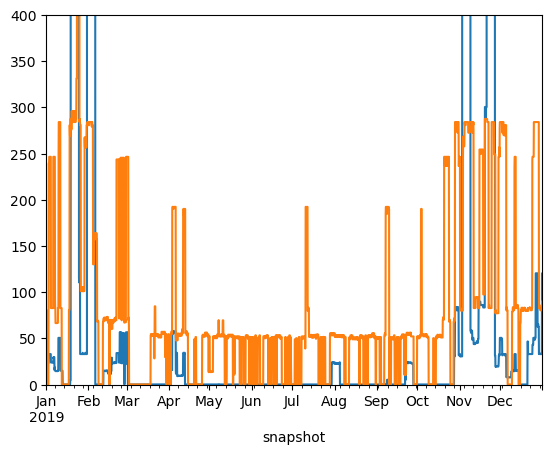

In [ ]:
networks[0].buses_t.marginal_price['DE0 0'].plot()
n_base.buses_t.marginal_price['DE0 0'].plot(
    ylim=(0,400),
    
)

In [7]:
#### Stochastic Network

n_stochastic = prepare_profit_optimization_network()

n_stochastic.optimize.optimize_with_rolling_horizon(
    solver_name = "gurobi",
    extra_functionality = change_obj(price_list),
    horizon = horizon,
    overlap = 0
)

INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
{'EU', 'DE'}
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/61).


2019-01-06 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dzu8c_ug.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dzu8c_ug.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x90bad05a


INFO:gurobipy:Model fingerprint: 0x90bad05a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [1e+01, 3e+01]


INFO:gurobipy:  Objective range  [1e+01, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    9.5742192e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    9.5742192e+07   1.112393e+07   0.000000e+00      0s


       9    1.8131835e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    1.8131835e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.813183459e+07


INFO:gurobipy:Optimal objective  1.813183459e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.81e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-07 00:00:00:2019-01-12 21:00:00] (2/61).


2019-01-12 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bxpwj8p6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bxpwj8p6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x337af209


INFO:gurobipy:Model fingerprint: 0x337af209


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 5e+01]


INFO:gurobipy:  Objective range  [6e-02, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    9.1632494e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    9.1632494e+07   1.112393e+07   0.000000e+00      0s


       8    2.3917284e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    2.3917284e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.391728411e+07


INFO:gurobipy:Optimal objective  2.391728411e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.39e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-13 00:00:00:2019-01-18 21:00:00] (3/61).


2019-01-18 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7nl515rs.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7nl515rs.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd55be305


INFO:gurobipy:Model fingerprint: 0xd55be305


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 5e+00]


INFO:gurobipy:  Objective range  [6e-02, 5e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.7856496e+06   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.7856496e+06   1.112393e+07   0.000000e+00      0s


      16    2.6574765e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      16    2.6574765e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 16 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 16 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.657476531e+06


INFO:gurobipy:Optimal objective  2.657476531e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.66e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-19 00:00:00:2019-01-24 21:00:00] (4/61).


2019-01-24 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6dnhmdqa.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6dnhmdqa.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x27948696


INFO:gurobipy:Model fingerprint: 0x27948696


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 2e+03]


INFO:gurobipy:  Objective range  [3e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.6906770e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.6906770e+09   1.112393e+07   0.000000e+00      0s


       8    2.3129268e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    2.3129268e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.312926774e+07


INFO:gurobipy:Optimal objective  2.312926774e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.31e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-25 00:00:00:2019-01-30 21:00:00] (5/61).


2019-01-30 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x4sy1kum.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x4sy1kum.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd1852743


INFO:gurobipy:Model fingerprint: 0xd1852743


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 1e+02]


INFO:gurobipy:  Objective range  [3e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.8877458e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.8877458e+08   1.112393e+07   0.000000e+00      0s


       1    6.2753833e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       1    6.2753833e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 1 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.275383309e+07


INFO:gurobipy:Optimal objective  6.275383309e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.28e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (6/61).


2019-02-05 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4thbavou.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4thbavou.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xfca401ff


INFO:gurobipy:Model fingerprint: 0xfca401ff


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [9e-02, 2e+03]


INFO:gurobipy:  Objective range  [9e-02, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.8677432e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.8677432e+09   1.112393e+07   0.000000e+00      0s


      12    2.8954670e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    2.8954670e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.895467043e+08


INFO:gurobipy:Optimal objective  2.895467043e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.90e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-06 00:00:00:2019-02-11 21:00:00] (7/61).


2019-02-11 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5ed3tmnl.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5ed3tmnl.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4523d682


INFO:gurobipy:Model fingerprint: 0x4523d682


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0496769e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0496769e+05   1.112393e+07   0.000000e+00      0s


      12    8.6281152e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    8.6281152e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.02 seconds (0.00 work units)


Optimal objective  8.628115170e+04


INFO:gurobipy:Optimal objective  8.628115170e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 8.63e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-12 00:00:00:2019-02-17 21:00:00] (8/61).


2019-02-17 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.14s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-484bq41x.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-484bq41x.lp


Reading time = 0.03 seconds


INFO:gurobipy:Reading time = 0.03 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb99e1e5e


INFO:gurobipy:Model fingerprint: 0xb99e1e5e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 3e+01]


INFO:gurobipy:  Objective range  [7e-02, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.9107714e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.9107714e+07   1.112393e+07   0.000000e+00      0s


       5    1.8657264e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    1.8657264e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.03 seconds (0.00 work units)


Optimal objective  1.865726362e+07


INFO:gurobipy:Optimal objective  1.865726362e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.87e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-18 00:00:00:2019-02-23 21:00:00] (9/61).


2019-02-23 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a8uhmr5v.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a8uhmr5v.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf2af7320


INFO:gurobipy:Model fingerprint: 0xf2af7320


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 3e+01]


INFO:gurobipy:  Objective range  [2e+01, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.1771519e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.1771519e+08   1.112393e+07   0.000000e+00      0s


       6    1.9273537e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    1.9273537e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.927353653e+07


INFO:gurobipy:Optimal objective  1.927353653e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.93e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-24 00:00:00:2019-03-01 21:00:00] (10/61).


2019-03-01 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-g26eee08.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-g26eee08.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xcec365ce


INFO:gurobipy:Model fingerprint: 0xcec365ce


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 6e+01]


INFO:gurobipy:  Objective range  [5e-02, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.6143240e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.6143240e+08   1.112393e+07   0.000000e+00      0s


       9    3.7484776e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    3.7484776e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.748477565e+07


INFO:gurobipy:Optimal objective  3.748477565e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.75e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (11/61).


2019-03-07 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5j07f9ux.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5j07f9ux.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x99271bbd


INFO:gurobipy:Model fingerprint: 0x99271bbd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2490405e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2490405e+05   1.112393e+07   0.000000e+00      0s


       7    4.6242486e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    4.6242486e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.624248552e+04


INFO:gurobipy:Optimal objective  4.624248552e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.62e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-08 00:00:00:2019-03-13 21:00:00] (12/61).


2019-03-13 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u67dm98m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u67dm98m.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x384a20cd


INFO:gurobipy:Model fingerprint: 0x384a20cd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2017393e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2017393e+05   1.112393e+07   0.000000e+00      0s


       7    3.9960761e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    3.9960761e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.996076095e+04


INFO:gurobipy:Optimal objective  3.996076095e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.00e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-14 00:00:00:2019-03-19 21:00:00] (13/61).


2019-03-19 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8pewobq7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8pewobq7.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd41a46f8


INFO:gurobipy:Model fingerprint: 0xd41a46f8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 2e-01]


INFO:gurobipy:  Objective range  [5e-02, 2e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3921724e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3921724e+05   1.112393e+07   0.000000e+00      0s


      11    5.3944194e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    5.3944194e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.394419382e+04


INFO:gurobipy:Optimal objective  5.394419382e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.39e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-20 00:00:00:2019-03-25 21:00:00] (14/61).


2019-03-25 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ah1cg4bx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ah1cg4bx.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4de972f0


INFO:gurobipy:Model fingerprint: 0x4de972f0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 2e-01]


INFO:gurobipy:  Objective range  [6e-02, 2e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.6165451e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.6165451e+05   1.112393e+07   0.000000e+00      0s


       4    1.2448735e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    1.2448735e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.244873535e+05


INFO:gurobipy:Optimal objective  1.244873535e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.24e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-26 00:00:00:2019-03-31 21:00:00] (15/61).


2019-03-31 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fk_out0a.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fk_out0a.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x7c16e27b


INFO:gurobipy:Model fingerprint: 0x7c16e27b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 2e-01]


INFO:gurobipy:  Objective range  [6e-02, 2e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.0727539e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.0727539e+05   1.112393e+07   0.000000e+00      0s


       9    1.1175838e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    1.1175838e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.03 seconds (0.00 work units)


Optimal objective  1.117583770e+05


INFO:gurobipy:Optimal objective  1.117583770e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.12e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (16/61).


2019-04-06 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yxtqw0wi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yxtqw0wi.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x27214dce


INFO:gurobipy:Model fingerprint: 0x27214dce


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 7e+01]


INFO:gurobipy:  Objective range  [7e-02, 7e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.5366716e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.5366716e+08   1.112393e+07   0.000000e+00      0s


      14    4.9550958e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      14    4.9550958e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 14 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 14 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.955095829e+07


INFO:gurobipy:Optimal objective  4.955095829e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.96e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-07 00:00:00:2019-04-12 21:00:00] (17/61).


2019-04-12 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1qrcj8l7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1qrcj8l7.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc26c8326


INFO:gurobipy:Model fingerprint: 0xc26c8326


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 4e+01]


INFO:gurobipy:  Objective range  [6e-02, 4e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.1345461e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.1345461e+07   1.112393e+07   0.000000e+00      0s


      11    1.9637492e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    1.9637492e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.963749244e+07


INFO:gurobipy:Optimal objective  1.963749244e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.96e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-13 00:00:00:2019-04-18 21:00:00] (18/61).


2019-04-18 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qj0uu7nb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qj0uu7nb.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x43c427f9


INFO:gurobipy:Model fingerprint: 0x43c427f9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2647886e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2647886e+05   1.112393e+07   0.000000e+00      0s


       3    4.6329957e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    4.6329957e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.632995688e+04


INFO:gurobipy:Optimal objective  4.632995688e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.63e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-19 00:00:00:2019-04-24 21:00:00] (19/61).


2019-04-24 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bx1ah2d7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bx1ah2d7.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf783a552


INFO:gurobipy:Model fingerprint: 0xf783a552


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.9657332e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.9657332e+05   1.112393e+07   0.000000e+00      0s


       7    5.2987338e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    5.2987338e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.298733766e+04


INFO:gurobipy:Optimal objective  5.298733766e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.30e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-25 00:00:00:2019-04-30 21:00:00] (20/61).


2019-04-30 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ve4yy7yu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ve4yy7yu.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x772f89f5


INFO:gurobipy:Model fingerprint: 0x772f89f5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.5501275e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.5501275e+05   1.112393e+07   0.000000e+00      0s


      12    7.3156461e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    7.3156461e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.03 seconds (0.00 work units)


Optimal objective  7.315646110e+04


INFO:gurobipy:Optimal objective  7.315646110e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.32e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (21/61).


2019-05-06 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4xmal3pg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4xmal3pg.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf206e3ac


INFO:gurobipy:Model fingerprint: 0xf206e3ac


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8371926e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8371926e+05   1.112393e+07   0.000000e+00      0s


      12    6.5385150e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    6.5385150e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.538514992e+04


INFO:gurobipy:Optimal objective  6.538514992e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.54e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-07 00:00:00:2019-05-12 21:00:00] (22/61).


2019-05-12 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xl2x5su0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xl2x5su0.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xaab10cf6


INFO:gurobipy:Model fingerprint: 0xaab10cf6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 2e-01]


INFO:gurobipy:  Objective range  [5e-02, 2e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.4459202e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.4459202e+05   1.112393e+07   0.000000e+00      0s


       3    8.9829720e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    8.9829720e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.03 seconds (0.00 work units)


Optimal objective  8.982972021e+04


INFO:gurobipy:Optimal objective  8.982972021e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 8.98e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-13 00:00:00:2019-05-18 21:00:00] (23/61).


2019-05-18 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rl6_vwev.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rl6_vwev.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x783f63a6


INFO:gurobipy:Model fingerprint: 0x783f63a6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0067381e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0067381e+05   1.112393e+07   0.000000e+00      0s


       6    6.2610214e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    6.2610214e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.261021446e+04


INFO:gurobipy:Optimal objective  6.261021446e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.26e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-19 00:00:00:2019-05-24 21:00:00] (24/61).


2019-05-24 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rva6kg5k.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rva6kg5k.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x636eb8a4


INFO:gurobipy:Model fingerprint: 0x636eb8a4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5957235e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5957235e+05   1.112393e+07   0.000000e+00      0s


       6    5.6473815e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.6473815e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.647381508e+04


INFO:gurobipy:Optimal objective  5.647381508e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.65e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-25 00:00:00:2019-05-30 21:00:00] (25/61).


2019-05-30 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cf7dsui6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cf7dsui6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4a0eb2ba


INFO:gurobipy:Model fingerprint: 0x4a0eb2ba


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5813879e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5813879e+05   1.112393e+07   0.000000e+00      0s


       4    5.6872560e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.6872560e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.687255967e+04


INFO:gurobipy:Optimal objective  5.687255967e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.69e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (26/61).


2019-06-05 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wxy1hpcy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wxy1hpcy.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x126da382


INFO:gurobipy:Model fingerprint: 0x126da382


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3656692e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3656692e+05   1.112393e+07   0.000000e+00      0s


       5    5.6736926e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    5.6736926e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.673692622e+04


INFO:gurobipy:Optimal objective  5.673692622e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.67e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-06 00:00:00:2019-06-11 21:00:00] (27/61).


2019-06-11 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m4ie1frz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m4ie1frz.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf7ca6e80


INFO:gurobipy:Model fingerprint: 0xf7ca6e80


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4127821e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4127821e+05   1.112393e+07   0.000000e+00      0s


       9    6.1415129e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    6.1415129e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.141512907e+04


INFO:gurobipy:Optimal objective  6.141512907e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.14e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-12 00:00:00:2019-06-17 21:00:00] (28/61).


2019-06-17 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uoisrwpp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uoisrwpp.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x40d3ddea


INFO:gurobipy:Model fingerprint: 0x40d3ddea


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6109892e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6109892e+05   1.112393e+07   0.000000e+00      0s


       7    5.5476409e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    5.5476409e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.547640868e+04


INFO:gurobipy:Optimal objective  5.547640868e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.55e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-18 00:00:00:2019-06-23 21:00:00] (29/61).


2019-06-23 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6_v_s3pk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6_v_s3pk.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb2b6e423


INFO:gurobipy:Model fingerprint: 0xb2b6e423


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 8e-02]


INFO:gurobipy:  Objective range  [4e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7912370e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.7912370e+05   1.112393e+07   0.000000e+00      0s


       5    6.2514783e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    6.2514783e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.251478342e+04


INFO:gurobipy:Optimal objective  6.251478342e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.25e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-24 00:00:00:2019-06-29 21:00:00] (30/61).


2019-06-29 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-22umq6e3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-22umq6e3.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x0e46977e


INFO:gurobipy:Model fingerprint: 0x0e46977e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1078484e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1078484e+05   1.112393e+07   0.000000e+00      0s


       6    5.0943854e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.0943854e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.094385373e+04


INFO:gurobipy:Optimal objective  5.094385373e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.09e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (31/61).


2019-07-05 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8z8jv4c8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8z8jv4c8.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x01e03b3f


INFO:gurobipy:Model fingerprint: 0x01e03b3f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1729778e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1729778e+05   1.112393e+07   0.000000e+00      0s


       4    5.9417968e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.9417968e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.941796809e+04


INFO:gurobipy:Optimal objective  5.941796809e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.94e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-06 00:00:00:2019-07-11 21:00:00] (32/61).


2019-07-11 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-l_m9nt8x.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-l_m9nt8x.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf7dbc6d9


INFO:gurobipy:Model fingerprint: 0xf7dbc6d9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0612642e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0612642e+05   1.112393e+07   0.000000e+00      0s


       7    7.8012977e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    7.8012977e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.801297713e+04


INFO:gurobipy:Optimal objective  7.801297713e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.80e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-12 00:00:00:2019-07-17 21:00:00] (33/61).


2019-07-17 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-l8i5wrnn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-l8i5wrnn.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x90df30ae


INFO:gurobipy:Model fingerprint: 0x90df30ae


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.4770629e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.4770629e+05   1.112393e+07   0.000000e+00      0s


       4    6.6952799e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    6.6952799e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.695279874e+04


INFO:gurobipy:Optimal objective  6.695279874e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.70e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-18 00:00:00:2019-07-23 21:00:00] (34/61).


2019-07-23 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tttivtrq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tttivtrq.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xa25431eb


INFO:gurobipy:Model fingerprint: 0xa25431eb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6957500e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6957500e+05   1.112393e+07   0.000000e+00      0s


       6    6.2829467e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    6.2829467e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.11 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.11 seconds (0.00 work units)


Optimal objective  6.282946704e+04


INFO:gurobipy:Optimal objective  6.282946704e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.28e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-24 00:00:00:2019-07-29 21:00:00] (35/61).


2019-07-29 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.16s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a3dxlbs0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a3dxlbs0.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x9ce5a650


INFO:gurobipy:Model fingerprint: 0x9ce5a650


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5424644e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5424644e+05   1.112393e+07   0.000000e+00      0s


       8    6.3253034e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    6.3253034e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.325303417e+04


INFO:gurobipy:Optimal objective  6.325303417e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.33e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (36/61).


2019-08-04 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-aejhwfkl.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-aejhwfkl.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x3088733d


INFO:gurobipy:Model fingerprint: 0x3088733d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 2e+01]


INFO:gurobipy:  Objective range  [6e-02, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    8.7411664e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    8.7411664e+07   1.112393e+07   0.000000e+00      0s


       6    6.0362152e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    6.0362152e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.036215214e+05


INFO:gurobipy:Optimal objective  6.036215214e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.04e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-05 00:00:00:2019-08-10 21:00:00] (37/61).


2019-08-10 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-th45u_xo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-th45u_xo.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x728b178a


INFO:gurobipy:Model fingerprint: 0x728b178a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5805130e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5805130e+05   1.112393e+07   0.000000e+00      0s


       3    5.6404442e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    5.6404442e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.640444170e+04


INFO:gurobipy:Optimal objective  5.640444170e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.64e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-11 00:00:00:2019-08-16 21:00:00] (38/61).


2019-08-16 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tqr1m5cp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tqr1m5cp.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x469b7c8d


INFO:gurobipy:Model fingerprint: 0x469b7c8d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5320473e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5320473e+05   1.112393e+07   0.000000e+00      0s


       6    5.5907521e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.5907521e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.590752066e+04


INFO:gurobipy:Optimal objective  5.590752066e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.59e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-17 00:00:00:2019-08-22 21:00:00] (39/61).


2019-08-22 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3fld2c1a.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3fld2c1a.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xef652e33


INFO:gurobipy:Model fingerprint: 0xef652e33


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7235598e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.7235598e+05   1.112393e+07   0.000000e+00      0s


       8    6.6601857e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    6.6601857e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.660185690e+04


INFO:gurobipy:Optimal objective  6.660185690e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.66e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-23 00:00:00:2019-08-28 21:00:00] (40/61).


2019-08-28 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7ocgghrp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7ocgghrp.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x3f519fe7


INFO:gurobipy:Model fingerprint: 0x3f519fe7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0465980e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0465980e+05   1.112393e+07   0.000000e+00      0s


       6    7.2884067e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    7.2884067e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.288406739e+04


INFO:gurobipy:Optimal objective  7.288406739e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.29e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (41/61).


2019-09-03 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9_v9yslw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9_v9yslw.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x882b28ed


INFO:gurobipy:Model fingerprint: 0x882b28ed


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9139352e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9139352e+05   1.112393e+07   0.000000e+00      0s


       4    7.0872191e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    7.0872191e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.087219079e+04


INFO:gurobipy:Optimal objective  7.087219079e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.09e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-04 00:00:00:2019-09-09 21:00:00] (42/61).


2019-09-09 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u84bqphv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u84bqphv.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xaa11f9a9


INFO:gurobipy:Model fingerprint: 0xaa11f9a9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 4e+01]


INFO:gurobipy:  Objective range  [5e-02, 4e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    4.7725457e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    4.7725457e+07   1.112393e+07   0.000000e+00      0s


       9    2.4364828e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    2.4364828e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.436482803e+07


INFO:gurobipy:Optimal objective  2.436482803e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.44e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-10 00:00:00:2019-09-15 21:00:00] (43/61).


2019-09-15 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n_hf_nxf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n_hf_nxf.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb28f1904


INFO:gurobipy:Model fingerprint: 0xb28f1904


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5107590e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5107590e+05   1.112393e+07   0.000000e+00      0s


       7    6.3057712e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    6.3057712e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.305771168e+04


INFO:gurobipy:Optimal objective  6.305771168e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.31e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-16 00:00:00:2019-09-21 21:00:00] (44/61).


2019-09-21 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-f8_40i7z.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-f8_40i7z.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb6c5cc6c


INFO:gurobipy:Model fingerprint: 0xb6c5cc6c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9197035e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9197035e+05   1.112393e+07   0.000000e+00      0s


       8    7.5727717e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    7.5727717e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.572771699e+04


INFO:gurobipy:Optimal objective  7.572771699e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.57e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-22 00:00:00:2019-09-27 21:00:00] (45/61).


2019-09-27 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yvfxip62.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yvfxip62.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe0d12663


INFO:gurobipy:Model fingerprint: 0xe0d12663


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 2e+01]


INFO:gurobipy:  Objective range  [5e-02, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    8.3652871e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    8.3652871e+07   1.112393e+07   0.000000e+00      0s


       6    4.6175126e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    4.6175126e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.617512648e+06


INFO:gurobipy:Optimal objective  4.617512648e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.62e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (46/61).


2019-10-03 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6n9lj4oq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6n9lj4oq.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x233bddd8


INFO:gurobipy:Model fingerprint: 0x233bddd8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4631539e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4631539e+05   1.112393e+07   0.000000e+00      0s


      10    5.2492281e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    5.2492281e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.249228057e+04


INFO:gurobipy:Optimal objective  5.249228057e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.25e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-04 00:00:00:2019-10-09 21:00:00] (47/61).


2019-10-09 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hm28cr8e.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hm28cr8e.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe97d8a6d


INFO:gurobipy:Model fingerprint: 0xe97d8a6d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9220994e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9220994e+05   1.112393e+07   0.000000e+00      0s


      10    5.1108703e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    5.1108703e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.110870298e+04


INFO:gurobipy:Optimal objective  5.110870298e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.11e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-10 00:00:00:2019-10-15 21:00:00] (48/61).


2019-10-15 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1iynwz7k.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1iynwz7k.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x7da9ee5c


INFO:gurobipy:Model fingerprint: 0x7da9ee5c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3322793e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3322793e+05   1.112393e+07   0.000000e+00      0s


       8    5.2320995e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    5.2320995e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.232099547e+04


INFO:gurobipy:Optimal objective  5.232099547e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.23e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-16 00:00:00:2019-10-21 21:00:00] (49/61).


2019-10-21 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r4e9b5c4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r4e9b5c4.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x94035d8b


INFO:gurobipy:Model fingerprint: 0x94035d8b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 2e+01]


INFO:gurobipy:  Objective range  [7e-02, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9133480e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9133480e+07   1.112393e+07   0.000000e+00      0s


       8    8.5830564e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    8.5830564e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  8.583056442e+06


INFO:gurobipy:Optimal objective  8.583056442e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 8.58e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-22 00:00:00:2019-10-27 21:00:00] (50/61).


2019-10-27 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pikhjgfp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pikhjgfp.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x41cae9c9


INFO:gurobipy:Model fingerprint: 0x41cae9c9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9376109e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9376109e+05   1.112393e+07   0.000000e+00      0s


      11    6.8870609e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    6.8870609e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.03 seconds (0.00 work units)


Optimal objective  6.887060850e+04


INFO:gurobipy:Optimal objective  6.887060850e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.89e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (51/61).


2019-11-02 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_ubb8qh2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_ubb8qh2.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xeb8529de


INFO:gurobipy:Model fingerprint: 0xeb8529de


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 9e+01]


INFO:gurobipy:  Objective range  [3e+01, 9e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3347557e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3347557e+08   1.112393e+07   0.000000e+00      0s


       9    5.7858733e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    5.7858733e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.785873323e+07


INFO:gurobipy:Optimal objective  5.785873323e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.79e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-03 00:00:00:2019-11-08 21:00:00] (52/61).


2019-11-08 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j5e87_dr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j5e87_dr.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xbdec7ca2


INFO:gurobipy:Model fingerprint: 0xbdec7ca2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e+01, 2e+03]


INFO:gurobipy:  Objective range  [6e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.1955394e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.1955394e+09   1.112393e+07   0.000000e+00      0s


       6    1.0101986e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    1.0101986e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.010198618e+08


INFO:gurobipy:Optimal objective  1.010198618e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.01e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-09 00:00:00:2019-11-14 21:00:00] (53/61).


2019-11-14 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k36ma6j2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k36ma6j2.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd6e5631c


INFO:gurobipy:Model fingerprint: 0xd6e5631c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e+01, 6e+01]


INFO:gurobipy:  Objective range  [4e+01, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.0690029e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.0690029e+08   1.112393e+07   0.000000e+00      0s


       8    4.1467274e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    4.1467274e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.01 seconds (0.00 work units)


Optimal objective  4.146727391e+07


INFO:gurobipy:Optimal objective  4.146727391e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.15e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-15 00:00:00:2019-11-20 21:00:00] (54/61).


2019-11-20 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ig0bb1kj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ig0bb1kj.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd5a35330


INFO:gurobipy:Model fingerprint: 0xd5a35330


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [8e+01, 3e+02]


INFO:gurobipy:  Objective range  [8e+01, 3e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.1367379e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.1367379e+08   1.112393e+07   0.000000e+00      0s


       3    2.0679600e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    2.0679600e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.067960011e+08


INFO:gurobipy:Optimal objective  2.067960011e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.07e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-21 00:00:00:2019-11-26 21:00:00] (55/61).


2019-11-26 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-efo4j_px.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-efo4j_px.lp


Reading time = 0.09 seconds


INFO:gurobipy:Reading time = 0.09 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x3ce24310


INFO:gurobipy:Model fingerprint: 0x3ce24310


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 2e+03]


INFO:gurobipy:  Objective range  [2e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.5002808e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.5002808e+09   1.112393e+07   0.000000e+00      0s


       5    1.0010583e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    1.0010583e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.01 seconds (0.00 work units)


Optimal objective  1.001058313e+09


INFO:gurobipy:Optimal objective  1.001058313e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.00e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (56/61).


2019-12-02 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_989438k.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_989438k.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe1a9f957


INFO:gurobipy:Model fingerprint: 0xe1a9f957


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 6e+01]


INFO:gurobipy:  Objective range  [2e+01, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.5344741e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.5344741e+08   1.112393e+07   0.000000e+00      0s


      11    3.2061431e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    3.2061431e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.01 seconds (0.00 work units)


Optimal objective  3.206143116e+07


INFO:gurobipy:Optimal objective  3.206143116e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.21e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-03 00:00:00:2019-12-08 21:00:00] (57/61).


2019-12-08 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-phfpx4mu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-phfpx4mu.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xffc440f4


INFO:gurobipy:Model fingerprint: 0xffc440f4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [8e+00, 3e+01]


INFO:gurobipy:  Objective range  [8e+00, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.2430784e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.2430784e+07   1.112393e+07   0.000000e+00      0s


       7    2.2401729e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    2.2401729e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.240172899e+07


INFO:gurobipy:Optimal objective  2.240172899e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.24e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-09 00:00:00:2019-12-14 21:00:00] (58/61).


2019-12-14 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lof5ceb0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lof5ceb0.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4d2db71c


INFO:gurobipy:Model fingerprint: 0x4d2db71c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 3e+01]


INFO:gurobipy:  Objective range  [6e-02, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.8391269e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.8391269e+07   1.112393e+07   0.000000e+00      0s


      10    1.0259229e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    1.0259229e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.025922868e+07


INFO:gurobipy:Optimal objective  1.025922868e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.03e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-15 00:00:00:2019-12-20 21:00:00] (59/61).


2019-12-20 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.14s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5w7qpuck.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5w7qpuck.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb02b6d38


INFO:gurobipy:Model fingerprint: 0xb02b6d38


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 8e-02]


INFO:gurobipy:  Objective range  [6e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7441880e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.7441880e+05   1.112393e+07   0.000000e+00      0s


       6    5.0819202e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.0819202e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.081920182e+04


INFO:gurobipy:Optimal objective  5.081920182e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.08e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-21 00:00:00:2019-12-26 21:00:00] (60/61).


2019-12-26 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p_udv6y4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p_udv6y4.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x7c0fa78e


INFO:gurobipy:Model fingerprint: 0x7c0fa78e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 5e+01]


INFO:gurobipy:  Objective range  [3e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.8428224e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.8428224e+08   1.112393e+07   0.000000e+00      0s


       6    3.6680590e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    3.6680590e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.668058962e+07


INFO:gurobipy:Optimal objective  3.668058962e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.67e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (61/61).


2019-12-31 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jvreod_8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jvreod_8.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1120 rows, 600 columns, 1960 nonzeros


INFO:gurobipy:obj: 1120 rows, 600 columns, 1960 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1120 rows, 600 columns and 1960 nonzeros


INFO:gurobipy:Optimize a model with 1120 rows, 600 columns and 1960 nonzeros


Model fingerprint: 0xe38994a4


INFO:gurobipy:Model fingerprint: 0xe38994a4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 1e+02]


INFO:gurobipy:  Objective range  [3e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1080 rows and 480 columns


INFO:gurobipy:Presolve removed 1080 rows and 480 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 40 rows, 120 columns, 160 nonzeros


INFO:gurobipy:Presolved: 40 rows, 120 columns, 160 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2001061e+08   4.765192e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.2001061e+08   4.765192e+06   0.000000e+00      0s


       7    5.7338011e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    5.7338011e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.733801125e+07


INFO:gurobipy:Optimal objective  5.733801125e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 600 primals, 1120 duals
Objective: 5.73e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


In [9]:
networks_profit_optimized = []

for i in range(0,3):
    n = prepare_profit_optimization_network()

    n.optimize.optimize_with_rolling_horizon(
        solver_name = "gurobi",
        extra_functionality = change_obj([price_list[i]]),
        horizon = horizon,
        overlap = 0,
    )

    networks_profit_optimized.append(n)

INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
{'EU', 'DE'}
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-06 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ji8ed98k.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ji8ed98k.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x40bbab35


INFO:gurobipy:Model fingerprint: 0x40bbab35


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [1e+01, 3e+01]


INFO:gurobipy:  Objective range  [1e+01, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.1109914e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.1109914e+08   1.112393e+07   0.000000e+00      0s


      11    1.5641177e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    1.5641177e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.12 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.12 seconds (0.00 work units)


Optimal objective  1.564117695e+07


INFO:gurobipy:Optimal objective  1.564117695e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.56e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-07 00:00:00:2019-01-12 21:00:00] (2/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-12 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4bbod06r.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4bbod06r.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xec71d719


INFO:gurobipy:Model fingerprint: 0xec71d719


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 5e+01]


INFO:gurobipy:  Objective range  [6e-02, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    9.0205199e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    9.0205199e+07   1.112393e+07   0.000000e+00      0s


      16    2.4636858e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      16    2.4636858e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 16 iterations and 0.17 seconds (0.00 work units)


INFO:gurobipy:Solved in 16 iterations and 0.17 seconds (0.00 work units)


Optimal objective  2.463685764e+07


INFO:gurobipy:Optimal objective  2.463685764e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.46e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-13 00:00:00:2019-01-18 21:00:00] (3/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-18 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-biezbyvm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-biezbyvm.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe34692e0


INFO:gurobipy:Model fingerprint: 0xe34692e0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 5e+00]


INFO:gurobipy:  Objective range  [6e-02, 5e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.09s


INFO:gurobipy:Presolve time: 0.09s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    4.9823886e+06   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    4.9823886e+06   1.112393e+07   0.000000e+00      0s


       7    3.4823131e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    3.4823131e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.11 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.11 seconds (0.00 work units)


Optimal objective  3.482313100e+06


INFO:gurobipy:Optimal objective  3.482313100e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.48e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-19 00:00:00:2019-01-24 21:00:00] (4/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-24 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ghi2l0o1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ghi2l0o1.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf065a3f9


INFO:gurobipy:Model fingerprint: 0xf065a3f9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 2e+03]


INFO:gurobipy:  Objective range  [3e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.7100285e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.7100285e+09   1.112393e+07   0.000000e+00      0s


      13    2.2738405e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    2.2738405e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.10 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.10 seconds (0.00 work units)


Optimal objective  2.273840549e+07


INFO:gurobipy:Optimal objective  2.273840549e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.27e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-25 00:00:00:2019-01-30 21:00:00] (5/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-30 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.1s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nzxz69zw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nzxz69zw.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xbf077861


INFO:gurobipy:Model fingerprint: 0xbf077861


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 1e+02]


INFO:gurobipy:  Objective range  [3e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.9252392e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.9252392e+08   1.112393e+07   0.000000e+00      0s


       4    6.6763701e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    6.6763701e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.676370109e+07


INFO:gurobipy:Optimal objective  6.676370109e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.68e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (6/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-05 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1qke1gxp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1qke1gxp.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x75c6c34a


INFO:gurobipy:Model fingerprint: 0x75c6c34a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 2e+03]


INFO:gurobipy:  Objective range  [7e-02, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.5310986e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.5310986e+09   1.112393e+07   0.000000e+00      0s


      14    4.5473699e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      14    4.5473699e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 14 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 14 iterations and 0.03 seconds (0.00 work units)


Optimal objective  4.547369945e+08


INFO:gurobipy:Optimal objective  4.547369945e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.55e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-06 00:00:00:2019-02-11 21:00:00] (7/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-11 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-b23ul8wf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-b23ul8wf.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe1fc00f3


INFO:gurobipy:Model fingerprint: 0xe1fc00f3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7174013e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.7174013e+05   1.112393e+07   0.000000e+00      0s


      15    5.9719204e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      15    5.9719204e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 15 iterations and 0.11 seconds (0.00 work units)


INFO:gurobipy:Solved in 15 iterations and 0.11 seconds (0.00 work units)


Optimal objective  5.971920366e+04


INFO:gurobipy:Optimal objective  5.971920366e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.97e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-12 00:00:00:2019-02-17 21:00:00] (8/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-17 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7x0q95s6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7x0q95s6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x2a5f7583


INFO:gurobipy:Model fingerprint: 0x2a5f7583


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 2e+01]


INFO:gurobipy:  Objective range  [7e-02, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.2856314e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.2856314e+07   1.112393e+07   0.000000e+00      0s


       5    1.3475572e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    1.3475572e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.03 seconds (0.00 work units)


Optimal objective  1.347557185e+07


INFO:gurobipy:Optimal objective  1.347557185e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.35e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-18 00:00:00:2019-02-23 21:00:00] (9/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-23 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-74wllqy1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-74wllqy1.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x94619291


INFO:gurobipy:Model fingerprint: 0x94619291


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 3e+01]


INFO:gurobipy:  Objective range  [2e+01, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.1886782e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.1886782e+08   1.112393e+07   0.000000e+00      0s


       7    1.9441033e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    1.9441033e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.04 seconds (0.00 work units)


Optimal objective  1.944103344e+07


INFO:gurobipy:Optimal objective  1.944103344e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.94e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-24 00:00:00:2019-03-01 21:00:00] (10/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-01 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hsqqltta.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hsqqltta.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xdfe37784


INFO:gurobipy:Model fingerprint: 0xdfe37784


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 6e+01]


INFO:gurobipy:  Objective range  [5e-02, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.6408433e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.6408433e+08   1.112393e+07   0.000000e+00      0s


      18    4.0891665e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      18    4.0891665e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 18 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 18 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.089166469e+07


INFO:gurobipy:Optimal objective  4.089166469e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.09e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (11/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-07 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-09k4q4g2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-09k4q4g2.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x30f92e16


INFO:gurobipy:Model fingerprint: 0x30f92e16


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2540833e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2540833e+05   1.112393e+07   0.000000e+00      0s


      17    4.7260136e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      17    4.7260136e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 17 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.726013602e+04


INFO:gurobipy:Optimal objective  4.726013602e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.73e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-08 00:00:00:2019-03-13 21:00:00] (12/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-13 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y25ecxdy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y25ecxdy.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xa38a3dc4


INFO:gurobipy:Model fingerprint: 0xa38a3dc4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1959348e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1959348e+05   1.112393e+07   0.000000e+00      0s


      16    4.0278318e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      16    4.0278318e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 16 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 16 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.027831845e+04


INFO:gurobipy:Optimal objective  4.027831845e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.03e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-14 00:00:00:2019-03-19 21:00:00] (13/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-19 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-17zjk015.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-17zjk015.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x7e4758a6


INFO:gurobipy:Model fingerprint: 0x7e4758a6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3039014e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3039014e+05   1.112393e+07   0.000000e+00      0s


      18    4.6407853e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      18    4.6407853e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 18 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 18 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.640785301e+04


INFO:gurobipy:Optimal objective  4.640785301e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.64e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-20 00:00:00:2019-03-25 21:00:00] (14/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-25 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7zytp1ew.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7zytp1ew.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x13b1b06d


INFO:gurobipy:Model fingerprint: 0x13b1b06d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 1e-01]


INFO:gurobipy:  Objective range  [6e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.2550016e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.2550016e+05   1.112393e+07   0.000000e+00      0s


       4    8.8853356e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    8.8853356e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  8.885335575e+04


INFO:gurobipy:Optimal objective  8.885335575e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 8.89e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-26 00:00:00:2019-03-31 21:00:00] (15/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-31 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jlim2sdo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jlim2sdo.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x25dbd0b2


INFO:gurobipy:Model fingerprint: 0x25dbd0b2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 2e-01]


INFO:gurobipy:  Objective range  [6e-02, 2e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.5459616e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.5459616e+05   1.112393e+07   0.000000e+00      0s


       9    1.1293131e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    1.1293131e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.129313058e+05


INFO:gurobipy:Optimal objective  1.129313058e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.13e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (16/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-06 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8j52qudn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8j52qudn.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x53a76ab1


INFO:gurobipy:Model fingerprint: 0x53a76ab1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 6e+01]


INFO:gurobipy:  Objective range  [7e-02, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.2543821e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.2543821e+08   1.112393e+07   0.000000e+00      0s


       9    3.9495102e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    3.9495102e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.949510248e+07


INFO:gurobipy:Optimal objective  3.949510248e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.95e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-07 00:00:00:2019-04-12 21:00:00] (17/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-12 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-siqemoor.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-siqemoor.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd96cf6dc


INFO:gurobipy:Model fingerprint: 0xd96cf6dc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 4e+01]


INFO:gurobipy:  Objective range  [6e-02, 4e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.0866019e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.0866019e+07   1.112393e+07   0.000000e+00      0s


       9    1.7037076e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    1.7037076e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.703707560e+07


INFO:gurobipy:Optimal objective  1.703707560e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.70e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-13 00:00:00:2019-04-18 21:00:00] (18/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-18 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7m8gcnvb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7m8gcnvb.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x32ebc754


INFO:gurobipy:Model fingerprint: 0x32ebc754


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2618431e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2618431e+05   1.112393e+07   0.000000e+00      0s


       4    4.7829517e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    4.7829517e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.782951662e+04


INFO:gurobipy:Optimal objective  4.782951662e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.78e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-19 00:00:00:2019-04-24 21:00:00] (19/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-24 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-iac38svp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-iac38svp.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd625f0c0


INFO:gurobipy:Model fingerprint: 0xd625f0c0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.0006752e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.0006752e+05   1.112393e+07   0.000000e+00      0s


       5    5.7815311e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    5.7815311e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.781531116e+04


INFO:gurobipy:Optimal objective  5.781531116e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.78e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-25 00:00:00:2019-04-30 21:00:00] (20/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-30 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e7kdn_5l.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e7kdn_5l.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8b8e51b8


INFO:gurobipy:Model fingerprint: 0x8b8e51b8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.5368819e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.5368819e+05   1.112393e+07   0.000000e+00      0s


      12    7.3253317e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    7.3253317e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.325331700e+04


INFO:gurobipy:Optimal objective  7.325331700e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.33e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (21/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-06 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.13s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zf_g3fvo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zf_g3fvo.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x7dd6b146


INFO:gurobipy:Model fingerprint: 0x7dd6b146


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8346862e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8346862e+05   1.112393e+07   0.000000e+00      0s


      13    6.5635435e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    6.5635435e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.563543482e+04


INFO:gurobipy:Optimal objective  6.563543482e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.56e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-07 00:00:00:2019-05-12 21:00:00] (22/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-12 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7j9uh_mn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7j9uh_mn.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x952193ee


INFO:gurobipy:Model fingerprint: 0x952193ee


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 3e-01]


INFO:gurobipy:  Objective range  [5e-02, 3e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.8154080e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.8154080e+05   1.112393e+07   0.000000e+00      0s


       6    1.2475826e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    1.2475826e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.03 seconds (0.00 work units)


Optimal objective  1.247582588e+05


INFO:gurobipy:Optimal objective  1.247582588e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.25e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-13 00:00:00:2019-05-18 21:00:00] (23/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-18 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3i_qlrxk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3i_qlrxk.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xccf92872


INFO:gurobipy:Model fingerprint: 0xccf92872


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0085497e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0085497e+05   1.112393e+07   0.000000e+00      0s


       4    6.3712831e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    6.3712831e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.371283137e+04


INFO:gurobipy:Optimal objective  6.371283137e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.37e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-19 00:00:00:2019-05-24 21:00:00] (24/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-24 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uulqzjc5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uulqzjc5.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb88aa2bc


INFO:gurobipy:Model fingerprint: 0xb88aa2bc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6021768e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6021768e+05   1.112393e+07   0.000000e+00      0s


       5    5.5905650e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    5.5905650e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.590564973e+04


INFO:gurobipy:Optimal objective  5.590564973e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.59e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-25 00:00:00:2019-05-30 21:00:00] (25/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-30 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-urwhia1z.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-urwhia1z.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x941a8deb


INFO:gurobipy:Model fingerprint: 0x941a8deb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5891069e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5891069e+05   1.112393e+07   0.000000e+00      0s


       7    5.7789231e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    5.7789231e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.778923093e+04


INFO:gurobipy:Optimal objective  5.778923093e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.78e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (26/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-05 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pygg44k8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pygg44k8.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4e28011d


INFO:gurobipy:Model fingerprint: 0x4e28011d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3613567e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3613567e+05   1.112393e+07   0.000000e+00      0s


       3    5.7172917e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    5.7172917e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.06 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.06 seconds (0.00 work units)


Optimal objective  5.717291654e+04


INFO:gurobipy:Optimal objective  5.717291654e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.72e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-06 00:00:00:2019-06-11 21:00:00] (27/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-11 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wa6zv30u.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wa6zv30u.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x682c81ca


INFO:gurobipy:Model fingerprint: 0x682c81ca


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3643353e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3643353e+05   1.112393e+07   0.000000e+00      0s


       8    6.2491552e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    6.2491552e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.12 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.12 seconds (0.00 work units)


Optimal objective  6.249155152e+04


INFO:gurobipy:Optimal objective  6.249155152e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.25e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-12 00:00:00:2019-06-17 21:00:00] (28/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-17 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4831v0ie.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4831v0ie.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb1cb8345


INFO:gurobipy:Model fingerprint: 0xb1cb8345


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6107264e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6107264e+05   1.112393e+07   0.000000e+00      0s


       6    5.4897863e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.4897863e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.489786276e+04


INFO:gurobipy:Optimal objective  5.489786276e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.49e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-18 00:00:00:2019-06-23 21:00:00] (29/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-23 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-z6tidxk4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-z6tidxk4.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x31dff310


INFO:gurobipy:Model fingerprint: 0x31dff310


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 8e-02]


INFO:gurobipy:  Objective range  [4e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7450532e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.7450532e+05   1.112393e+07   0.000000e+00      0s


       5    6.2071130e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    6.2071130e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.207113012e+04


INFO:gurobipy:Optimal objective  6.207113012e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.21e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-24 00:00:00:2019-06-29 21:00:00] (30/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-29 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-iykt5tmp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-iykt5tmp.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x76b60016


INFO:gurobipy:Model fingerprint: 0x76b60016


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.0985097e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.0985097e+05   1.112393e+07   0.000000e+00      0s


       6    5.0146059e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.0146059e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.014605889e+04


INFO:gurobipy:Optimal objective  5.014605889e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.01e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (31/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-05 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-skq45j3b.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-skq45j3b.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xaa7ec4a3


INFO:gurobipy:Model fingerprint: 0xaa7ec4a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1762120e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1762120e+05   1.112393e+07   0.000000e+00      0s


       4    5.9199168e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.9199168e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.919916773e+04


INFO:gurobipy:Optimal objective  5.919916773e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.92e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-06 00:00:00:2019-07-11 21:00:00] (32/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-11 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cb28h1sx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cb28h1sx.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xdaf5c943


INFO:gurobipy:Model fingerprint: 0xdaf5c943


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0993927e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0993927e+05   1.112393e+07   0.000000e+00      0s


       9    7.9323648e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    7.9323648e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.932364842e+04


INFO:gurobipy:Optimal objective  7.932364842e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.93e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-12 00:00:00:2019-07-17 21:00:00] (33/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-17 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yxe75708.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yxe75708.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf7069fd7


INFO:gurobipy:Model fingerprint: 0xf7069fd7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.4830766e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.4830766e+05   1.112393e+07   0.000000e+00      0s


       4    6.5701492e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    6.5701492e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.570149184e+04


INFO:gurobipy:Optimal objective  6.570149184e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.57e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-18 00:00:00:2019-07-23 21:00:00] (34/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-23 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3kwtb8m5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3kwtb8m5.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x54bd9d2e


INFO:gurobipy:Model fingerprint: 0x54bd9d2e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6824701e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6824701e+05   1.112393e+07   0.000000e+00      0s


       5    6.3813614e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    6.3813614e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.381361354e+04


INFO:gurobipy:Optimal objective  6.381361354e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.38e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-24 00:00:00:2019-07-29 21:00:00] (35/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-29 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ciy48n6l.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ciy48n6l.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8c122a8a


INFO:gurobipy:Model fingerprint: 0x8c122a8a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5391744e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5391744e+05   1.112393e+07   0.000000e+00      0s


       8    6.3512226e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    6.3512226e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.351222602e+04


INFO:gurobipy:Optimal objective  6.351222602e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.35e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (36/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-04 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ugl3kj3p.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ugl3kj3p.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x57842ca9


INFO:gurobipy:Model fingerprint: 0x57842ca9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 2e+01]


INFO:gurobipy:  Objective range  [5e-02, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    8.7404401e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    8.7404401e+07   1.112393e+07   0.000000e+00      0s


       6    5.9894200e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.9894200e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.09 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.09 seconds (0.00 work units)


Optimal objective  5.989419991e+05


INFO:gurobipy:Optimal objective  5.989419991e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.99e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-05 00:00:00:2019-08-10 21:00:00] (37/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-10 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k3fehdd5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k3fehdd5.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe4cf90b8


INFO:gurobipy:Model fingerprint: 0xe4cf90b8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5764578e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5764578e+05   1.112393e+07   0.000000e+00      0s


       4    5.7171061e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.7171061e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.01 seconds (0.00 work units)


Optimal objective  5.717106101e+04


INFO:gurobipy:Optimal objective  5.717106101e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.72e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-11 00:00:00:2019-08-16 21:00:00] (38/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-16 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-40mbdkju.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-40mbdkju.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xdbbfe1b8


INFO:gurobipy:Model fingerprint: 0xdbbfe1b8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5423796e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5423796e+05   1.112393e+07   0.000000e+00      0s


       6    5.8028033e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.8028033e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.802803340e+04


INFO:gurobipy:Optimal objective  5.802803340e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.80e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-17 00:00:00:2019-08-22 21:00:00] (39/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-22 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fa7t11zu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fa7t11zu.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x82c79338


INFO:gurobipy:Model fingerprint: 0x82c79338


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8069568e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8069568e+05   1.112393e+07   0.000000e+00      0s


       7    6.7274706e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    6.7274706e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.727470555e+04


INFO:gurobipy:Optimal objective  6.727470555e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.73e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-23 00:00:00:2019-08-28 21:00:00] (40/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-28 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.09s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zyodkn8n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zyodkn8n.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe758fa73


INFO:gurobipy:Model fingerprint: 0xe758fa73


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0576216e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0576216e+05   1.112393e+07   0.000000e+00      0s


       7    7.3478915e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    7.3478915e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.06 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.06 seconds (0.00 work units)


Optimal objective  7.347891510e+04


INFO:gurobipy:Optimal objective  7.347891510e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.35e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (41/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-03 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3146sthc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3146sthc.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x33dcf2e2


INFO:gurobipy:Model fingerprint: 0x33dcf2e2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9223675e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9223675e+05   1.112393e+07   0.000000e+00      0s


       4    7.0083338e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    7.0083338e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.008333770e+04


INFO:gurobipy:Optimal objective  7.008333770e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.01e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-04 00:00:00:2019-09-09 21:00:00] (42/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-09 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hxhyeo9f.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hxhyeo9f.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6271a3e0


INFO:gurobipy:Model fingerprint: 0x6271a3e0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 5e+00]


INFO:gurobipy:  Objective range  [5e-02, 5e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.6769262e+06   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.6769262e+06   1.112393e+07   0.000000e+00      0s


      10    3.5335864e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    3.5335864e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.533586387e+06


INFO:gurobipy:Optimal objective  3.533586387e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.53e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-10 00:00:00:2019-09-15 21:00:00] (43/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-15 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3ah0z0qo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3ah0z0qo.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4b7f58e7


INFO:gurobipy:Model fingerprint: 0x4b7f58e7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5783377e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5783377e+05   1.112393e+07   0.000000e+00      0s


       5    6.7499192e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    6.7499192e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.749919194e+04


INFO:gurobipy:Optimal objective  6.749919194e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.75e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-16 00:00:00:2019-09-21 21:00:00] (44/61).


2019-09-21 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ed5rfd0d.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ed5rfd0d.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8aa97f6b


INFO:gurobipy:Model fingerprint: 0x8aa97f6b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9333738e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9333738e+05   1.112393e+07   0.000000e+00      0s


       7    7.7425314e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    7.7425314e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.01 seconds (0.00 work units)


Optimal objective  7.742531385e+04


INFO:gurobipy:Optimal objective  7.742531385e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.74e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-22 00:00:00:2019-09-27 21:00:00] (45/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-27 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4wiblbln.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4wiblbln.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xa7154e28


INFO:gurobipy:Model fingerprint: 0xa7154e28


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 2e+01]


INFO:gurobipy:  Objective range  [5e-02, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    8.4362548e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    8.4362548e+07   1.112393e+07   0.000000e+00      0s


      10    4.6213770e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    4.6213770e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.621377005e+06


INFO:gurobipy:Optimal objective  4.621377005e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.62e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (46/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-03 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_2vnkfw4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_2vnkfw4.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb3a126c1


INFO:gurobipy:Model fingerprint: 0xb3a126c1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5019680e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5019680e+05   1.112393e+07   0.000000e+00      0s


       8    5.7368947e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    5.7368947e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.736894678e+04


INFO:gurobipy:Optimal objective  5.736894678e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.74e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-04 00:00:00:2019-10-09 21:00:00] (47/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-09 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1sqyo8rl.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1sqyo8rl.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x78203455


INFO:gurobipy:Model fingerprint: 0x78203455


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9244838e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9244838e+05   1.112393e+07   0.000000e+00      0s


       4    5.4305433e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.4305433e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.430543337e+04


INFO:gurobipy:Optimal objective  5.430543337e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.43e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-10 00:00:00:2019-10-15 21:00:00] (48/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-15 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-d8em4swx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-d8em4swx.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x9765f101


INFO:gurobipy:Model fingerprint: 0x9765f101


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3627178e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3627178e+05   1.112393e+07   0.000000e+00      0s


      11    5.3518417e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    5.3518417e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.351841671e+04


INFO:gurobipy:Optimal objective  5.351841671e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.35e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-16 00:00:00:2019-10-21 21:00:00] (49/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-21 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nmth50f1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nmth50f1.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x9dc75b15


INFO:gurobipy:Model fingerprint: 0x9dc75b15


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 9e-02]


INFO:gurobipy:  Objective range  [7e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.2928667e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.2928667e+05   1.112393e+07   0.000000e+00      0s


       9    5.6051244e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    5.6051244e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.605124368e+04


INFO:gurobipy:Optimal objective  5.605124368e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.61e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-22 00:00:00:2019-10-27 21:00:00] (50/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-27 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.13s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mupo256j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mupo256j.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4f6a49df


INFO:gurobipy:Model fingerprint: 0x4f6a49df


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9741755e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9741755e+05   1.112393e+07   0.000000e+00      0s


      13    7.1847834e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    7.1847834e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.184783368e+04


INFO:gurobipy:Optimal objective  7.184783368e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.18e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (51/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-02 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ngw0e1ov.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ngw0e1ov.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd51eb1d2


INFO:gurobipy:Model fingerprint: 0xd51eb1d2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 9e+01]


INFO:gurobipy:  Objective range  [3e+01, 9e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2818342e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2818342e+08   1.112393e+07   0.000000e+00      0s


       7    5.6828965e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    5.6828965e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.682896487e+07


INFO:gurobipy:Optimal objective  5.682896487e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.68e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-03 00:00:00:2019-11-08 21:00:00] (52/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-08 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.12s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nc_ny575.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nc_ny575.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x361af406


INFO:gurobipy:Model fingerprint: 0x361af406


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e+01, 2e+03]


INFO:gurobipy:  Objective range  [6e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.7327850e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.7327850e+09   1.112393e+07   0.000000e+00      0s


      16    2.2381282e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      16    2.2381282e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 16 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 16 iterations and 0.01 seconds (0.00 work units)


Optimal objective  2.238128214e+08


INFO:gurobipy:Optimal objective  2.238128214e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.24e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-09 00:00:00:2019-11-14 21:00:00] (53/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-14 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a88u27si.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a88u27si.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x11740349


INFO:gurobipy:Model fingerprint: 0x11740349


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e+01, 6e+01]


INFO:gurobipy:  Objective range  [4e+01, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1908781e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1908781e+08   1.112393e+07   0.000000e+00      0s


      10    4.2701909e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    4.2701909e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.270190937e+07


INFO:gurobipy:Optimal objective  4.270190937e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.27e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-15 00:00:00:2019-11-20 21:00:00] (54/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-20 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ndundo8q.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ndundo8q.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xcf09922b


INFO:gurobipy:Model fingerprint: 0xcf09922b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [8e+01, 3e+02]


INFO:gurobipy:  Objective range  [8e+01, 3e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.1652313e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.1652313e+08   1.112393e+07   0.000000e+00      0s


      10    2.0797275e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    2.0797275e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.079727502e+08


INFO:gurobipy:Optimal objective  2.079727502e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.08e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-21 00:00:00:2019-11-26 21:00:00] (55/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-26 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kd_5ryt4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kd_5ryt4.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd713016f


INFO:gurobipy:Model fingerprint: 0xd713016f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 2e+03]


INFO:gurobipy:  Objective range  [2e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.4875694e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.4875694e+09   1.112393e+07   0.000000e+00      0s


      12    1.0038880e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    1.0038880e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.003887984e+09


INFO:gurobipy:Optimal objective  1.003887984e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.00e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (56/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-02 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_cmv99ru.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_cmv99ru.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4da4604b


INFO:gurobipy:Model fingerprint: 0x4da4604b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 5e+01]


INFO:gurobipy:  Objective range  [2e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.4399174e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.4399174e+08   1.112393e+07   0.000000e+00      0s


      13    3.1603814e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    3.1603814e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.160381403e+07


INFO:gurobipy:Optimal objective  3.160381403e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.16e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-03 00:00:00:2019-12-08 21:00:00] (57/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-08 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jd6ttxhi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jd6ttxhi.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4b7ac39c


INFO:gurobipy:Model fingerprint: 0x4b7ac39c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [8e+00, 3e+01]


INFO:gurobipy:  Objective range  [8e+00, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.2168866e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.2168866e+07   1.112393e+07   0.000000e+00      0s


       8    2.2352324e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    2.2352324e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.235232421e+07


INFO:gurobipy:Optimal objective  2.235232421e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.24e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-09 00:00:00:2019-12-14 21:00:00] (58/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-14 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kq8awctt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kq8awctt.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x7090fb3e


INFO:gurobipy:Model fingerprint: 0x7090fb3e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 3e+01]


INFO:gurobipy:  Objective range  [5e-02, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.7000697e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.7000697e+07   1.112393e+07   0.000000e+00      0s


       9    1.1604673e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    1.1604673e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.160467348e+07


INFO:gurobipy:Optimal objective  1.160467348e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.16e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-15 00:00:00:2019-12-20 21:00:00] (59/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-20 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r_m7emav.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r_m7emav.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x18893fc9


INFO:gurobipy:Model fingerprint: 0x18893fc9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6561328e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6561328e+05   1.112393e+07   0.000000e+00      0s


       8    5.0284199e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    5.0284199e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.028419930e+04


INFO:gurobipy:Optimal objective  5.028419930e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.03e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-21 00:00:00:2019-12-26 21:00:00] (60/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-26 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mim7nop_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mim7nop_.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd910a25a


INFO:gurobipy:Model fingerprint: 0xd910a25a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 5e+01]


INFO:gurobipy:  Objective range  [3e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.8587301e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.8587301e+08   1.112393e+07   0.000000e+00      0s


       9    3.7705615e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    3.7705615e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.770561539e+07


INFO:gurobipy:Optimal objective  3.770561539e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.77e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (61/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-31 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-iuhfglx7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-iuhfglx7.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1120 rows, 600 columns, 1960 nonzeros


INFO:gurobipy:obj: 1120 rows, 600 columns, 1960 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1120 rows, 600 columns and 1960 nonzeros


INFO:gurobipy:Optimize a model with 1120 rows, 600 columns and 1960 nonzeros


Model fingerprint: 0xe78da2df


INFO:gurobipy:Model fingerprint: 0xe78da2df


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 1e+02]


INFO:gurobipy:  Objective range  [3e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1080 rows and 480 columns


INFO:gurobipy:Presolve removed 1080 rows and 480 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 40 rows, 120 columns, 160 nonzeros


INFO:gurobipy:Presolved: 40 rows, 120 columns, 160 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1997194e+08   4.765192e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.1997194e+08   4.765192e+06   0.000000e+00      0s


      10    5.9324605e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    5.9324605e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.932460534e+07


INFO:gurobipy:Optimal objective  5.932460534e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 600 primals, 1120 duals
Objective: 5.93e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
{'EU', 'DE'}
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-06 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r9o3a_8g.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r9o3a_8g.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xa57c3bf1


INFO:gurobipy:Model fingerprint: 0xa57c3bf1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [1e+01, 3e+01]


INFO:gurobipy:  Objective range  [1e+01, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.6779616e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.6779616e+07   1.112393e+07   0.000000e+00      0s


      12    2.2846025e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    2.2846025e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.284602534e+07


INFO:gurobipy:Optimal objective  2.284602534e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.28e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-07 00:00:00:2019-01-12 21:00:00] (2/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-12 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8bfb6rkd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8bfb6rkd.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x3db07a64


INFO:gurobipy:Model fingerprint: 0x3db07a64


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 5e+01]


INFO:gurobipy:  Objective range  [5e-02, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    9.2233402e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    9.2233402e+07   1.112393e+07   0.000000e+00      0s


      13    2.3116294e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    2.3116294e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.311629441e+07


INFO:gurobipy:Optimal objective  2.311629441e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.31e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-13 00:00:00:2019-01-18 21:00:00] (3/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-18 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-w2s60oe5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-w2s60oe5.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xee39b973


INFO:gurobipy:Model fingerprint: 0xee39b973


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 5e+00]


INFO:gurobipy:  Objective range  [5e-02, 5e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.3603527e+06   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.3603527e+06   1.112393e+07   0.000000e+00      0s


      12    1.0251307e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    1.0251307e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.025130685e+06


INFO:gurobipy:Optimal objective  1.025130685e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.03e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-19 00:00:00:2019-01-24 21:00:00] (4/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-24 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-q4sgv0d2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-q4sgv0d2.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xeee18ce4


INFO:gurobipy:Model fingerprint: 0xeee18ce4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 2e+03]


INFO:gurobipy:  Objective range  [3e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.6610414e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.6610414e+09   1.112393e+07   0.000000e+00      0s


       8    2.2721575e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    2.2721575e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.272157548e+07


INFO:gurobipy:Optimal objective  2.272157548e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.27e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-25 00:00:00:2019-01-30 21:00:00] (5/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-30 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-h_yyte5q.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-h_yyte5q.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x2ca782dc


INFO:gurobipy:Model fingerprint: 0x2ca782dc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 1e+02]


INFO:gurobipy:  Objective range  [3e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.8906826e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.8906826e+08   1.112393e+07   0.000000e+00      0s


       4    6.3353743e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    6.3353743e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.335374342e+07


INFO:gurobipy:Optimal objective  6.335374342e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.34e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (6/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-05 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9o30ypc9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9o30ypc9.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4b6182c1


INFO:gurobipy:Model fingerprint: 0x4b6182c1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [1e-01, 2e+03]


INFO:gurobipy:  Objective range  [1e-01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.3648051e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.3648051e+09   1.112393e+07   0.000000e+00      0s


       4    4.4122367e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    4.4122367e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.412236735e+07


INFO:gurobipy:Optimal objective  4.412236735e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.41e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-06 00:00:00:2019-02-11 21:00:00] (7/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-11 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bif4k59t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bif4k59t.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8a920941


INFO:gurobipy:Model fingerprint: 0x8a920941


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.5298979e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.5298979e+05   1.112393e+07   0.000000e+00      0s


      19    1.2854832e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      19    1.2854832e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 19 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 19 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.285483234e+05


INFO:gurobipy:Optimal objective  1.285483234e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.29e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-12 00:00:00:2019-02-17 21:00:00] (8/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-17 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-w_px4zwh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-w_px4zwh.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xaa74f172


INFO:gurobipy:Model fingerprint: 0xaa74f172


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 3e+01]


INFO:gurobipy:  Objective range  [7e-02, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.2385442e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.2385442e+07   1.112393e+07   0.000000e+00      0s


       8    2.1454526e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    2.1454526e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.145452586e+07


INFO:gurobipy:Optimal objective  2.145452586e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.15e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-18 00:00:00:2019-02-23 21:00:00] (9/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-23 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3ymiszx2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3ymiszx2.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe07028c6


INFO:gurobipy:Model fingerprint: 0xe07028c6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 3e+01]


INFO:gurobipy:  Objective range  [2e+01, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.1820730e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.1820730e+08   1.112393e+07   0.000000e+00      0s


       7    1.8948597e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    1.8948597e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.894859734e+07


INFO:gurobipy:Optimal objective  1.894859734e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.89e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-24 00:00:00:2019-03-01 21:00:00] (10/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-01 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.14s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-70t0r9h4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-70t0r9h4.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc60c9ddc


INFO:gurobipy:Model fingerprint: 0xc60c9ddc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 6e+01]


INFO:gurobipy:  Objective range  [5e-02, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.6219825e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.6219825e+08   1.112393e+07   0.000000e+00      0s


       6    3.7308456e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    3.7308456e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.730845638e+07


INFO:gurobipy:Optimal objective  3.730845638e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.73e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (11/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-07 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-b8b6wv1c.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-b8b6wv1c.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6f40a2b5


INFO:gurobipy:Model fingerprint: 0x6f40a2b5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2504964e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2504964e+05   1.112393e+07   0.000000e+00      0s


       9    4.6741205e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    4.6741205e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.674120515e+04


INFO:gurobipy:Optimal objective  4.674120515e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.67e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-08 00:00:00:2019-03-13 21:00:00] (12/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-13 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-h_8ysx3e.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-h_8ysx3e.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4c5d4014


INFO:gurobipy:Model fingerprint: 0x4c5d4014


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1970712e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1970712e+05   1.112393e+07   0.000000e+00      0s


      11    4.0157319e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    4.0157319e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.015731880e+04


INFO:gurobipy:Optimal objective  4.015731880e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.02e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-14 00:00:00:2019-03-19 21:00:00] (13/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-19 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cagvcrwy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cagvcrwy.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x67671360


INFO:gurobipy:Model fingerprint: 0x67671360


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2854945e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2854945e+05   1.112393e+07   0.000000e+00      0s


      24    4.5634117e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      24    4.5634117e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 24 iterations and 0.07 seconds (0.00 work units)


INFO:gurobipy:Solved in 24 iterations and 0.07 seconds (0.00 work units)


Optimal objective  4.563411666e+04


INFO:gurobipy:Optimal objective  4.563411666e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.56e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-20 00:00:00:2019-03-25 21:00:00] (14/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-25 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_83q3gzk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_83q3gzk.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4d8ea4a4


INFO:gurobipy:Model fingerprint: 0x4d8ea4a4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 1e-01]


INFO:gurobipy:  Objective range  [6e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.1984176e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.1984176e+05   1.112393e+07   0.000000e+00      0s


       4    8.2968400e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    8.2968400e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  8.296839993e+04


INFO:gurobipy:Optimal objective  8.296839993e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 8.30e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-26 00:00:00:2019-03-31 21:00:00] (15/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-31 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t_tq7jru.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t_tq7jru.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x0ae69706


INFO:gurobipy:Model fingerprint: 0x0ae69706


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 1e-01]


INFO:gurobipy:  Objective range  [6e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    4.2964729e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    4.2964729e+05   1.112393e+07   0.000000e+00      0s


       8    1.0099888e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    1.0099888e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.009988842e+05


INFO:gurobipy:Optimal objective  1.009988842e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.01e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (16/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-06 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.15s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qr8k4072.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qr8k4072.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x2f9d91e5


INFO:gurobipy:Model fingerprint: 0x2f9d91e5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 8e+01]


INFO:gurobipy:  Objective range  [7e-02, 8e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.6544718e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.6544718e+08   1.112393e+07   0.000000e+00      0s


      15    5.5090760e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      15    5.5090760e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 15 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 15 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.509075972e+07


INFO:gurobipy:Optimal objective  5.509075972e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.51e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-07 00:00:00:2019-04-12 21:00:00] (17/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-12 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1s4yjb5x.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1s4yjb5x.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x80b8f92b


INFO:gurobipy:Model fingerprint: 0x80b8f92b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 4e+01]


INFO:gurobipy:  Objective range  [6e-02, 4e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.0930815e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.0930815e+07   1.112393e+07   0.000000e+00      0s


       8    1.7073665e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    1.7073665e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.707366504e+07


INFO:gurobipy:Optimal objective  1.707366504e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.71e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-13 00:00:00:2019-04-18 21:00:00] (18/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-18 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0opuqbn7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0opuqbn7.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x214eb93f


INFO:gurobipy:Model fingerprint: 0x214eb93f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2378307e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2378307e+05   1.112393e+07   0.000000e+00      0s


       5    4.4367698e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    4.4367698e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.436769847e+04


INFO:gurobipy:Optimal objective  4.436769847e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.44e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-19 00:00:00:2019-04-24 21:00:00] (19/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-24 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s2fyjoca.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s2fyjoca.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x48e1fcc6


INFO:gurobipy:Model fingerprint: 0x48e1fcc6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.9392923e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.9392923e+05   1.112393e+07   0.000000e+00      0s


       7    5.1712249e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    5.1712249e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.171224946e+04


INFO:gurobipy:Optimal objective  5.171224946e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.17e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-25 00:00:00:2019-04-30 21:00:00] (20/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-30 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9mlcg70f.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9mlcg70f.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x0b5fa1d0


INFO:gurobipy:Model fingerprint: 0x0b5fa1d0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.5999506e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.5999506e+05   1.112393e+07   0.000000e+00      0s


      11    7.3409784e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    7.3409784e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.340978387e+04


INFO:gurobipy:Optimal objective  7.340978387e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.34e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (21/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-06 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r093molb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r093molb.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x2692a4ab


INFO:gurobipy:Model fingerprint: 0x2692a4ab


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8012046e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8012046e+05   1.112393e+07   0.000000e+00      0s


      11    6.3062335e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    6.3062335e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.306233463e+04


INFO:gurobipy:Optimal objective  6.306233463e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.31e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-07 00:00:00:2019-05-12 21:00:00] (22/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-12 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-v08_cx1n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-v08_cx1n.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x5592ada4


INFO:gurobipy:Model fingerprint: 0x5592ada4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0775439e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0775439e+05   1.112393e+07   0.000000e+00      0s


       3    6.5254360e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    6.5254360e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.525436047e+04


INFO:gurobipy:Optimal objective  6.525436047e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.53e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-13 00:00:00:2019-05-18 21:00:00] (23/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-18 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-65c_sdms.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-65c_sdms.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc810d882


INFO:gurobipy:Model fingerprint: 0xc810d882


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0099010e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0099010e+05   1.112393e+07   0.000000e+00      0s


       4    6.3001617e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    6.3001617e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.300161679e+04


INFO:gurobipy:Optimal objective  6.300161679e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.30e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-19 00:00:00:2019-05-24 21:00:00] (24/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-24 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-psy9fn6r.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-psy9fn6r.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe34f26d6


INFO:gurobipy:Model fingerprint: 0xe34f26d6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5945881e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5945881e+05   1.112393e+07   0.000000e+00      0s


       7    5.6730345e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    5.6730345e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.01 seconds (0.00 work units)


Optimal objective  5.673034490e+04


INFO:gurobipy:Optimal objective  5.673034490e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.67e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-25 00:00:00:2019-05-30 21:00:00] (25/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-30 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c1av1p3j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c1av1p3j.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x769f55e4


INFO:gurobipy:Model fingerprint: 0x769f55e4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5852346e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5852346e+05   1.112393e+07   0.000000e+00      0s


       5    5.6253897e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    5.6253897e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.625389715e+04


INFO:gurobipy:Optimal objective  5.625389715e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.63e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (26/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-05 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.09s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-70m3jo5_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-70m3jo5_.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc1df2e66


INFO:gurobipy:Model fingerprint: 0xc1df2e66


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3631971e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3631971e+05   1.112393e+07   0.000000e+00      0s


       4    5.6792751e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.6792751e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.05 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.05 seconds (0.00 work units)


Optimal objective  5.679275061e+04


INFO:gurobipy:Optimal objective  5.679275061e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.68e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-06 00:00:00:2019-06-11 21:00:00] (27/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-11 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9r8kvzpu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9r8kvzpu.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x20d631d9


INFO:gurobipy:Model fingerprint: 0x20d631d9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4034043e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4034043e+05   1.112393e+07   0.000000e+00      0s


       8    6.1952809e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    6.1952809e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.01 seconds (0.00 work units)


Optimal objective  6.195280898e+04


INFO:gurobipy:Optimal objective  6.195280898e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.20e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-12 00:00:00:2019-06-17 21:00:00] (28/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-17 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-226z_tpa.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-226z_tpa.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x29443644


INFO:gurobipy:Model fingerprint: 0x29443644


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5987405e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5987405e+05   1.112393e+07   0.000000e+00      0s


       6    5.6101816e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.6101816e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.610181635e+04


INFO:gurobipy:Optimal objective  5.610181635e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.61e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-18 00:00:00:2019-06-23 21:00:00] (29/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-23 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tr1t9yi8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tr1t9yi8.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6e6a743f


INFO:gurobipy:Model fingerprint: 0x6e6a743f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 8e-02]


INFO:gurobipy:  Objective range  [4e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8102194e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8102194e+05   1.112393e+07   0.000000e+00      0s


       5    6.2353789e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    6.2353789e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.235378943e+04


INFO:gurobipy:Optimal objective  6.235378943e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.24e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-24 00:00:00:2019-06-29 21:00:00] (30/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-29 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yfalugar.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yfalugar.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x9c3987a4


INFO:gurobipy:Model fingerprint: 0x9c3987a4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1000722e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1000722e+05   1.112393e+07   0.000000e+00      0s


       6    5.1856494e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.1856494e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.185649381e+04


INFO:gurobipy:Optimal objective  5.185649381e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.19e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (31/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-05 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mbrdk626.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mbrdk626.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xa735baab


INFO:gurobipy:Model fingerprint: 0xa735baab


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1676259e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1676259e+05   1.112393e+07   0.000000e+00      0s


       5    5.9144066e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    5.9144066e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.914406627e+04


INFO:gurobipy:Optimal objective  5.914406627e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.91e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-06 00:00:00:2019-07-11 21:00:00] (32/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-11 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yol1f6wa.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yol1f6wa.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6618f80b


INFO:gurobipy:Model fingerprint: 0x6618f80b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0507882e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0507882e+05   1.112393e+07   0.000000e+00      0s


       8    7.8287136e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    7.8287136e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.828713599e+04


INFO:gurobipy:Optimal objective  7.828713599e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.83e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-12 00:00:00:2019-07-17 21:00:00] (33/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-17 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oqtn3t1s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oqtn3t1s.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x91e64427


INFO:gurobipy:Model fingerprint: 0x91e64427


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 1e-01]


INFO:gurobipy:  Objective range  [6e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.5234064e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.5234064e+05   1.112393e+07   0.000000e+00      0s


       4    7.0600010e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    7.0600010e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.060000994e+04


INFO:gurobipy:Optimal objective  7.060000994e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.06e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-18 00:00:00:2019-07-23 21:00:00] (34/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-23 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vf1mkils.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vf1mkils.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x2911043b


INFO:gurobipy:Model fingerprint: 0x2911043b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7343828e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.7343828e+05   1.112393e+07   0.000000e+00      0s


       6    6.3114056e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    6.3114056e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.311405584e+04


INFO:gurobipy:Optimal objective  6.311405584e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.31e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-24 00:00:00:2019-07-29 21:00:00] (35/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-29 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cufj87dv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cufj87dv.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xcb4768fb


INFO:gurobipy:Model fingerprint: 0xcb4768fb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5380950e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5380950e+05   1.112393e+07   0.000000e+00      0s


      11    6.3298342e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    6.3298342e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.329834198e+04


INFO:gurobipy:Optimal objective  6.329834198e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.33e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (36/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-04 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gla5tilm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gla5tilm.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xde5c35ca


INFO:gurobipy:Model fingerprint: 0xde5c35ca


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 2e+01]


INFO:gurobipy:  Objective range  [5e-02, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    8.7404528e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    8.7404528e+07   1.112393e+07   0.000000e+00      0s


       6    5.9899854e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.9899854e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.989985413e+05


INFO:gurobipy:Optimal objective  5.989985413e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.99e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-05 00:00:00:2019-08-10 21:00:00] (37/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-10 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zpmsrkry.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zpmsrkry.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x27880c33


INFO:gurobipy:Model fingerprint: 0x27880c33


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5662131e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5662131e+05   1.112393e+07   0.000000e+00      0s


       4    5.5629934e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.5629934e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.562993444e+04


INFO:gurobipy:Optimal objective  5.562993444e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.56e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-11 00:00:00:2019-08-16 21:00:00] (38/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-16 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7h4aqwtn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7h4aqwtn.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x14b27347


INFO:gurobipy:Model fingerprint: 0x14b27347


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5081147e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5081147e+05   1.112393e+07   0.000000e+00      0s


       6    5.4799014e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.4799014e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.01 seconds (0.00 work units)


Optimal objective  5.479901442e+04


INFO:gurobipy:Optimal objective  5.479901442e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.48e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-17 00:00:00:2019-08-22 21:00:00] (39/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-22 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0jts6who.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0jts6who.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4c74e654


INFO:gurobipy:Model fingerprint: 0x4c74e654


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6866566e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6866566e+05   1.112393e+07   0.000000e+00      0s


       9    6.5601633e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    6.5601633e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.01 seconds (0.00 work units)


Optimal objective  6.560163308e+04


INFO:gurobipy:Optimal objective  6.560163308e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.56e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-23 00:00:00:2019-08-28 21:00:00] (40/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-28 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-738qe9o_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-738qe9o_.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x853b0bc3


INFO:gurobipy:Model fingerprint: 0x853b0bc3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0586714e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0586714e+05   1.112393e+07   0.000000e+00      0s


       7    7.3373933e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    7.3373933e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.337393318e+04


INFO:gurobipy:Optimal objective  7.337393318e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.34e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (41/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-03 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qcmtf6ui.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qcmtf6ui.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x571aa9ae


INFO:gurobipy:Model fingerprint: 0x571aa9ae


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9212784e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9212784e+05   1.112393e+07   0.000000e+00      0s


       4    7.2421121e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    7.2421121e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.03 seconds (0.00 work units)


Optimal objective  7.242112063e+04


INFO:gurobipy:Optimal objective  7.242112063e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.24e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-04 00:00:00:2019-09-09 21:00:00] (42/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-09 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fd0w9b7u.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fd0w9b7u.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x1c627eed


INFO:gurobipy:Model fingerprint: 0x1c627eed


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 5e+01]


INFO:gurobipy:  Objective range  [5e-02, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.8781517e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.8781517e+07   1.112393e+07   0.000000e+00      0s


      12    3.4783712e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    3.4783712e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.478371246e+07


INFO:gurobipy:Optimal objective  3.478371246e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.48e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-10 00:00:00:2019-09-15 21:00:00] (43/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-15 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-l9y7jfqn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-l9y7jfqn.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x2dedd478


INFO:gurobipy:Model fingerprint: 0x2dedd478


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4689109e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4689109e+05   1.112393e+07   0.000000e+00      0s


       6    6.2425326e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    6.2425326e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.242532582e+04


INFO:gurobipy:Optimal objective  6.242532582e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.24e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-16 00:00:00:2019-09-21 21:00:00] (44/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-21 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wifjqtle.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wifjqtle.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf9c23540


INFO:gurobipy:Model fingerprint: 0xf9c23540


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9539680e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9539680e+05   1.112393e+07   0.000000e+00      0s


      10    7.9378201e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    7.9378201e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.937820067e+04


INFO:gurobipy:Optimal objective  7.937820067e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.94e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-22 00:00:00:2019-09-27 21:00:00] (45/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-27 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.12s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-elh7o6ce.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-elh7o6ce.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x2e8bc653


INFO:gurobipy:Model fingerprint: 0x2e8bc653


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 2e+01]


INFO:gurobipy:  Objective range  [5e-02, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    8.3286037e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    8.3286037e+07   1.112393e+07   0.000000e+00      0s


      10    4.6217470e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    4.6217470e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.03 seconds (0.00 work units)


Optimal objective  4.621746999e+06


INFO:gurobipy:Optimal objective  4.621746999e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.62e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (46/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-03 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.09s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kg2cu0gc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kg2cu0gc.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x3fde5764


INFO:gurobipy:Model fingerprint: 0x3fde5764


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4681507e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4681507e+05   1.112393e+07   0.000000e+00      0s


       6    5.0493258e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.0493258e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.049325848e+04


INFO:gurobipy:Optimal objective  5.049325848e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.05e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-04 00:00:00:2019-10-09 21:00:00] (47/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-09 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dnddfism.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dnddfism.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xbb3e2d74


INFO:gurobipy:Model fingerprint: 0xbb3e2d74


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9020223e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9020223e+05   1.112393e+07   0.000000e+00      0s


      11    5.2218818e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    5.2218818e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.221881834e+04


INFO:gurobipy:Optimal objective  5.221881834e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.22e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-10 00:00:00:2019-10-15 21:00:00] (48/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-15 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s5ge1jdx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s5ge1jdx.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe6e5459a


INFO:gurobipy:Model fingerprint: 0xe6e5459a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3574955e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3574955e+05   1.112393e+07   0.000000e+00      0s


      12    5.4897664e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    5.4897664e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.01 seconds (0.00 work units)


Optimal objective  5.489766385e+04


INFO:gurobipy:Optimal objective  5.489766385e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.49e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-16 00:00:00:2019-10-21 21:00:00] (49/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-21 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ogn2wr10.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ogn2wr10.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x74e1715f


INFO:gurobipy:Model fingerprint: 0x74e1715f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 1e-01]


INFO:gurobipy:  Objective range  [7e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.9413555e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.9413555e+05   1.112393e+07   0.000000e+00      0s


       7    7.1704825e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    7.1704825e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.01 seconds (0.00 work units)


Optimal objective  7.170482550e+04


INFO:gurobipy:Optimal objective  7.170482550e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.17e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-22 00:00:00:2019-10-27 21:00:00] (50/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-27 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mt7bilgh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mt7bilgh.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x96fc650b


INFO:gurobipy:Model fingerprint: 0x96fc650b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9766059e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9766059e+05   1.112393e+07   0.000000e+00      0s


      10    7.1059973e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    7.1059973e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.01 seconds (0.00 work units)


Optimal objective  7.105997273e+04


INFO:gurobipy:Optimal objective  7.105997273e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.11e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (51/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-02 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-w2bgzcyu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-w2bgzcyu.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x54338bf8


INFO:gurobipy:Model fingerprint: 0x54338bf8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 9e+01]


INFO:gurobipy:  Objective range  [3e+01, 9e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3633242e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3633242e+08   1.112393e+07   0.000000e+00      0s


       7    5.8466447e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    5.8466447e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.01 seconds (0.00 work units)


Optimal objective  5.846644712e+07


INFO:gurobipy:Optimal objective  5.846644712e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.85e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-03 00:00:00:2019-11-08 21:00:00] (52/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-08 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p5p_uhxg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p5p_uhxg.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xaaf942e8


INFO:gurobipy:Model fingerprint: 0xaaf942e8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+01, 2e+03]


INFO:gurobipy:  Objective range  [5e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.4189620e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.4189620e+09   1.112393e+07   0.000000e+00      0s


      18    3.4823238e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      18    3.4823238e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 18 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 18 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.482323771e+07


INFO:gurobipy:Optimal objective  3.482323771e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.48e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-09 00:00:00:2019-11-14 21:00:00] (53/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-14 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-70dcjssn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-70dcjssn.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb371c7b6


INFO:gurobipy:Model fingerprint: 0xb371c7b6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e+01, 5e+01]


INFO:gurobipy:  Objective range  [4e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.9760364e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.9760364e+08   1.112393e+07   0.000000e+00      0s


       9    3.5869046e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    3.5869046e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.586904602e+07


INFO:gurobipy:Optimal objective  3.586904602e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.59e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-15 00:00:00:2019-11-20 21:00:00] (54/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-20 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t6szult6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t6szult6.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x9bb83a19


INFO:gurobipy:Model fingerprint: 0x9bb83a19


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [8e+01, 3e+02]


INFO:gurobipy:  Objective range  [8e+01, 3e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.1305561e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.1305561e+08   1.112393e+07   0.000000e+00      0s


       3    2.0690437e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    2.0690437e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.069043718e+08


INFO:gurobipy:Optimal objective  2.069043718e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.07e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-21 00:00:00:2019-11-26 21:00:00] (55/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-26 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ph_3qc_j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ph_3qc_j.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x37c1fca1


INFO:gurobipy:Model fingerprint: 0x37c1fca1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 2e+03]


INFO:gurobipy:  Objective range  [2e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.4824220e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.4824220e+09   1.112393e+07   0.000000e+00      0s


      13    1.0027061e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    1.0027061e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.03 seconds (0.00 work units)


Optimal objective  1.002706074e+09


INFO:gurobipy:Optimal objective  1.002706074e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.00e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (56/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-02 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bup4vgyc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bup4vgyc.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4d0b1fd8


INFO:gurobipy:Model fingerprint: 0x4d0b1fd8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 5e+01]


INFO:gurobipy:  Objective range  [2e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.5441175e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.5441175e+08   1.112393e+07   0.000000e+00      0s


       7    2.9728987e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    2.9728987e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.03 seconds (0.00 work units)


Optimal objective  2.972898680e+07


INFO:gurobipy:Optimal objective  2.972898680e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.97e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-03 00:00:00:2019-12-08 21:00:00] (57/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-08 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_qpyc882.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_qpyc882.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6a3d8b4b


INFO:gurobipy:Model fingerprint: 0x6a3d8b4b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [8e+00, 3e+01]


INFO:gurobipy:  Objective range  [8e+00, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.2357196e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.2357196e+07   1.112393e+07   0.000000e+00      0s


       7    2.2358640e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    2.2358640e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.235863998e+07


INFO:gurobipy:Optimal objective  2.235863998e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.24e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-09 00:00:00:2019-12-14 21:00:00] (58/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-14 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9tfdgc1t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9tfdgc1t.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x05bd504c


INFO:gurobipy:Model fingerprint: 0x05bd504c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 3e+01]


INFO:gurobipy:  Objective range  [6e-02, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    9.6883862e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    9.6883862e+07   1.112393e+07   0.000000e+00      0s


      11    6.3826660e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    6.3826660e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.382665997e+06


INFO:gurobipy:Optimal objective  6.382665997e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.38e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-15 00:00:00:2019-12-20 21:00:00] (59/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-20 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-umg0lbs6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-umg0lbs6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x5cab0cd1


INFO:gurobipy:Model fingerprint: 0x5cab0cd1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 8e-02]


INFO:gurobipy:  Objective range  [6e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7741356e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.7741356e+05   1.112393e+07   0.000000e+00      0s


      13    5.0571583e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    5.0571583e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.057158288e+04


INFO:gurobipy:Optimal objective  5.057158288e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.06e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-21 00:00:00:2019-12-26 21:00:00] (60/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-26 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fn2oqlx3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fn2oqlx3.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x0a28166e


INFO:gurobipy:Model fingerprint: 0x0a28166e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 5e+01]


INFO:gurobipy:  Objective range  [3e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.8870809e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.8870809e+08   1.112393e+07   0.000000e+00      0s


      21    3.7764209e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      21    3.7764209e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 21 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 21 iterations and 0.03 seconds (0.00 work units)


Optimal objective  3.776420864e+07


INFO:gurobipy:Optimal objective  3.776420864e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.78e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (61/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-31 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c_vmbmxc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c_vmbmxc.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1120 rows, 600 columns, 1960 nonzeros


INFO:gurobipy:obj: 1120 rows, 600 columns, 1960 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1120 rows, 600 columns and 1960 nonzeros


INFO:gurobipy:Optimize a model with 1120 rows, 600 columns and 1960 nonzeros


Model fingerprint: 0x602b0856


INFO:gurobipy:Model fingerprint: 0x602b0856


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 1e+02]


INFO:gurobipy:  Objective range  [3e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1080 rows and 480 columns


INFO:gurobipy:Presolve removed 1080 rows and 480 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 40 rows, 120 columns, 160 nonzeros


INFO:gurobipy:Presolved: 40 rows, 120 columns, 160 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1549524e+08   4.765192e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.1549524e+08   4.765192e+06   0.000000e+00      0s


       9    5.5219993e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    5.5219993e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.521999272e+07


INFO:gurobipy:Optimal objective  5.521999272e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 600 primals, 1120 duals
Objective: 5.52e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
{'EU', 'DE'}
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-06 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wfg5ve85.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wfg5ve85.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xda04b3ea


INFO:gurobipy:Model fingerprint: 0xda04b3ea


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 3e+01]


INFO:gurobipy:  Objective range  [2e+01, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.0934782e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.0934782e+08   1.112393e+07   0.000000e+00      0s


       9    1.6006530e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    1.6006530e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.01 seconds (0.00 work units)


Optimal objective  1.600652969e+07


INFO:gurobipy:Optimal objective  1.600652969e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.60e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-07 00:00:00:2019-01-12 21:00:00] (2/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-12 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cv52ouut.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cv52ouut.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x7d9aec8f


INFO:gurobipy:Model fingerprint: 0x7d9aec8f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 5e+01]


INFO:gurobipy:  Objective range  [6e-02, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    9.2458881e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    9.2458881e+07   1.112393e+07   0.000000e+00      0s


      13    2.4023138e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    2.4023138e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.01 seconds (0.00 work units)


Optimal objective  2.402313769e+07


INFO:gurobipy:Optimal objective  2.402313769e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.40e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-13 00:00:00:2019-01-18 21:00:00] (3/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-18 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-66w13jgo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-66w13jgo.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xa160a59e


INFO:gurobipy:Model fingerprint: 0xa160a59e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 5e+00]


INFO:gurobipy:  Objective range  [6e-02, 5e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.0142075e+06   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.0142075e+06   1.112393e+07   0.000000e+00      0s


      17    3.4862325e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      17    3.4862325e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 17 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.486232459e+06


INFO:gurobipy:Optimal objective  3.486232459e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.49e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-19 00:00:00:2019-01-24 21:00:00] (4/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-24 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jqwuf6bf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jqwuf6bf.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x21c858c1


INFO:gurobipy:Model fingerprint: 0x21c858c1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 2e+03]


INFO:gurobipy:  Objective range  [3e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.7009610e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.7009610e+09   1.112393e+07   0.000000e+00      0s


      10    2.3935415e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    2.3935415e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.01 seconds (0.00 work units)


Optimal objective  2.393541508e+07


INFO:gurobipy:Optimal objective  2.393541508e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.39e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-25 00:00:00:2019-01-30 21:00:00] (5/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-01-30 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o3mv8rzm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o3mv8rzm.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x53ef95db


INFO:gurobipy:Model fingerprint: 0x53ef95db


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 1e+02]


INFO:gurobipy:  Objective range  [3e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.8473157e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.8473157e+08   1.112393e+07   0.000000e+00      0s


      10    5.8212514e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    5.8212514e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.01 seconds (0.00 work units)


Optimal objective  5.821251401e+07


INFO:gurobipy:Optimal objective  5.821251401e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.82e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (6/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-05 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n2co434p.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n2co434p.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xda83b3ac


INFO:gurobipy:Model fingerprint: 0xda83b3ac


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [8e-02, 2e+03]


INFO:gurobipy:  Objective range  [8e-02, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.7073258e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.7073258e+09   1.112393e+07   0.000000e+00      0s


      13    3.6980513e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    3.6980513e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.698051300e+08


INFO:gurobipy:Optimal objective  3.698051300e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.70e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-06 00:00:00:2019-02-11 21:00:00] (7/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-11 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5v3w25et.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5v3w25et.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4cc12ab3


INFO:gurobipy:Model fingerprint: 0x4cc12ab3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9017315e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9017315e+05   1.112393e+07   0.000000e+00      0s


      16    7.1695130e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      16    7.1695130e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 16 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 16 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.169512979e+04


INFO:gurobipy:Optimal objective  7.169512979e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.17e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-12 00:00:00:2019-02-17 21:00:00] (8/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-17 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5g92fu0g.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5g92fu0g.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x7bb762fe


INFO:gurobipy:Model fingerprint: 0x7bb762fe


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 3e+01]


INFO:gurobipy:  Objective range  [7e-02, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.2081385e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.2081385e+07   1.112393e+07   0.000000e+00      0s


       5    2.1047092e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    2.1047092e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.104709239e+07


INFO:gurobipy:Optimal objective  2.104709239e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.10e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-18 00:00:00:2019-02-23 21:00:00] (9/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-02-23 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pn_vu6jk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pn_vu6jk.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd3b90f3f


INFO:gurobipy:Model fingerprint: 0xd3b90f3f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 3e+01]


INFO:gurobipy:  Objective range  [2e+01, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.1607045e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.1607045e+08   1.112393e+07   0.000000e+00      0s


       6    1.9438837e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    1.9438837e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.943883722e+07


INFO:gurobipy:Optimal objective  1.943883722e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.94e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-24 00:00:00:2019-03-01 21:00:00] (10/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-01 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oodozms0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oodozms0.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xdaab7f14


INFO:gurobipy:Model fingerprint: 0xdaab7f14


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 6e+01]


INFO:gurobipy:  Objective range  [5e-02, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.5801461e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.5801461e+08   1.112393e+07   0.000000e+00      0s


      13    3.4268629e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    3.4268629e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.426862926e+07


INFO:gurobipy:Optimal objective  3.426862926e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.43e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (11/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-07 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5vlwv4_0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5vlwv4_0.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x97cbdccd


INFO:gurobipy:Model fingerprint: 0x97cbdccd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2425420e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2425420e+05   1.112393e+07   0.000000e+00      0s


       6    4.6165900e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    4.6165900e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.616589979e+04


INFO:gurobipy:Optimal objective  4.616589979e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.62e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-08 00:00:00:2019-03-13 21:00:00] (12/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-13 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pyu8ft3i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pyu8ft3i.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe44b225e


INFO:gurobipy:Model fingerprint: 0xe44b225e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2122118e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2122118e+05   1.112393e+07   0.000000e+00      0s


      17    4.2175459e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      17    4.2175459e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 17 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 17 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.217545937e+04


INFO:gurobipy:Optimal objective  4.217545937e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.22e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-14 00:00:00:2019-03-19 21:00:00] (13/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-19 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-metx3xvr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-metx3xvr.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xed25e268


INFO:gurobipy:Model fingerprint: 0xed25e268


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 4e-01]


INFO:gurobipy:  Objective range  [5e-02, 4e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5871212e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5871212e+05   1.112393e+07   0.000000e+00      0s


      21    7.1133212e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      21    7.1133212e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 21 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 21 iterations and 0.01 seconds (0.00 work units)


Optimal objective  7.113321235e+04


INFO:gurobipy:Optimal objective  7.113321235e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.11e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-20 00:00:00:2019-03-25 21:00:00] (14/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-25 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-usur99bq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-usur99bq.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x46f8b13b


INFO:gurobipy:Model fingerprint: 0x46f8b13b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 5e-01]


INFO:gurobipy:  Objective range  [6e-02, 5e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    4.3962162e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    4.3962162e+05   1.112393e+07   0.000000e+00      0s


       4    2.0346283e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    2.0346283e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.01 seconds (0.00 work units)


Optimal objective  2.034628265e+05


INFO:gurobipy:Optimal objective  2.034628265e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.03e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-26 00:00:00:2019-03-31 21:00:00] (15/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-03-31 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-80qxec_z.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-80qxec_z.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xdb6b682c


INFO:gurobipy:Model fingerprint: 0xdb6b682c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 2e-01]


INFO:gurobipy:  Objective range  [6e-02, 2e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.3758273e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.3758273e+05   1.112393e+07   0.000000e+00      0s


      14    1.2214349e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      14    1.2214349e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 14 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 14 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.221434906e+05


INFO:gurobipy:Optimal objective  1.221434906e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.22e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (16/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-06 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ld1x69cb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ld1x69cb.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x26f0839f


INFO:gurobipy:Model fingerprint: 0x26f0839f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 8e+01]


INFO:gurobipy:  Objective range  [7e-02, 8e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.7011610e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.7011610e+08   1.112393e+07   0.000000e+00      0s


      12    5.5660847e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    5.5660847e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.01 seconds (0.00 work units)


Optimal objective  5.566084701e+07


INFO:gurobipy:Optimal objective  5.566084701e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.57e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-07 00:00:00:2019-04-12 21:00:00] (17/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-12 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wcq_5j5p.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wcq_5j5p.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xae0d2c98


INFO:gurobipy:Model fingerprint: 0xae0d2c98


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 5e+01]


INFO:gurobipy:  Objective range  [6e-02, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    9.2239550e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    9.2239550e+07   1.112393e+07   0.000000e+00      0s


       9    2.4811215e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    2.4811215e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.481121482e+07


INFO:gurobipy:Optimal objective  2.481121482e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.48e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-13 00:00:00:2019-04-18 21:00:00] (18/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-18 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2pse5ogh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2pse5ogh.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd1f366d2


INFO:gurobipy:Model fingerprint: 0xd1f366d2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2946919e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2946919e+05   1.112393e+07   0.000000e+00      0s


       3    4.7948534e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    4.7948534e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.794853406e+04


INFO:gurobipy:Optimal objective  4.794853406e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.79e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-19 00:00:00:2019-04-24 21:00:00] (19/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-24 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kpzsxmj9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kpzsxmj9.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8c656a83


INFO:gurobipy:Model fingerprint: 0x8c656a83


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.9572321e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.9572321e+05   1.112393e+07   0.000000e+00      0s


       6    5.3305816e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.3305816e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.330581557e+04


INFO:gurobipy:Optimal objective  5.330581557e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.33e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-25 00:00:00:2019-04-30 21:00:00] (20/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-04-30 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j3o_essb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j3o_essb.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd71d978b


INFO:gurobipy:Model fingerprint: 0xd71d978b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.5135500e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.5135500e+05   1.112393e+07   0.000000e+00      0s


      11    7.3081883e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    7.3081883e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  7.308188264e+04


INFO:gurobipy:Optimal objective  7.308188264e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.31e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (21/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-06 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kcpga0os.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kcpga0os.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x1a78b0cf


INFO:gurobipy:Model fingerprint: 0x1a78b0cf


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8756870e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8756870e+05   1.112393e+07   0.000000e+00      0s


       8    6.7568778e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    6.7568778e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.756877771e+04


INFO:gurobipy:Optimal objective  6.756877771e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.76e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-07 00:00:00:2019-05-12 21:00:00] (22/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-12 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fz57a4gt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fz57a4gt.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x9c158131


INFO:gurobipy:Model fingerprint: 0x9c158131


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 3e-01]


INFO:gurobipy:  Objective range  [5e-02, 3e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.4448088e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.4448088e+05   1.112393e+07   0.000000e+00      0s


       3    8.0599890e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    8.0599890e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  8.059988958e+04


INFO:gurobipy:Optimal objective  8.059988958e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 8.06e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-13 00:00:00:2019-05-18 21:00:00] (23/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-18 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kp9ewtbv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kp9ewtbv.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x522de678


INFO:gurobipy:Model fingerprint: 0x522de678


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0017635e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0017635e+05   1.112393e+07   0.000000e+00      0s


       9    6.1921108e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    6.1921108e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.192110769e+04


INFO:gurobipy:Optimal objective  6.192110769e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.19e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-19 00:00:00:2019-05-24 21:00:00] (24/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-24 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ghy6mkc3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ghy6mkc3.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x49659aa9


INFO:gurobipy:Model fingerprint: 0x49659aa9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5904056e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5904056e+05   1.112393e+07   0.000000e+00      0s


       6    5.7172348e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.7172348e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.717234815e+04


INFO:gurobipy:Optimal objective  5.717234815e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.72e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-25 00:00:00:2019-05-30 21:00:00] (25/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-05-30 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ssuzte7k.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ssuzte7k.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x92267144


INFO:gurobipy:Model fingerprint: 0x92267144


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5698222e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5698222e+05   1.112393e+07   0.000000e+00      0s


       5    5.7363077e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    5.7363077e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.736307687e+04


INFO:gurobipy:Optimal objective  5.736307687e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.74e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (26/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-05 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1hyrl3kr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1hyrl3kr.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x66e99aa5


INFO:gurobipy:Model fingerprint: 0x66e99aa5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3724539e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3724539e+05   1.112393e+07   0.000000e+00      0s


       3    5.6414364e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    5.6414364e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.641436400e+04


INFO:gurobipy:Optimal objective  5.641436400e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.64e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-06 00:00:00:2019-06-11 21:00:00] (27/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-11 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e5hxwrkd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e5hxwrkd.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x178850bf


INFO:gurobipy:Model fingerprint: 0x178850bf


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4706068e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4706068e+05   1.112393e+07   0.000000e+00      0s


       5    6.1405464e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    6.1405464e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.140546375e+04


INFO:gurobipy:Optimal objective  6.140546375e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.14e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-12 00:00:00:2019-06-17 21:00:00] (28/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-17 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yoi_nwpm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yoi_nwpm.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x609f7073


INFO:gurobipy:Model fingerprint: 0x609f7073


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6235007e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6235007e+05   1.112393e+07   0.000000e+00      0s


       6    5.7016947e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.7016947e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.701694698e+04


INFO:gurobipy:Optimal objective  5.701694698e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.70e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-18 00:00:00:2019-06-23 21:00:00] (29/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-23 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-srdlm8w0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-srdlm8w0.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd410afb2


INFO:gurobipy:Model fingerprint: 0xd410afb2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 8e-02]


INFO:gurobipy:  Objective range  [4e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8184384e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8184384e+05   1.112393e+07   0.000000e+00      0s


       5    6.3151214e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    6.3151214e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.315121417e+04


INFO:gurobipy:Optimal objective  6.315121417e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.32e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-24 00:00:00:2019-06-29 21:00:00] (30/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-06-29 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_mbcuo39.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_mbcuo39.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc59859d7


INFO:gurobipy:Model fingerprint: 0xc59859d7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.11s


INFO:gurobipy:Presolve time: 0.11s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1249634e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1249634e+05   1.112393e+07   0.000000e+00      0s


       6    5.1253305e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.1253305e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.11 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.11 seconds (0.00 work units)


Optimal objective  5.125330510e+04


INFO:gurobipy:Optimal objective  5.125330510e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.13e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (31/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-05 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6qyaehqr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6qyaehqr.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8a3219f9


INFO:gurobipy:Model fingerprint: 0x8a3219f9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1750957e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.1750957e+05   1.112393e+07   0.000000e+00      0s


       5    5.9912365e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    5.9912365e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.991236523e+04


INFO:gurobipy:Optimal objective  5.991236523e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.99e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-06 00:00:00:2019-07-11 21:00:00] (32/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-11 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-82zr2jol.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-82zr2jol.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xdc3f88cf


INFO:gurobipy:Model fingerprint: 0xdc3f88cf


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0336118e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0336118e+05   1.112393e+07   0.000000e+00      0s


       7    7.6627143e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    7.6627143e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.03 seconds (0.00 work units)


Optimal objective  7.662714347e+04


INFO:gurobipy:Optimal objective  7.662714347e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.66e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-12 00:00:00:2019-07-17 21:00:00] (33/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-17 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7yj96dtz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7yj96dtz.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x36d0e932


INFO:gurobipy:Model fingerprint: 0x36d0e932


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.4247058e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.4247058e+05   1.112393e+07   0.000000e+00      0s


       4    6.4939105e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    6.4939105e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.493910536e+04


INFO:gurobipy:Optimal objective  6.493910536e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.49e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-18 00:00:00:2019-07-23 21:00:00] (34/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-23 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-re20hvt4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-re20hvt4.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x67e5cf22


INFO:gurobipy:Model fingerprint: 0x67e5cf22


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6703970e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6703970e+05   1.112393e+07   0.000000e+00      0s


       6    6.1937878e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    6.1937878e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.193787836e+04


INFO:gurobipy:Optimal objective  6.193787836e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.19e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-24 00:00:00:2019-07-29 21:00:00] (35/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-07-29 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nud6wf7l.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nud6wf7l.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb6201c6f


INFO:gurobipy:Model fingerprint: 0xb6201c6f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5501237e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5501237e+05   1.112393e+07   0.000000e+00      0s


       8    6.3421632e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    6.3421632e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.03 seconds (0.00 work units)


Optimal objective  6.342163191e+04


INFO:gurobipy:Optimal objective  6.342163191e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.34e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (36/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-04 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2ocey05c.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2ocey05c.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x673e93d0


INFO:gurobipy:Model fingerprint: 0x673e93d0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 2e+01]


INFO:gurobipy:  Objective range  [6e-02, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    8.7426062e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    8.7426062e+07   1.112393e+07   0.000000e+00      0s


       6    6.1292402e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    6.1292402e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.03 seconds (0.00 work units)


Optimal objective  6.129240238e+05


INFO:gurobipy:Optimal objective  6.129240238e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.13e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-05 00:00:00:2019-08-10 21:00:00] (37/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-10 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-46fv3cwu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-46fv3cwu.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe07da460


INFO:gurobipy:Model fingerprint: 0xe07da460


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5988681e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5988681e+05   1.112393e+07   0.000000e+00      0s


       4    5.8233550e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.8233550e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.823355001e+04


INFO:gurobipy:Optimal objective  5.823355001e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.82e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-11 00:00:00:2019-08-16 21:00:00] (38/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-16 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dlff9980.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dlff9980.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x3a45ebf9


INFO:gurobipy:Model fingerprint: 0x3a45ebf9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5456477e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.5456477e+05   1.112393e+07   0.000000e+00      0s


       6    5.5075719e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    5.5075719e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.507571897e+04


INFO:gurobipy:Optimal objective  5.507571897e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.51e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-17 00:00:00:2019-08-22 21:00:00] (39/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-08-22 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vi0qmjls.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vi0qmjls.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x65784095


INFO:gurobipy:Model fingerprint: 0x65784095


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6770661e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.6770661e+05   1.112393e+07   0.000000e+00      0s


       9    6.7695835e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    6.7695835e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.04 seconds (0.00 work units)


Optimal objective  6.769583539e+04


INFO:gurobipy:Optimal objective  6.769583539e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.77e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-23 00:00:00:2019-08-28 21:00:00] (40/61).


2019-08-28 21:00:00


INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6s04eni2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6s04eni2.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x06a42013


INFO:gurobipy:Model fingerprint: 0x06a42013


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.0235009e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    3.0235009e+05   1.112393e+07   0.000000e+00      0s


       6    7.1799354e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    7.1799354e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.03 seconds (0.00 work units)


Optimal objective  7.179935390e+04


INFO:gurobipy:Optimal objective  7.179935390e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.18e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (41/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-03 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-onu17nas.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-onu17nas.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xdc1f6e43


INFO:gurobipy:Model fingerprint: 0xdc1f6e43


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8981598e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8981598e+05   1.112393e+07   0.000000e+00      0s


       4    7.0912495e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    7.0912495e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.05 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.05 seconds (0.00 work units)


Optimal objective  7.091249507e+04


INFO:gurobipy:Optimal objective  7.091249507e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.09e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-04 00:00:00:2019-09-09 21:00:00] (42/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-09 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rf51nkd6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rf51nkd6.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x3dff6953


INFO:gurobipy:Model fingerprint: 0x3dff6953


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 5e+01]


INFO:gurobipy:  Objective range  [5e-02, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.8717929e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    6.8717929e+07   1.112393e+07   0.000000e+00      0s


      10    3.4782516e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    3.4782516e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.03 seconds (0.00 work units)


Optimal objective  3.478251606e+07


INFO:gurobipy:Optimal objective  3.478251606e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.48e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-10 00:00:00:2019-09-15 21:00:00] (43/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-15 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rk17srxr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rk17srxr.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc21b1f67


INFO:gurobipy:Model fingerprint: 0xc21b1f67


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4850284e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4850284e+05   1.112393e+07   0.000000e+00      0s


       4    5.9464765e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    5.9464765e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.946476471e+04


INFO:gurobipy:Optimal objective  5.946476471e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.95e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-16 00:00:00:2019-09-21 21:00:00] (44/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-21 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.18s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-w6yg2zj6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-w6yg2zj6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xed95844e


INFO:gurobipy:Model fingerprint: 0xed95844e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8717687e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8717687e+05   1.112393e+07   0.000000e+00      0s


       7    7.1267213e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    7.1267213e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.01 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.01 seconds (0.00 work units)


Optimal objective  7.126721302e+04


INFO:gurobipy:Optimal objective  7.126721302e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.13e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-22 00:00:00:2019-09-27 21:00:00] (45/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-09-27 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.18s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3txcg6h_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3txcg6h_.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6fe2062e


INFO:gurobipy:Model fingerprint: 0x6fe2062e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 2e+01]


INFO:gurobipy:  Objective range  [5e-02, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    8.3310030e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    8.3310030e+07   1.112393e+07   0.000000e+00      0s


       7    4.6191243e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    4.6191243e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.619124337e+06


INFO:gurobipy:Optimal objective  4.619124337e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.62e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (46/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-03 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.15s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-76ati5v5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-76ati5v5.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6b5534ef


INFO:gurobipy:Model fingerprint: 0x6b5534ef


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4193430e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.4193430e+05   1.112393e+07   0.000000e+00      0s


      12    5.0713413e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    5.0713413e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.071341298e+04


INFO:gurobipy:Optimal objective  5.071341298e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.07e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-04 00:00:00:2019-10-09 21:00:00] (47/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-09 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5c02ju_m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5c02ju_m.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x39a3b42c


INFO:gurobipy:Model fingerprint: 0x39a3b42c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9397920e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.9397920e+05   1.112393e+07   0.000000e+00      0s


       4    4.9467279e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    4.9467279e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.03 seconds (0.00 work units)


Optimal objective  4.946727863e+04


INFO:gurobipy:Optimal objective  4.946727863e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.95e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-10 00:00:00:2019-10-15 21:00:00] (48/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-15 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-izvsipiv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-izvsipiv.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc65b40b9


INFO:gurobipy:Model fingerprint: 0xc65b40b9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2766245e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.2766245e+05   1.112393e+07   0.000000e+00      0s


       8    5.0337096e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    5.0337096e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.033709599e+04


INFO:gurobipy:Optimal objective  5.033709599e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.03e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-16 00:00:00:2019-10-21 21:00:00] (49/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-21 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0d87tye8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0d87tye8.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x98eafa91


INFO:gurobipy:Model fingerprint: 0x98eafa91


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 5e+01]


INFO:gurobipy:  Objective range  [7e-02, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    8.6677019e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    8.6677019e+07   1.112393e+07   0.000000e+00      0s


       6    2.5691764e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    2.5691764e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.569176406e+07


INFO:gurobipy:Optimal objective  2.569176406e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.57e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-22 00:00:00:2019-10-27 21:00:00] (50/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-10-27 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ochcjjjm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ochcjjjm.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4f672ca7


INFO:gurobipy:Model fingerprint: 0x4f672ca7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8620513e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8620513e+05   1.112393e+07   0.000000e+00      0s


      11    6.5991326e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    6.5991326e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.599132566e+04


INFO:gurobipy:Optimal objective  6.599132566e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.60e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (51/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-02 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rm3cuow1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rm3cuow1.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xa8ef9076


INFO:gurobipy:Model fingerprint: 0xa8ef9076


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 9e+01]


INFO:gurobipy:  Objective range  [3e+01, 9e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.3591085e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.3591085e+08   1.112393e+07   0.000000e+00      0s


       7    5.8282289e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    5.8282289e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.828228866e+07


INFO:gurobipy:Optimal objective  5.828228866e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.83e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-03 00:00:00:2019-11-08 21:00:00] (52/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-08 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-np8157my.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-np8157my.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4fb0e425


INFO:gurobipy:Model fingerprint: 0x4fb0e425


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e+01, 2e+03]


INFO:gurobipy:  Objective range  [6e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.4348712e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.4348712e+09   1.112393e+07   0.000000e+00      0s


      12    4.4426560e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    4.4426560e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.03 seconds (0.00 work units)


Optimal objective  4.442655955e+07


INFO:gurobipy:Optimal objective  4.442655955e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.44e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-09 00:00:00:2019-11-14 21:00:00] (53/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-14 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-frex3q_0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-frex3q_0.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x9a2bd967


INFO:gurobipy:Model fingerprint: 0x9a2bd967


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 7e+01]


INFO:gurobipy:  Objective range  [3e+01, 7e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.0400940e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.0400940e+08   1.112393e+07   0.000000e+00      0s


       6    4.6003496e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    4.6003496e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.03 seconds (0.00 work units)


Optimal objective  4.600349640e+07


INFO:gurobipy:Optimal objective  4.600349640e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.60e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-15 00:00:00:2019-11-20 21:00:00] (54/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-20 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-spewntlh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-spewntlh.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x12bbd18a


INFO:gurobipy:Model fingerprint: 0x12bbd18a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [8e+01, 3e+02]


INFO:gurobipy:  Objective range  [8e+01, 3e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.1144264e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.1144264e+08   1.112393e+07   0.000000e+00      0s


       4    2.0577654e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    2.0577654e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.03 seconds (0.00 work units)


Optimal objective  2.057765387e+08


INFO:gurobipy:Optimal objective  2.057765387e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.06e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-21 00:00:00:2019-11-26 21:00:00] (55/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-11-26 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kt5uilc6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kt5uilc6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x0cc28fdb


INFO:gurobipy:Model fingerprint: 0x0cc28fdb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 2e+03]


INFO:gurobipy:  Objective range  [2e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.5308510e+09   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    5.5308510e+09   1.112393e+07   0.000000e+00      0s


      13    9.9659838e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    9.9659838e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.02 seconds (0.00 work units)


Optimal objective  9.965983849e+08


INFO:gurobipy:Optimal objective  9.965983849e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 9.97e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (56/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-02 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t08ee6wb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t08ee6wb.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd26b1fe8


INFO:gurobipy:Model fingerprint: 0xd26b1fe8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 6e+01]


INFO:gurobipy:  Objective range  [2e+01, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.6193875e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.6193875e+08   1.112393e+07   0.000000e+00      0s


      13    3.6021972e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    3.6021972e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.03 seconds (0.00 work units)


Optimal objective  3.602197176e+07


INFO:gurobipy:Optimal objective  3.602197176e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.60e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-03 00:00:00:2019-12-08 21:00:00] (57/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-08 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zp38e56u.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zp38e56u.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xeea36b20


INFO:gurobipy:Model fingerprint: 0xeea36b20


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [8e+00, 3e+01]


INFO:gurobipy:  Objective range  [8e+00, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.2766289e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.2766289e+07   1.112393e+07   0.000000e+00      0s


       5    2.2501130e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    2.2501130e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.250112974e+07


INFO:gurobipy:Optimal objective  2.250112974e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.25e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-09 00:00:00:2019-12-14 21:00:00] (58/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-14 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y9dwe3q0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y9dwe3q0.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb6cdd054


INFO:gurobipy:Model fingerprint: 0xb6cdd054


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 3e+01]


INFO:gurobipy:  Objective range  [6e-02, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.1289249e+07   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    7.1289249e+07   1.112393e+07   0.000000e+00      0s


       8    1.2868339e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    1.2868339e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.03 seconds (0.00 work units)


Optimal objective  1.286833868e+07


INFO:gurobipy:Optimal objective  1.286833868e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.29e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-15 00:00:00:2019-12-20 21:00:00] (59/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-20 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6q39mlul.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6q39mlul.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe8c2f619


INFO:gurobipy:Model fingerprint: 0xe8c2f619


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 9e-02]


INFO:gurobipy:  Objective range  [6e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.8022956e+05   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    2.8022956e+05   1.112393e+07   0.000000e+00      0s


       9    5.5308892e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    5.5308892e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.04 seconds (0.00 work units)


Optimal objective  5.530889194e+04


INFO:gurobipy:Optimal objective  5.530889194e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.53e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-21 00:00:00:2019-12-26 21:00:00] (60/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-26 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3r2sf4zb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3r2sf4zb.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xdba9349f


INFO:gurobipy:Model fingerprint: 0xdba9349f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 5e+01]


INFO:gurobipy:  Objective range  [3e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.7826562e+08   1.112393e+07   0.000000e+00      0s


INFO:gurobipy:       0    1.7826562e+08   1.112393e+07   0.000000e+00      0s


      29    3.4574922e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      29    3.4574922e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 29 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 29 iterations and 0.03 seconds (0.00 work units)


Optimal objective  3.457492245e+07


INFO:gurobipy:Optimal objective  3.457492245e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.46e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (61/61).
INFO:linopy.model: Solve problem using Gurobi solver


2019-12-31 21:00:00
Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.05s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9w20pn01.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9w20pn01.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1120 rows, 600 columns, 1960 nonzeros


INFO:gurobipy:obj: 1120 rows, 600 columns, 1960 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1120 rows, 600 columns and 1960 nonzeros


INFO:gurobipy:Optimize a model with 1120 rows, 600 columns and 1960 nonzeros


Model fingerprint: 0xf925f8f0


INFO:gurobipy:Model fingerprint: 0xf925f8f0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 1e+02]


INFO:gurobipy:  Objective range  [3e+01, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1080 rows and 480 columns


INFO:gurobipy:Presolve removed 1080 rows and 480 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 40 rows, 120 columns, 160 nonzeros


INFO:gurobipy:Presolved: 40 rows, 120 columns, 160 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2456465e+08   4.765192e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.2456465e+08   4.765192e+06   0.000000e+00      0s


       7    5.7476910e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    5.7476910e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.03 seconds (0.00 work units)


Optimal objective  5.747691016e+07


INFO:gurobipy:Optimal objective  5.747691016e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 600 primals, 1120 duals
Objective: 5.75e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


In [10]:
def get_profit(n, price, start = 0, stop=1):

    # starting with the 2nd week
    start = start * 24
    stop = stop * 24
    discharge_2045 = n.links_t.p0["DE0 0 battery discharger-2045"]
    charge_2045 = n.links_t.p0["DE0 0 battery charger-2045"]
    discharge_2040 = n.links_t.p0["DE0 0 battery discharger-2040"]
    charge_2040 = n.links_t.p0["DE0 0 battery charger-2040"]


    expected_profit_45 = (-charge_2045[start:] * price[start:] * 1/n.links.efficiency["DE0 0 battery charger-2045"]  + discharge_2045[start:] * price[start:]).sum()
    expected_profit_40 = (-charge_2040[start:] * price[start:] * 1/n.links.efficiency["DE0 0 battery charger-2040"]  + discharge_2040[start:] * price[start:]).sum()

    return (expected_profit_45 + expected_profit_40)/10e8

Profit Networks

In [11]:
print("Profit Network 1:")
for i in range(0,3):
    print("Profit Price", i+1, "-", (get_profit(networks_profit_optimized[0], price_list[i])).round(5), "Mrd €") 

print()

print("Profit Network 2:")
for i in range(0,3):
    print("Profit Price", i+1, "-", (get_profit(networks_profit_optimized[1], price_list[i])).round(5), "Mrd €") 

print()

print("Profit Network 3:")
for i in range(0,3):
    print("Profit Price", i+1, "-", (get_profit(networks_profit_optimized[2], price_list[i])).round(5), "Mrd €") 

print()

print("Profit Stochastic Optimization:")
for i in range(0,3):
    print("Profit Price", i+1, "-", (get_profit(n_stochastic, price_list[i])).round(5), "Mrd €") 

print()
print("Profit Real Prices:")
for i in range(0,3):
    print("Profit Network", i+1, "-", (get_profit(networks_profit_optimized[i], real_price)).round(5), "Mrd €") 
print("Profit Stochastic Network", "-", (get_profit(n_stochastic, real_price)).round(5), "Mrd €") 
  

print()

Profit Network 1:
Profit Price 1 - 1.95923 Mrd €
Profit Price 2 - 1.35553 Mrd €
Profit Price 3 - 1.68534 Mrd €

Profit Network 2:
Profit Price 1 - 1.93126 Mrd €
Profit Price 2 - 1.41138 Mrd €
Profit Price 3 - 1.69099 Mrd €

Profit Network 3:
Profit Price 1 - 1.95315 Mrd €
Profit Price 2 - 1.38765 Mrd €
Profit Price 3 - 1.7791 Mrd €

Profit Stochastic Optimization:
Profit Price 1 - 1.96606 Mrd €
Profit Price 2 - 1.41655 Mrd €
Profit Price 3 - 1.7746 Mrd €

Profit Real Prices:
Profit Network 1 - 3.51994 Mrd €
Profit Network 2 - 3.56377 Mrd €
Profit Network 3 - 3.75217 Mrd €
Profit Stochastic Network - 3.7735 Mrd €



In [12]:

i = 0
for i in [0,1,2]:
    mean_profit_N1 = np.mean([
        get_profit(networks_profit_optimized[i], price_list[0]),
        get_profit(networks_profit_optimized[i], price_list[1]),
        get_profit(networks_profit_optimized[i], price_list[2])
    ])

    mean_profit_n_stoch = np.mean([
        get_profit(n_stochastic, price_list[0]),
        get_profit(n_stochastic, price_list[1]),
        get_profit(n_stochastic, price_list[2])
    ])

    print("Average Profit Network Deterministic", (i+1), ":", (mean_profit_N1).round(4))
    print("Average Profit Stochastic:", (mean_profit_n_stoch).round(4))


    print("Is the average stochastic profit higher than the average deterministic profit?")
    print("  -->  ", mean_profit_n_stoch>mean_profit_N1)
    print()


Average Profit Network Deterministic 1 : 1.6667
Average Profit Stochastic: 1.7191
Is the average stochastic profit higher than the average deterministic profit?
  -->   True

Average Profit Network Deterministic 2 : 1.6779
Average Profit Stochastic: 1.7191
Is the average stochastic profit higher than the average deterministic profit?
  -->   True

Average Profit Network Deterministic 3 : 1.7066
Average Profit Stochastic: 1.7191
Is the average stochastic profit higher than the average deterministic profit?
  -->   True



Text(0.5, 0, 'Time')

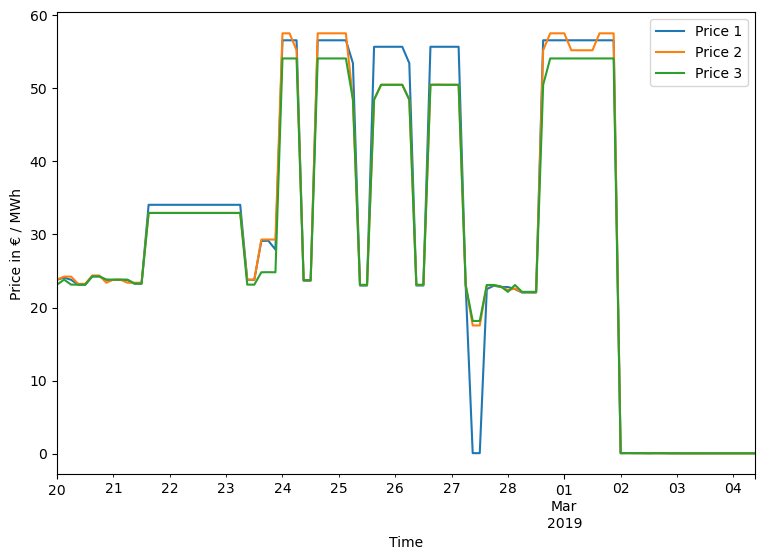

In [16]:
fig= plt.figure(figsize=(9,6))

for i, price in enumerate(price_list):
    price[400:500].plot(
        label='Price ' + str(i+1),

    )

plt.legend()
plt.ylabel("Price in € / MWh")
plt.xlabel("Time")

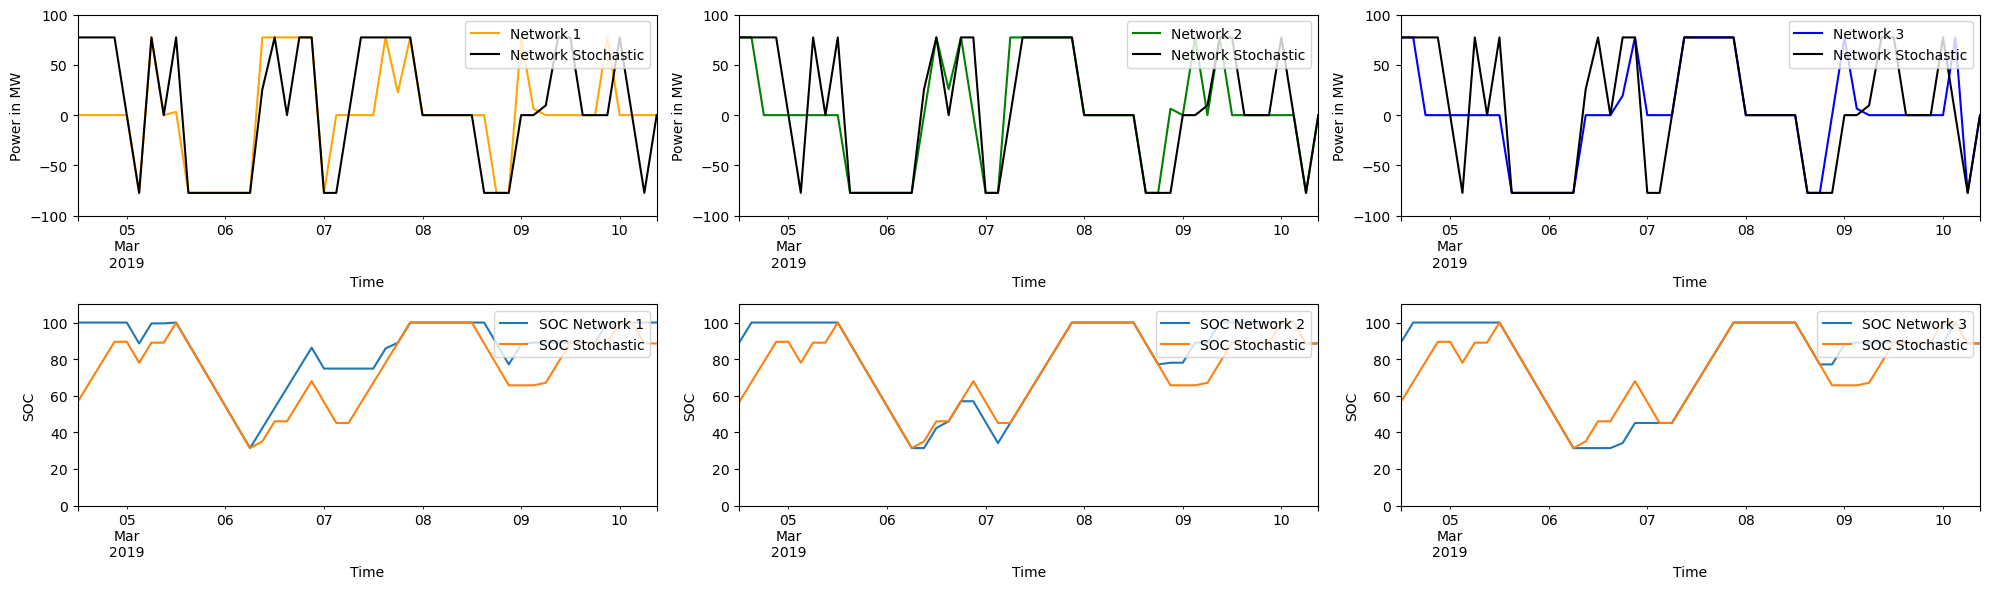

In [17]:
fig, ax= plt.subplots(2,3, figsize=(20,6))

color = ['orange', 'green', 'blue']

for i in [0,1,2]:
    n_p0 = networks_profit_optimized[i].links_t.p0["DE0 0 battery charger-2045"] + networks_profit_optimized[i].links_t.p0["DE0 0 battery charger-2040"] + networks_profit_optimized[i].links_t.p1["DE0 0 battery discharger-2045"] + networks_profit_optimized[i].links_t.p1["DE0 0 battery discharger-2040"]

    n_p0 = n_p0 / 1000
    n_p0[500:548].plot(
        label = "Network " + str(i+1),
        color = color[i],
        ax = ax[0][i],
        ylim=(-100, 100)

    )

    n_stoch_p0 = n_stochastic.links_t.p0["DE0 0 battery charger-2045"] + n_stochastic.links_t.p0["DE0 0 battery charger-2040"] + n_stochastic.links_t.p1["DE0 0 battery discharger-2045"] + n_stochastic.links_t.p1["DE0 0 battery discharger-2040"]
    n_stoch_p0 = n_stoch_p0 / 1000
    n_stoch_p0[500:548].plot(
    label = "Network Stochastic",
    color = 'black',
    ax = ax[0][i]
    )
    ax[0][i].set_xlabel("Time")
    ax[0][i].set_ylabel("Power in MW")
    ax[0][i].legend(loc="upper right")
    

for i in [0,1,2]:
    soc = networks_profit_optimized[i].stores_t.e.sum(axis=1) / (networks_profit_optimized[i].stores.e_nom.sum()-networks_profit_optimized[i].stores.e_nom["DE0 0 EV battery"])
    soc = soc * 100
    soc[500:548].plot(
        label="SOC Network " + str(i+1),
        ax = ax[1][i]
    )

    soc = n_stochastic.stores_t.e.sum(axis=1) /(n_stochastic.stores.e_nom.sum()-n_stochastic.stores.e_nom["DE0 0 EV battery"])
    soc = soc * 100
    soc[500:548].plot(
        label="SOC Stochastic",
        ax = ax[1][i],
        ylim = (0, 110)
    )

    ax[1][i].set_xlabel("Time")
    ax[1][i].set_ylabel("SOC")

    ax[1][i].legend(loc="upper right")

plt.tight_layout()